In [1]:
from __future__ import annotations
from abc        import ABC, abstractmethod
from typing     import List

import sys
sys.path.insert(0, '../../..')

import warnings
warnings.filterwarnings("ignore")
import joblib
import requests
import configparser
import asyncio
from binance.client import Client as BinanceClient
from binance.client import AsyncClient
from binance        import BinanceSocketManager
import pandas as pd
import numpy  as np

from ta import momentum, trend, volatility
from ta import volume as tavolume

import mlfinlab as fml

from cgi import test
from multiprocessing.sharedctypes import Value
from yaml import parse
import glob
import warnings
import requests
import dateutil
import pytz
import traceback
import pandas            as pd
import pandas_ta         as ta
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib.dates  as mdates
import mlfinlab          as fml
from   mlfinlab          import sample_weights
import pyfolio           as pf
from scipy.stats         import norm
from backtesting         import Backtest, Strategy
from backtesting.lib     import crossover

from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (20,12)

In [2]:
# Helper functions

from pathlib import PurePath, Path
import sys
import time
import warnings
import datetime as dt
import multiprocessing as mp
from datetime import datetime
from collections import OrderedDict as od
import re
import os
import json
import pandas as pd
import numpy as np
from numba import jit
from tqdm import tqdm
import matplotlib.pyplot as plt
import mplfinance as mpf

from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score

warnings.filterwarnings('ignore')


class MultiProcessingFunctions:
	""" This static functions in this class enable multi-processing"""
	def __init__(self):
		pass

	@staticmethod
	def lin_parts(num_atoms, num_threads):
		""" This function partitions a list of atoms in subsets (molecules) of equal size.
		An atom is a set of indivisible set of tasks.
		"""

		# partition of atoms with a single loop
		parts = np.linspace(0, num_atoms, min(num_threads, num_atoms) + 1)
		parts = np.ceil(parts).astype(int)
		return parts

	@staticmethod
	def nested_parts(num_atoms, num_threads, upper_triangle=False):
		""" This function enables parallelization of nested loops.
		"""
		# partition of atoms with an inner loop
		parts = []
		num_threads_ = min(num_threads, num_atoms)

		for num in range(num_threads_):
			part = 1 + 4 * (parts[-1] ** 2 + parts[-1] + num_atoms * (num_atoms + 1.) / num_threads_)
			part = (-1 + part ** .5) / 2.
			parts.append(part)

		parts = np.round(parts).astype(int)

		if upper_triangle:  # the first rows are heaviest
			parts = np.cumsum(np.diff(parts)[::-1])
			parts = np.append(np.array([0]), parts)
		return parts

	@staticmethod
	def mp_pandas_obj(func, pd_obj, num_threads=24, mp_batches=1, lin_mols=True, **kargs):
		"""	
		:param func: (string) function to be parallelized
		:param pd_obj: (vector) Element 0, is name of argument used to pass the molecule;
						Element 1, is the list of atoms to be grouped into a molecule
		:param num_threads: (int) number of threads
		:param mp_batches: (int) number of batches
		:param lin_mols: (bool) Tells if the method should use linear or nested partitioning
		:param kargs: (var args)
		:return: (data frame) of results
		"""

		if lin_mols:
			parts = MultiProcessingFunctions.lin_parts(len(pd_obj[1]), num_threads * mp_batches)
		else:
			parts = MultiProcessingFunctions.nested_parts(len(pd_obj[1]), num_threads * mp_batches)

		jobs = []
		for i in range(1, len(parts)):
			job = {pd_obj[0]: pd_obj[1][parts[i - 1]:parts[i]], 'func': func}
			job.update(kargs)
			jobs.append(job)

		if num_threads == 1:
			out = MultiProcessingFunctions.process_jobs_(jobs)
		else:
			out = MultiProcessingFunctions.process_jobs(jobs, num_threads=num_threads)

		if isinstance(out[0], pd.DataFrame):
			df0 = pd.DataFrame()
		elif isinstance(out[0], pd.Series):
			df0 = pd.Series()
		else:
			return out

		for i in out:
			df0 = df0.append(i)

		df0 = df0.sort_index()
		return df0

	@staticmethod
	def process_jobs_(jobs):
		""" Run jobs sequentially, for debugging """
		out = []
		for job in jobs:
			out_ = MultiProcessingFunctions.expand_call(job)
			out.append(out_)
		return out

	@staticmethod
	def expand_call(kargs):
		""" Expand the arguments of a callback function, kargs['func'] """
		func = kargs['func']
		del kargs['func']
		out = func(**kargs)
		return out

	@staticmethod
	def report_progress(job_num, num_jobs, time0, task):
		# Report progress as asynch jobs are completed

		msg = [float(job_num) / num_jobs, (time.time() - time0)/60.]
		msg.append(msg[1] * (1/msg[0] - 1))
		time_stamp = str(dt.datetime.fromtimestamp(time.time()))

		msg = time_stamp + ' ' + str(round(msg[0]*100, 2)) + '% '+task+' done after ' + \
			str(round(msg[1], 2)) + ' minutes. Remaining ' + str(round(msg[2], 2)) + ' minutes.'

		if job_num < num_jobs:
			sys.stderr.write(msg+'\r')
		else:
			sys.stderr.write(msg+'\n')

		return

	@staticmethod
	def process_jobs(jobs, task=None, num_threads=24):
		""" Run in parallel. jobs must contain a 'func' callback, for expand_call"""

		if task is None:
			task = jobs[0]['func'].__name__

		pool = mp.Pool(processes=num_threads)
		# outputs, out, time0 = pool.imap_unordered(MultiProcessingFunctions.expand_call,jobs),[],time.time()
		outputs = pool.imap_unordered(MultiProcessingFunctions.expand_call, jobs)
		out = []
		time0 = time.time()

		# Process asyn output, report progress
		for i, out_ in enumerate(outputs, 1):
			out.append(out_)
			MultiProcessingFunctions.report_progress(i, len(jobs), time0, task)

		pool.close()
		pool.join()  # this is needed to prevent memory leaks
		return out


def get_daily_vol(close, lookback=100):
    """
    :param close: (data frame) Closing prices
    :param lookback: (int) lookback period to compute volatility
    :return: (series) of daily volatility value
    """
    print('Calculating daily volatility for dynamic thresholds')
    
    df0 = close.index.searchsorted(close.index - pd.Timedelta(days=1))
    df0 = df0[df0 > 0]
    df0 = (pd.Series(close.index[df0 - 1], index=close.index[close.shape[0] - df0.shape[0]:]))
        
    df0 = close.loc[df0.index] / close.loc[df0.values].values - 1  # daily returns
    df0 = df0.ewm(span=lookback).std()
    return df0


def get_t_events(raw_price, threshold):
    """
    :param raw_price: (series) of close prices.
    :param threshold: (float) when the abs(change) is larger than the threshold, the
    function captures it as an event.
    :return: (datetime index vector) vector of datetimes when the events occurred. This is used later to sample.
    """
    print('Applying Symmetric CUSUM filter.')

    t_events = []
    s_pos = 0
    s_neg = 0

    # log returns
    diff = np.log(raw_price).diff().dropna()

    # Get event time stamps for the entire series
    for i in tqdm(diff.index[1:]):
        pos = float(s_pos + diff.loc[i])
        neg = float(s_neg + diff.loc[i])
        s_pos = max(0.0, pos)
        s_neg = min(0.0, neg)

        if s_neg < -threshold:
            s_neg = 0
            t_events.append(i)

        elif s_pos > threshold:
            s_pos = 0
            t_events.append(i)

    event_timestamps = pd.DatetimeIndex(t_events)
    return event_timestamps


def add_vertical_barrier(t_events, close, num_days=1):
    """
    :param t_events: (series) series of events (symmetric CUSUM filter)
    :param close: (series) close prices
    :param num_days: (int) maximum number of days a trade can be active
    :return: (series) timestamps of vertical barriers
    """
    t1 = close.index.searchsorted(t_events + pd.Timedelta(days=num_days))
    t1 = t1[t1 < close.shape[0]]
    t1 = pd.Series(close.index[t1], index=t_events[:t1.shape[0]])  # NaNs at end
    return t1


def apply_pt_sl_on_t1(close, events, pt_sl, molecule):
    """
    :param close: (series) close prices
    :param events: (series) of indices that signify "events" 
    :param pt_sl: (array) element 0, indicates the profit taking level; 
                          element 1 is stop loss level
    :param molecule: (an array) a set of datetime index values for processing
    :return: (dataframe) timestamps at which each barrier was touched
    """
    # apply stop loss/profit taking, if it takes place before t1 (end of event)
    events_ = events.loc[molecule]
    out = events_[['t1']].copy(deep=True)
    if pt_sl[0] > 0:
        pt = pt_sl[0] * events_['trgt']
    else:
        pt = pd.Series(index=events.index)  # NaNs

    if pt_sl[1] > 0:
        sl = -pt_sl[1] * events_['trgt']
    else:
        sl = pd.Series(index=events.index)  # NaNs

    for loc, t1 in events_['t1'].fillna(close.index[-1]).iteritems():
        df0 = close[loc:t1]  # path prices
        df0 = (df0 / close[loc] - 1) * events_.at[loc, 'side']  # path returns
        out.loc[loc, 'sl'] = df0[df0 < sl[loc]].index.min()  # earliest stop loss
        out.loc[loc, 'pt'] = df0[df0 > pt[loc]].index.min()  # earliest profit taking

    return out


def get_events(close, t_events, pt_sl, target, min_ret, num_threads, 
              vertical_barrier_times=False, side=None):
    """
    :param close: (series) Close prices
    :param t_events: (series) of t_events. 
                     These are timestamps that will seed every triple barrier.
    :param pt_sl: (2 element array) element 0, indicates the profit taking level; 
                  element 1 is stop loss level.
                  A non-negative float that sets the width of the two barriers. 
                  A 0 value means that the respective horizontal barrier will be disabled.
    :param target: (series) of values that are used (in conjunction with pt_sl)
                   to determine the width of the barrier.
    :param min_ret: (float) The minimum target return required for running a triple barrier search.
    :param num_threads: (int) The number of threads concurrently used by the function.
    :param vertical_barrier_times: (series) A pandas series with the timestamps of the vertical barriers.
    :param side: (series) Side of the bet (long/short) as decided by the primary model
    :return: (data frame) of events
            -events.index is event's starttime
            -events['t1'] is event's endtime
            -events['trgt'] is event's target
            -events['side'] (optional) implies the algo's position side
    """

    # 1) Get target
    target = target.loc[target.index.intersection(t_events)]
    target = target[target > min_ret]  # min_ret

    # 2) Get vertical barrier (max holding period)
    if vertical_barrier_times is False:
        vertical_barrier_times = pd.Series(pd.NaT, index=t_events)

    # 3) Form events object, apply stop loss on vertical barrier
    if side is None:
        side_ = pd.Series(1., index=target.index)
        pt_sl_ = [pt_sl[0], pt_sl[0]]
    else:
        side_ = side.loc[target.index]
        pt_sl_ = pt_sl[:2]

    events = pd.concat({'t1': vertical_barrier_times, 'trgt': target, 'side': side_},
                        axis=1)
    events = events.dropna(subset=['trgt'])

    # Apply Triple Barrier
    df0 = MultiProcessingFunctions.mp_pandas_obj(func=apply_pt_sl_on_t1,
                                                 pd_obj=('molecule', events.index),
                                                 num_threads=num_threads,
                                                 close=close,
                                                 events=events,
                                                 pt_sl=pt_sl_)

    events['t1'] = df0.dropna(how='all').min(axis=1)  # pd.min ignores nan

    if side is None:
        events = events.drop('side', axis=1)

    return events


def barrier_touched(out_df):
    """
    :param out_df: (DataFrame) containing the returns and target
    :return: (DataFrame) containing returns, target, and labels
    """
    store = []
    for i in np.arange(len(out_df)):
        date_time = out_df.index[i]
        ret       = out_df.loc[date_time, 'ret' ]
        target    = out_df.loc[date_time, 'trgt']

        if ret > 0.0 and ret > target:
            # Top barrier reached
            store.append(1)
        elif ret < 0.0 and ret < -target:
            # Bottom barrier reached
            store.append(-1)
        else:
            # Vertical barrier reached
            store.append(0)

    out_df['bin'] = store

    return out_df


def get_bins(triple_barrier_events, close):
    """
    :param triple_barrier_events: (data frame)
                -events.index is event's starttime
                -events['t1'] is event's endtime
                -events['trgt'] is event's target
                -events['side'] (optional) implies the algo's position side
                Case 1: ('side' not in events): bin in (-1,1) <-label by price action
                Case 2: ('side' in events): bin in (0,1) <-label by pnl (meta-labeling)
    :param close: (series) close prices
    :return: (data frame) of meta-labeled events
    """

    # 1) Align prices with their respective events
    events_ = triple_barrier_events.dropna(subset=['t1'])
    prices = events_.index.union(events_['t1'].values)
    prices = prices.drop_duplicates()
    prices = close.reindex(prices, method='bfill')
    
    # 2) Create out DataFrame
    out_df = pd.DataFrame(index=events_.index)
    # Need to take the log returns, else your results will be skewed for short positions
    out_df['ret' ] = np.log(prices.loc[events_['t1'].values].values) - np.log(prices.loc[events_.index])
    out_df['trgt'] = events_['trgt']

    # Meta labeling: Events that were correct will have pos returns
    if 'side' in events_:
        out_df['ret'] = out_df['ret'] * events_['side']  # meta-labeling

    # Added code: label 0 when vertical barrier reached
    out_df = barrier_touched(out_df)

    # Meta labeling: label incorrect events with a 0
    if 'side' in events_:
        out_df.loc[out_df['ret'] <= 0, 'bin'] = 0
    
    # Transform the log returns back to normal returns.
    out_df['ret'] = np.exp(out_df['ret']) - 1
    
    # Add the side to the output. This is useful for when a meta label model must be fit
    tb_cols = triple_barrier_events.columns
    if 'side' in tb_cols:
        out_df['side'] = triple_barrier_events['side']
        
    out_df

    return out_df


def get_daily_volatility(close, lookback=100):
    # daily vol re-indexed to close
    df0 = close.index.searchsorted(close.index - pd.Timedelta(days=1))
    df0 = df0[df0 > 0]
    df0 = (pd.Series(close.index[df0 - 1], index=close.index[close.shape[0] - df0.shape[0]:]))
    df0 = close.loc[df0.index] / close.loc[df0.array].array - 1  # daily returns
    df0 = df0.ewm(span=lookback).std()
    return df0

def cci_indicator(df_, length=40):
    hlc3 = (df_['High']+df_['Low']+df_['Close'])/3
    sma  = hlc3.rolling(length).mean()
    mad  = hlc3.rolling(length).apply(lambda x: pd.Series(x).mad())
    cci  = (hlc3-sma)/(0.015*mad)
    cci_smooth = cci.ewm(span=5, min_periods=0, adjust=False, ignore_na=False).mean()
    return cci, cci_smooth

In [3]:
signals_df = pd.read_csv("../model/BTCUSDT-primary-signals.csv", parse_dates=True, index_col="timestamp")
signals_df

,position
timestamp,
2018-01-01 00:06:00,-1
2018-01-02 18:24:00,1
2018-01-02 19:20:00,-1
2018-01-05 09:04:00,1
2018-01-05 17:26:00,1
...,...
2022-12-29 22:36:00,-1
2022-12-30 11:07:00,-1
2022-12-31 00:06:00,-1


In [4]:
df = pd.read_csv("/home/sharav/src/project-feature-generation/data/features_BTCUSDT-1m-spot.csv", parse_dates=True, index_col="timestamp")
df

,Open,High,Low,Close,Volume,m_rsi,m_roc,m_wr,vm_cmf,vm_mfi,...,HT_SINE_sine,HT_SINE_leadsine,HT_TRENDMODE,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-08-18 04:04:00,4269.26,4269.26,4269.26,4269.26,0.988305,38.387955,-0.440284,-99.185249,0.636822,42.520834,...,-0.999636,-0.687760,0,1.146701,0.880253,16.873143,-13.129643,19.905429,-0.233253,9.252000
2017-08-18 04:05:00,4269.01,4269.01,4269.01,4269.01,0.557007,38.236424,-0.446114,-100.000000,0.626582,40.226107,...,-0.779648,-0.108492,0,1.000000,0.863521,12.400286,-36.856195,22.145429,-0.749626,11.392851
2017-08-18 04:07:00,4269.01,4269.01,4269.01,4269.01,0.591960,38.236424,-0.446346,-100.000000,0.682004,40.226107,...,-0.652191,0.074857,0,1.000000,0.808468,4.594286,-56.833464,24.485714,-1.530110,9.327503
2017-08-18 04:08:00,4269.01,4269.01,4269.01,4269.01,0.339186,38.236424,-0.446346,-100.000000,0.650170,37.361274,...,-0.694225,0.018055,0,1.000000,0.758373,1.512571,-60.862617,24.833143,-1.793890,0.100000
2017-08-18 04:09:00,4269.01,4269.01,4269.01,4269.01,0.320267,38.236424,-0.446346,-100.000000,0.550699,37.361274,...,-0.603405,0.137199,0,1.000000,0.773224,-1.022286,-63.128481,24.633714,-1.973538,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-30 23:55:00,17175.50,17215.59,17170.01,17173.33,531.365170,46.137493,-0.114233,-94.197833,0.083025,62.619445,...,-0.906090,-0.939869,1,-0.009388,0.938741,10.803714,-61.993322,35.246286,-1.880198,11.653086
2022-11-30 23:56:00,17173.33,17175.40,17150.70,17167.16,322.428780,43.956738,-0.319124,-78.492095,0.073701,56.234268,...,-0.987122,-0.811116,0,0.326073,0.938331,8.844286,-70.714762,45.997143,-2.857912,11.572630
2022-11-30 23:57:00,17165.50,17170.80,17156.77,17161.26,160.506230,41.916461,-0.303599,-86.201490,0.074486,51.053431,...,-0.989422,-0.597048,0,0.324145,0.939648,5.946000,-75.486770,56.165429,-3.863033,12.204749


In [5]:
df["volatility_tpsl_600"] = get_daily_volatility(close=df['Close'], lookback=600)
df["volatility_tpsl_840"] = get_daily_volatility(close=df['Close'], lookback=840)

In [6]:
holding_period    = 2.0
vertical_barriers = add_vertical_barrier(t_events=signals_df.index, close=df['Close'], num_days=float(holding_period))

In [7]:
# TBL labeling training set 

RR         = 2.0
sl_target  = 1.0

min_ret    = 0.001 # minimum return of 0.1%

long_ptsl  = [round(sl_target*RR, 2), sl_target]
short_ptsl = [round(sl_target*RR, 2), sl_target]

print(f"{RR} -> {long_ptsl}")


long_triple_barrier_events = get_events( 
                                    close                  = df['Close'],
                                    t_events               = signals_df[signals_df['position']==1].index,
                                    pt_sl                  = long_ptsl,
                                    target                 = df['volatility_tpsl_600'],
                                    min_ret                = min_ret,
                                    num_threads            = 8,
                                    vertical_barrier_times = vertical_barriers,
                                    side                   = signals_df[signals_df['position']==1]['position']
                                    )

short_triple_barrier_events = get_events( 
                                    close                  = df['Close'],
                                    t_events               = signals_df[signals_df['position']==-1].index,
                                    pt_sl                  = short_ptsl,
                                    target                 = df['volatility_tpsl_600'],
                                    min_ret                = min_ret,
                                    num_threads            = 8,
                                    vertical_barrier_times = vertical_barriers,
                                    side                   = signals_df[signals_df['position']==-1]['position']
                                    )

triple_barrier_events = pd.concat([long_triple_barrier_events, short_triple_barrier_events])
triple_barrier_events = triple_barrier_events.sort_index()
triple_barrier_events.dropna(inplace=True)


labels = get_bins(triple_barrier_events, df['Close'])
labels.dropna(inplace=True)

labels = labels.sort_index()
labels = labels[~labels.index.duplicated(keep='last')]

2.0 -> [2.0, 1.0]


2023-01-22 20:31:36.662057 100.0% apply_pt_sl_on_t1 done after 0.1 minutes. Remaining 0.0 minutes..
2023-01-22 20:31:41.206649 100.0% apply_pt_sl_on_t1 done after 0.06 minutes. Remaining 0.0 minutes.


In [8]:
labels

,ret,trgt,bin,side
timestamp,,,,
2018-01-01 00:06:00,-0.045580,0.045566,0,-1.0
2018-01-02 18:24:00,0.064879,0.029906,1,1.0
2018-01-02 19:20:00,0.021736,0.041113,0,-1.0
2018-01-05 09:04:00,0.050633,0.024803,1,1.0
2018-01-05 17:26:00,-0.022213,0.046620,0,1.0
...,...,...,...,...
2022-11-23 02:24:00,0.005790,0.013990,0,1.0
2022-11-28 03:38:00,0.025135,0.011727,1,1.0
2022-11-30 01:00:00,-0.008475,0.007683,0,-1.0


In [9]:
labels['bin'].value_counts()

0    2180
1    1792
Name: bin, dtype: int64

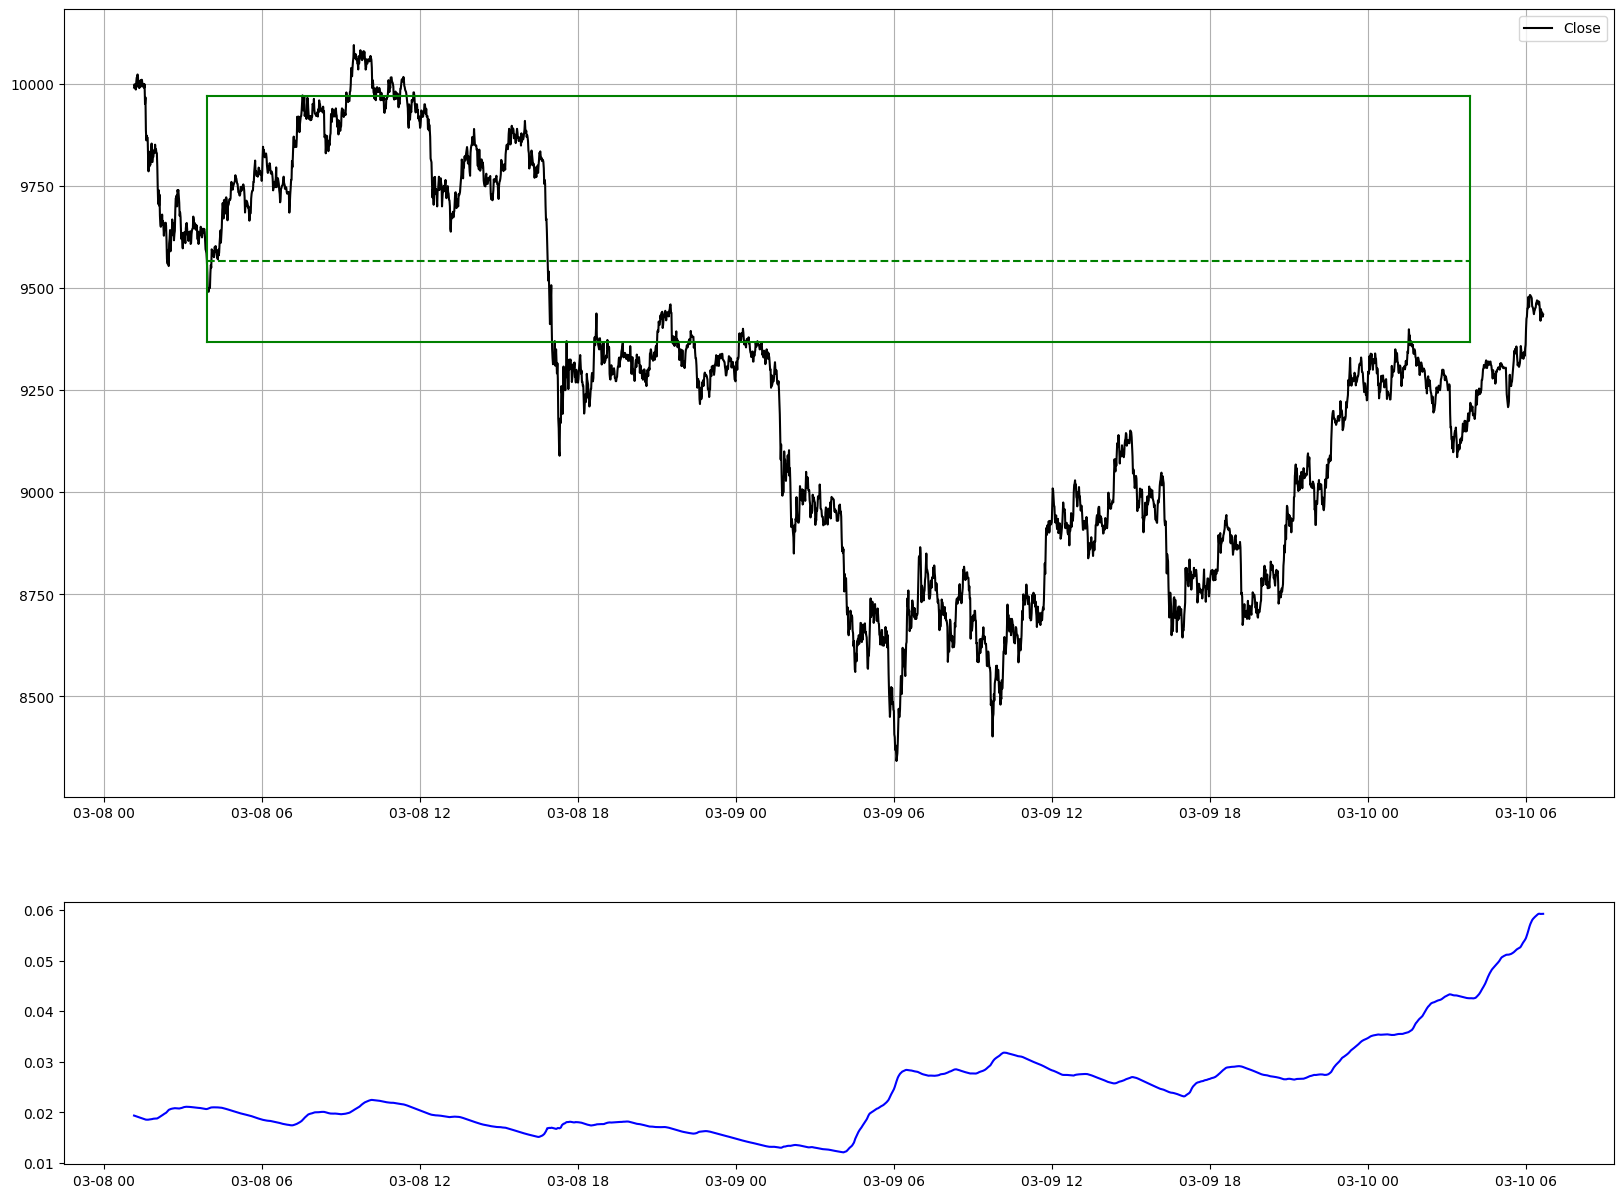

In [12]:
# Plotting buy side labels

f, axs = plt.subplots(2, gridspec_kw={'height_ratios': [3,1]}, figsize=(20,15))

label         = labels[(labels['bin']==1)&(labels['side']==1)].sample()
selected_date = label.index[0]

duration_seconds = 172800  # 2 days

frame_start   = selected_date - pd.Timedelta(seconds=10000) 
frame_end     = selected_date + pd.Timedelta(seconds=duration_seconds+10000)

df_ = df.loc[(df.index>=frame_start)&(df.index<=frame_end)]

event_start = selected_date
event_end   = selected_date+pd.Timedelta(seconds=duration_seconds)

close_price = df.loc[df.index==selected_date]['Close'].values[-1]

volatility_tpsl = round(df['volatility_tpsl_600'][selected_date], 6)

ret_upper = np.exp(round((volatility_tpsl*long_ptsl[0]), 6))-1.0
ret_lower = np.exp(round((volatility_tpsl*long_ptsl[1]), 6))-1.0

price_upper = (ret_upper+1.0)*close_price
price_lower = (ret_lower+1.0)*close_price

delta_upper = abs(close_price-price_upper)
delta_lower = abs(close_price-price_lower)

price_tp = close_price+delta_upper
price_sl = close_price-delta_lower


df_plot = df_

axs[0].plot(df_plot['Close'], color='k', label='Close')
axs[0].legend(loc='best')
axs[0].grid()

axs[0].plot([event_start, event_end  ], [price_tp    , price_tp  ], 'r-' , color='g')
axs[0].plot([event_start, event_end  ], [price_sl    , price_sl  ], 'r-' , color='g')
axs[0].plot([event_start, event_end  ], [close_price, close_price], 'r--', color='g')
axs[0].plot([event_start, event_start], [price_sl    , price_tp  ], 'r-' , color='g')
axs[0].plot([event_end  , event_end  ], [price_sl    , price_tp  ], 'r-' , color='g')

axs[1].plot(df_plot['volatility_tpsl_600'], color='b', label="daily volatility")

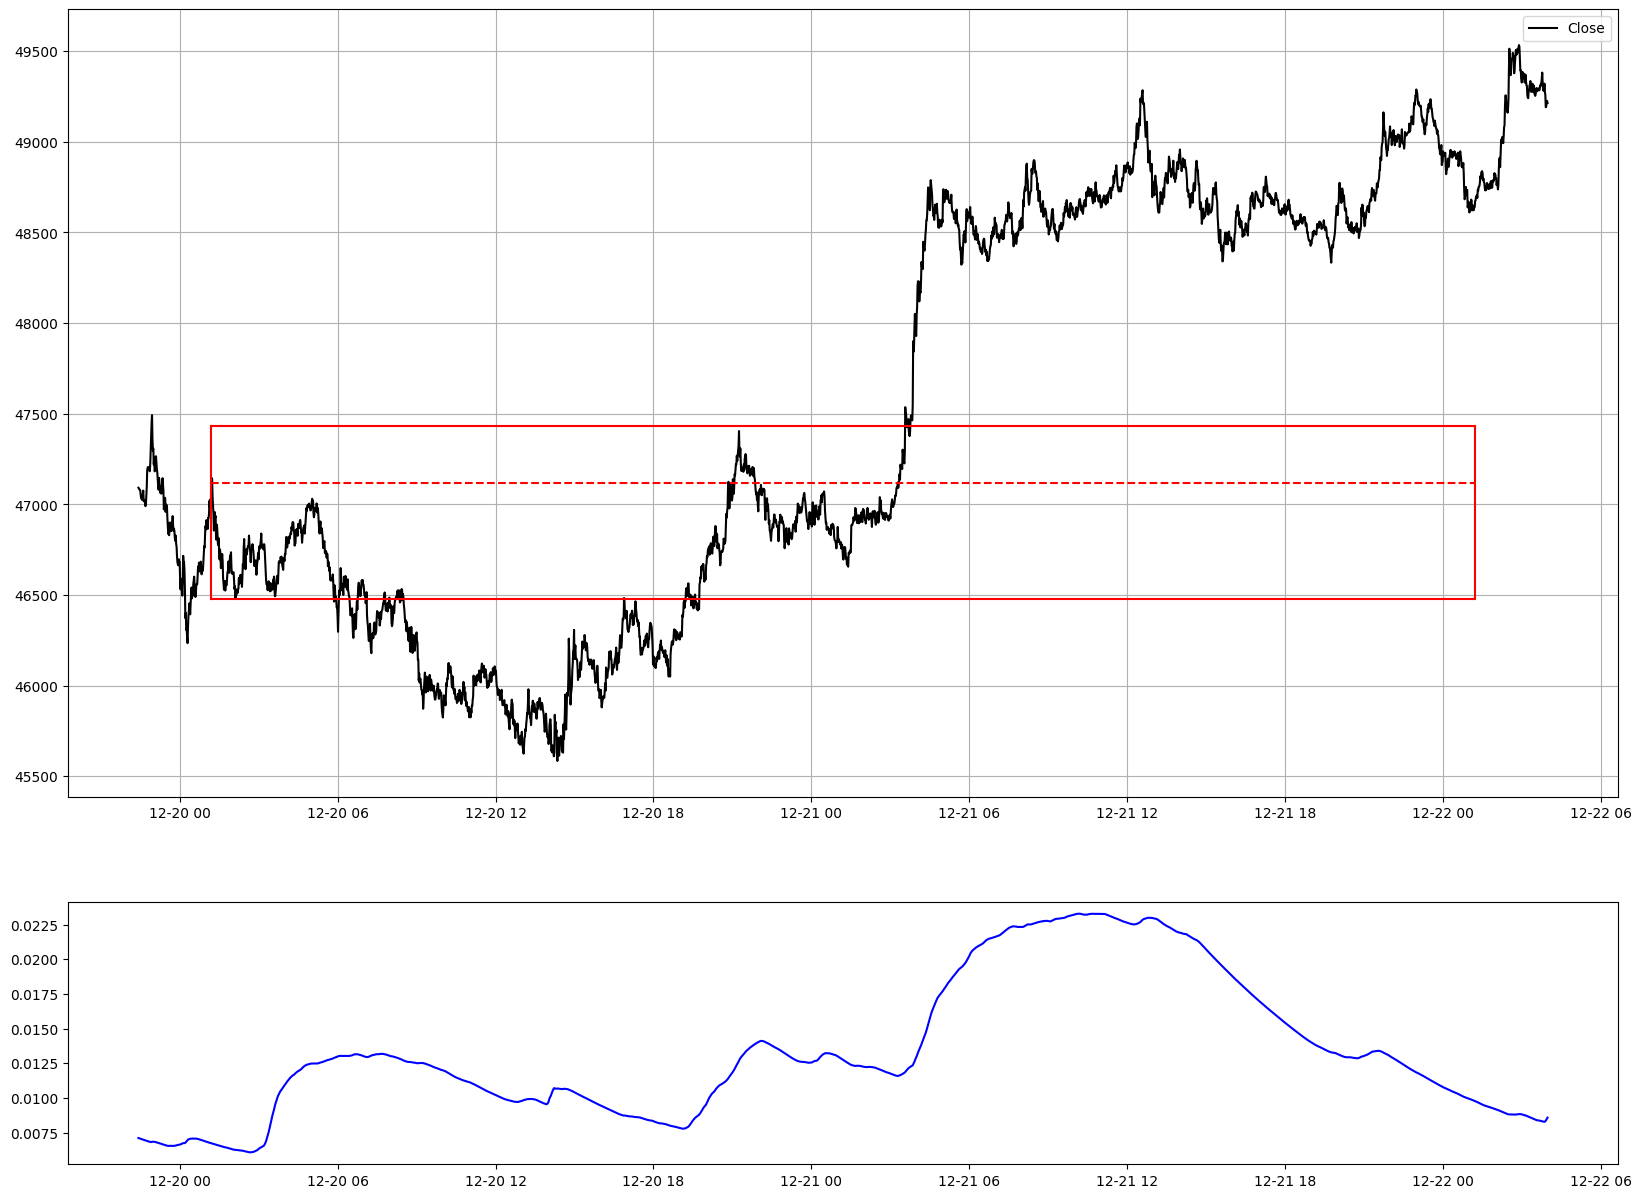

In [13]:
# Plotting sell side labels

f, axs = plt.subplots(2, gridspec_kw={'height_ratios': [3,1]}, figsize=(20,15))

label         = labels[(labels['bin']==1)&(labels['side']==-1)].sample()
selected_date = label.index[0]

duration_seconds = 172800 # 2 days

frame_start   = selected_date - pd.Timedelta(seconds=10000) 
frame_end     = selected_date + pd.Timedelta(seconds=duration_seconds+10000)

df_ = df.loc[(df.index>=frame_start)&(df.index<=frame_end)]

event_start = selected_date
event_end   = selected_date+pd.Timedelta(seconds=duration_seconds)

close_price = df.loc[df.index==selected_date]['Close'].values[-1]

volatility_tpsl = round(df['volatility_tpsl_600'][selected_date], 6)

ret_upper = np.exp(round((volatility_tpsl*short_ptsl[1]), 6))-1.0
ret_lower = np.exp(round((volatility_tpsl*short_ptsl[0]), 6))-1.0

price_upper = (ret_upper+1.0)*close_price
price_lower = (ret_lower+1.0)*close_price

delta_upper = abs(close_price-price_upper)
delta_lower = abs(close_price-price_lower)

price_sl = close_price+delta_upper
price_tp = close_price-delta_lower


df_plot = df_

axs[0].plot(df_plot['Close'], color='k', label='Close')
axs[0].legend(loc='best')
axs[0].grid()

axs[0].plot([event_start, event_end  ], [price_tp    , price_tp  ], 'r-' , color='r')
axs[0].plot([event_start, event_end  ], [price_sl    , price_sl  ], 'r-' , color='r')
axs[0].plot([event_start, event_end  ], [close_price, close_price], 'r--', color='r')
axs[0].plot([event_start, event_start], [price_sl    , price_tp  ], 'r-' , color='r')
axs[0].plot([event_end  , event_end  ], [price_sl    , price_tp  ], 'r-' , color='r')

axs[1].plot(df_plot['volatility_tpsl_600'], color='b', label="daily volatility")

In [14]:
df['side'           ] = labels['side']
df['volatility_tpsl'] = df['volatility_tpsl_600']

In [15]:
trainable_features = [feature for feature in list(df.columns) if not feature in ["position", "Open", "High", "Low", "Close", "primary_side", "primary_prob", "is_signal"]]+['side']
print(trainable_features)

['Volume', 'm_rsi', 'm_roc', 'm_wr', 'vm_cmf', 'vm_mfi', 'vm_fi', 'vm_eom', 'vl_bbp', 'vl_atr', 't_macdd', 't_trix', 't_cci', 't_dpo', 't_kst', 't_adx', 'log_ret', 'momentum_1', 'momentum_2', 'momentum_3', 'momentum_4', 'momentum_5', 'momentum_6', 'volatility_3', 'volatility_6', 'volatility_10', 'volatility_25', 'volatility_30', 'volatility_45', 'autocorr_1', 'autocorr_2', 'autocorr_3', 'autocorr_4', 'autocorr_5', 'log_lag_1', 'log_lag_2', 'log_lag_3', 'log_lag_4', 'log_lag_5', 'log_lag_6', 'log_lag_7', 'm_rsi_6', 'm_roc_6', 'm_wr_6', 'vm_cmf_6', 'vm_mfi_6', 'vm_fi_6', 'vm_eom_6', 'vl_bbp_6', 'vl_atr_6', 't_macd_12_6', 't_trix_6', 't_cci_6', 't_dpo_6', 't_adx_6', 'm_rsi_12', 'm_roc_12', 'm_wr_12', 'vm_cmf_12', 'vm_mfi_12', 'vm_fi_12', 'vm_eom_12', 'vl_bbp_12', 'vl_atr_12', 't_macd_24_12', 't_trix_12', 't_cci_12', 't_dpo_12', 't_adx_12', 'm_rsi_25', 'm_roc_25', 'm_wr_25', 'vm_cmf_25', 'vm_mfi_25', 'vm_fi_25', 'vm_eom_25', 'vl_bbp_25', 'vl_atr_25', 't_macd_50_25', 't_trix_25', 't_cci_25'

In [16]:
meta_labels = labels.copy()
meta_labels['bin'] = labels['bin']
meta_labels['bin'].value_counts()

0    2180
1    1792
Name: bin, dtype: int64

In [17]:
meta_labels_train = meta_labels[:"2022-01-12"]
meta_labels_oos   = meta_labels["2022-01-14":]

In [18]:
# ML friendly dataset for meta labels

X_train = df.loc[meta_labels_train.index][trainable_features].copy()
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train.fillna(0, inplace=True)
y_train = meta_labels_train['bin']

X_test  = df.loc[meta_labels_oos.index][trainable_features].copy()
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.fillna(0, inplace=True)
y_test  = meta_labels_oos['bin']

<AxesSubplot: >

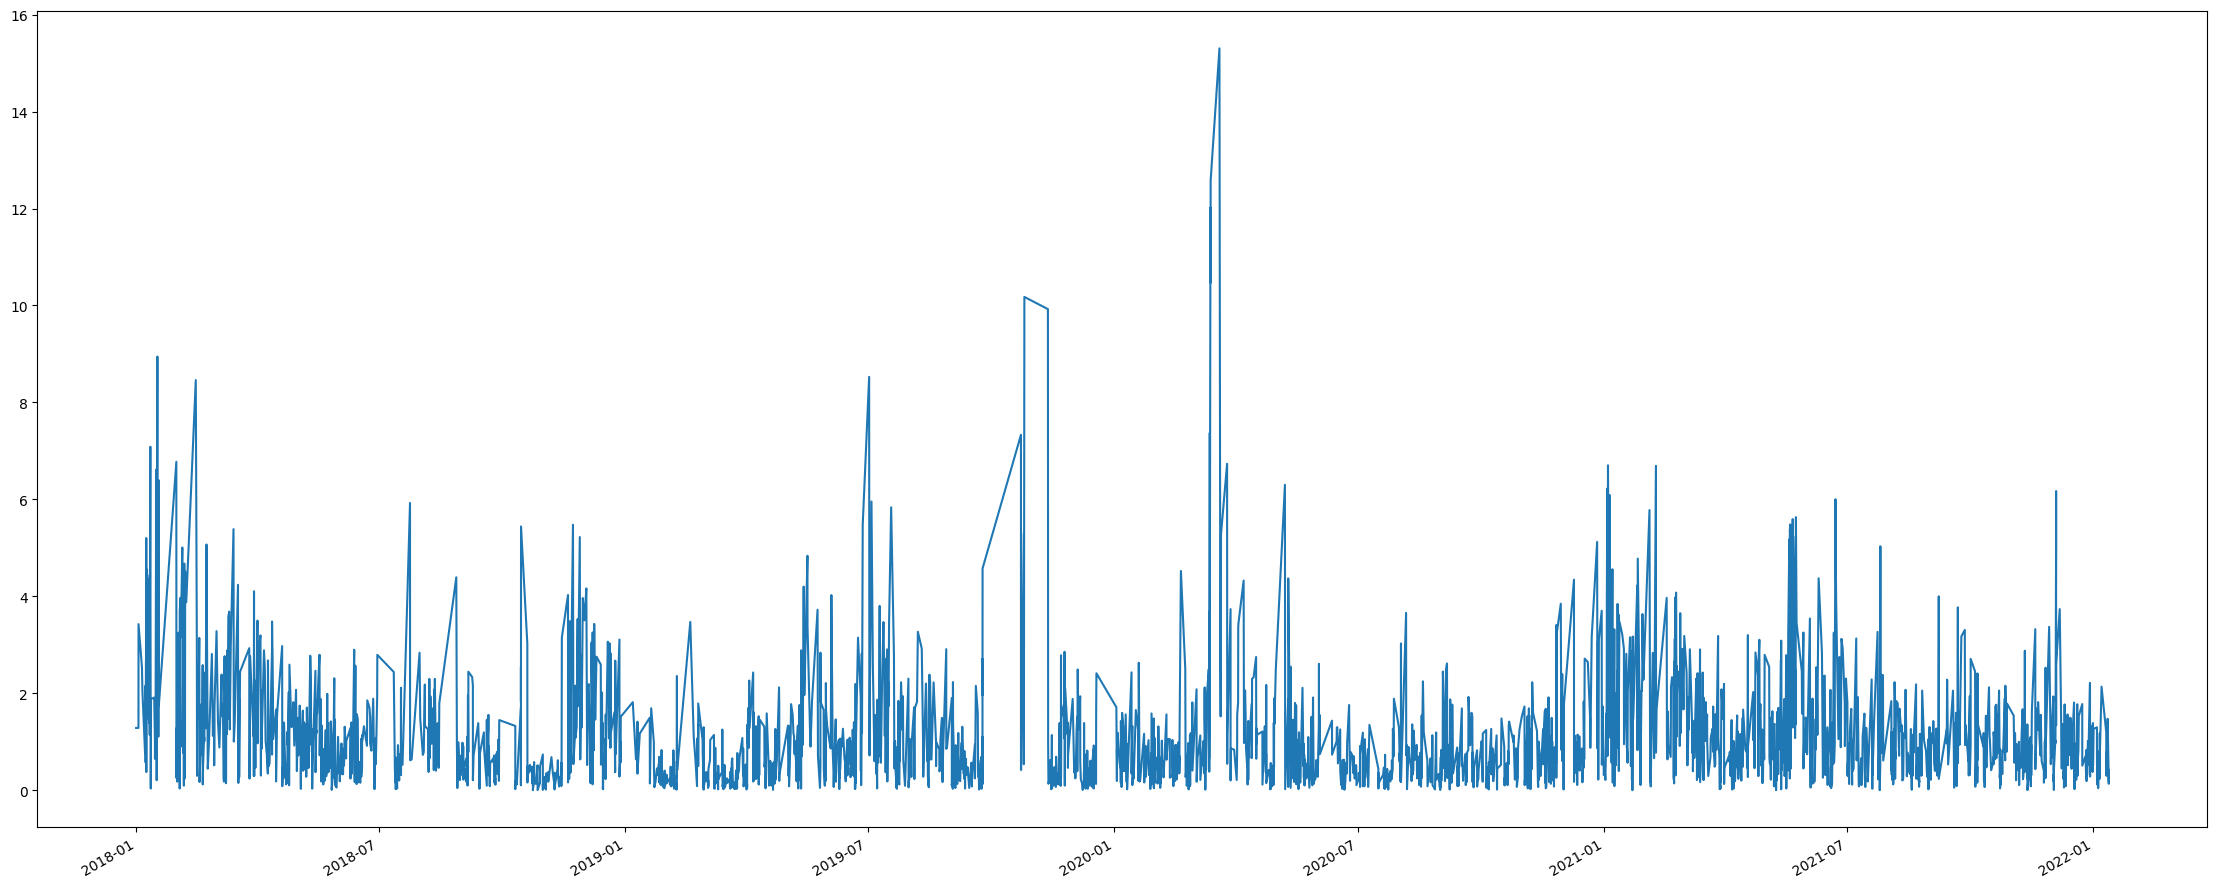

In [19]:
from mlfinlab.sample_weights import get_weights_by_return

return_based_sample_weights_meta = get_weights_by_return(
    triple_barrier_events.loc[X_train.index], 
    df.loc[X_train.index, 'Close'],
    num_threads=1)

_, axs = plt.subplots(1, figsize=(28,12))
return_based_sample_weights_meta.plot(ax=axs)

In [20]:
# Clusters
clusters = {0: ['HT_DCPHASE'], 1: ['HT_SINE_leadsine'], 2: ['m_wr', 'm_wr_6', 'vl_bbp_6', 't_cci_6', 'm_wr_12', 'vl_bbp_12', 't_cci_12', 'm_wr_25', 'close_sign', 'BOP', 'CCI', 'STOCH_slowk', 'STOCHF_fastk', 'STOCHF_fastd', 'STOCHRSI_fastk', 'WILLR'], 3: ['autocorr_1', 'autocorr_2', 'autocorr_3', 'autocorr_4', 'autocorr_5', 'HT_DCPERIOD', 'HT_TRENDMODE', 'BETA', 'CORREL'], 4: ['high_log', 'close_log', 'sma_6_log', 'sma_12_log', 'sma_25_log', 'sma_50_log', 'sma_110_log', 'sma_220_log', 'sma_440_log'], 5: ['vm_eom', 'vm_eom_6', 'vm_eom_12', 'vm_eom_25', 'vm_eom_50', 'vm_eom_90', 'vm_eom_120', 'vm_eom_180', 'vm_eom_300', 'vm_eom_400'], 6: ['vm_cmf', 'vm_cmf_12', 'vm_cmf_25', 'vm_cmf_50', 'close_plus_minus_20', 'close_plus_minus_40'], 7: ['m_roc', 't_trix_6', 'm_roc_12', 'm_roc_25', 'ma_25', 'ma_50', 'ADOSC'], 8: ['DEMA', 'EMA', 'HT_TRENDLINE', 'KAMA', 'MA', 'MIDPOINT', 'SMA', 'T3', 'TRIMA', 'WMA', 'LINEARREG_INTERCEPT'], 9: ['vl_atr', 'vl_atr_6', 'vl_atr_12', 'vl_atr_25', 'ATR', 'TRANGE', 'STDDEV'], 10: ['t_macd_100_50', 't_macd_180_90', 't_macd_240_120', 't_macd_360_180', 't_macd_600_300', 't_macd_800_400', 'APO', 'MACD_macd', 'MACD_macdsignal'], 11: ['vm_fi', 'vm_fi_6', 'vm_fi_12', 'vm_fi_25', 'vm_fi_50', 'vm_fi_90', 'vm_fi_120', 'vm_fi_180', 'vm_fi_300', 'vm_fi_400'], 12: ['m_roc_90', 'm_roc_120', 'm_roc_180', 'm_roc_300', 'm_roc_400', 'ma_220', 'ma_440'], 13: ['log_ret', 'momentum_1', 'momentum_2'], 14: ['t_macdd', 't_macd_12_6', 't_macd_24_12', 't_macd_50_25', 'MACD_macdhist', 'MOM', 'LINEARREG_SLOPE'], 15: ['volatility_3', 'volatility_6', 'volatility_10', 'volatility_25', 'volatility_30', 'volatility_45', 'daily_volatility_15', 'daily_volatility_30', 'daily_volatility_50', 'daily_volatility_120', 'daily_volatility_240', 'NATR', 'volatility_tpsl'], 16: ['t_trix_90', 't_trix_120', 't_trix_180'], 17: ['m_rsi_25', 'vm_mfi_25', 'm_rsi_50', 't_cci_50', 'm_wr_90', 'vl_bbp_90', 't_cci_90', 'm_wr_120', 'vl_bbp_120', 't_cci_120', 'm_wr_180', 'vl_bbp_180'], 18: ['t_adx_50', 't_adx_90', 't_adx_120', 't_adx_180', 't_adx_300', 't_adx_400'], 19: ['t_adx', 't_adx_12', 't_adx_25', 'ADX', 'ADXR'], 20: ['AROON_aroondown', 'MINUS_DI'], 21: ['momentum_3', 'momentum_4', 'momentum_5', 'momentum_6', 'm_roc_6', 'ma_6', 'ma_12'], 22: ['log_lag_3', 'log_lag_4', 'log_lag_5', 'log_lag_6', 'log_lag_7', 'HT_PHASOR_inphase', 'HT_PHASOR_quadrature'], 23: ['vm_mfi_180', 'vm_mfi_300', 'vm_mfi_400'], 24: ['vm_cmf_6', 'stochastic_k', 'stochastic_d', 'close_plus_minus_5', 'STOCH_slowd', 'STOCHRSI_fastd'], 25: ['t_trix', 't_kst', 't_trix_12', 'm_roc_50', 'ma_110'], 26: ['Volume', 'volume_log', 'volume_norm', 'volume_norm_log'], 27: ['t_dpo', 't_dpo_25', 't_dpo_50'], 28: ['t_dpo_6', 't_dpo_12', 'BBANDS_middleband', 'TEMA', 'LINEARREG'], 29: ['vm_mfi_50', 'm_rsi_90', 'vm_mfi_90', 'm_rsi_120', 'vm_mfi_120', 'm_rsi_180', 't_cci_180', 'm_rsi_300', 'm_wr_300', 'vl_bbp_300', 't_cci_300', 'm_rsi_400', 'm_wr_400', 'vl_bbp_400', 't_cci_400'], 30: ['t_adx_6', 'DX'], 31: ['vm_cmf_90', 'vm_cmf_120', 'vm_cmf_180', 'vm_cmf_300', 'vm_cmf_400'], 32: ['vl_atr_50', 'vl_atr_90', 'vl_atr_120', 'vl_atr_180', 'vl_atr_300', 'vl_atr_400', 'PLUS_DM'], 33: ['t_trix_300', 't_trix_400'], 34: ['sma_6', 'sma_12', 'sma_25', 'sma_50', 'sma_110', 'sma_220', 'sma_440', 'AD'], 35: ['t_trix_25', 't_trix_50', 'TRIX'], 36: ['price_volatility_norm', 'price_volatility_norm_log'], 37: ['BBANDS_upperband', 'MINUS_DM'], 38: ['log_lag_1', 'log_lag_2', 'HT_SINE_sine'], 39: ['m_rsi', 'vl_bbp', 't_cci', 'm_rsi_6', 'm_rsi_12', 'vl_bbp_25', 't_cci_25', 'm_wr_50', 'vl_bbp_50', 'RSI'], 40: ['BBANDS_lowerband', 'OBV'], 41: ['t_dpo_90', 't_dpo_120', 't_dpo_180', 't_dpo_300', 't_dpo_400'], 42: ['vm_mfi', 'vm_mfi_6', 'vm_mfi_12', 'AROON_aroonup', 'AROONOSC', 'MFI', 'PLUS_DI', 'ULTOSC', 'LINEARREG_ANGLE']}
print(clusters)

{0: ['HT_DCPHASE'], 1: ['HT_SINE_leadsine'], 2: ['m_wr', 'm_wr_6', 'vl_bbp_6', 't_cci_6', 'm_wr_12', 'vl_bbp_12', 't_cci_12', 'm_wr_25', 'close_sign', 'BOP', 'CCI', 'STOCH_slowk', 'STOCHF_fastk', 'STOCHF_fastd', 'STOCHRSI_fastk', 'WILLR'], 3: ['autocorr_1', 'autocorr_2', 'autocorr_3', 'autocorr_4', 'autocorr_5', 'HT_DCPERIOD', 'HT_TRENDMODE', 'BETA', 'CORREL'], 4: ['high_log', 'close_log', 'sma_6_log', 'sma_12_log', 'sma_25_log', 'sma_50_log', 'sma_110_log', 'sma_220_log', 'sma_440_log'], 5: ['vm_eom', 'vm_eom_6', 'vm_eom_12', 'vm_eom_25', 'vm_eom_50', 'vm_eom_90', 'vm_eom_120', 'vm_eom_180', 'vm_eom_300', 'vm_eom_400'], 6: ['vm_cmf', 'vm_cmf_12', 'vm_cmf_25', 'vm_cmf_50', 'close_plus_minus_20', 'close_plus_minus_40'], 7: ['m_roc', 't_trix_6', 'm_roc_12', 'm_roc_25', 'ma_25', 'ma_50', 'ADOSC'], 8: ['DEMA', 'EMA', 'HT_TRENDLINE', 'KAMA', 'MA', 'MIDPOINT', 'SMA', 'T3', 'TRIMA', 'WMA', 'LINEARREG_INTERCEPT'], 9: ['vl_atr', 'vl_atr_6', 'vl_atr_12', 'vl_atr_25', 'ATR', 'TRANGE', 'STDDEV'], 

In [21]:
# MDA, Mean Decrease Accuracy

import sys
import time
from datetime import datetime
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import BaggingClassifier
from sklearn.model_selection        import KFold
from sklearn.model_selection._split import _BaseKFold
from sklearn.metrics import log_loss, accuracy_score, f1_score, recall_score, precision_score,\
    precision_recall_curve, roc_curve
from copy import deepcopy
import multiprocessing as mp
import multiprocessing.pool
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
from concurrent.futures import _base
from concurrent.futures.process import _global_shutdown, BrokenProcessPool, _WorkItem


def linear_parts(num_atoms, num_threads):
    """Linear partitions
    Args:
        num_atoms (int): The number of data points
        num_threads (int): The number of partitions to split
    Returns:
        array-like: indices of start and end
    """
    parts = np.linspace(0, num_atoms, min(num_threads, num_atoms) + 1)
    parts = np.ceil(parts).astype(int)
    return parts


def nested_parts(num_atoms, num_threads, descend=False):
    """Nested partitions
    Args:
        num_atoms (int): The number of data points
        num_threads (int): The number of partitions to split
        descend (bool, optional): If True, the size of partitions are decreasing.
            Defaults to False.
    Returns:
        array-like: indices of start and end
    """
    parts = [0]
    num_threads = min(num_threads, num_atoms)
    for num in range(num_threads):
        part = 1 + 4 * (parts[-1] ** 2 + parts[-1] + num_atoms * (num_atoms + 1.) / num_threads)
        part = 0.5 * (-1 + np.sqrt(part))
        parts.append(part)
    if descend:
        # Computational decreases as index increases
        parts = np.cumsum(np.diff(parts)[::-1])
        parts = np.append(np.array([0]), parts)
    parts = np.round(parts).astype(int)
    return parts


class MyProcessPoolExecutor(ProcessPoolExecutor):
    def submit(*args, **kwargs):
        if len(args) >= 2:
            self, fn, *args = args
        elif not args:
            raise TypeError("descriptor 'submit' of 'ProcessPoolExecutor' object "
                            "needs an argument")
        elif 'fn' in kwargs:
            fn = kwargs.pop('fn')
            self, *args = args
        else:
            raise TypeError('submit expected at least 1 positional argument, '
                            'got %d' % (len(args)-1))

        with self._shutdown_lock:
            if self._broken:
                print(f"Broken Parameters: {args}, {kwargs}")
                raise BrokenProcessPool(self._broken)
            if self._shutdown_thread:
                raise RuntimeError(
                    'cannot schedule new futures after shutdown')
            if _global_shutdown:
                raise RuntimeError('cannot schedule new futures after '
                                   'interpreter shutdown')

            f = _base.Future()
            w = _WorkItem(f, fn, args, kwargs)

            self._pending_work_items[self._queue_count] = w
            self._work_ids.put(self._queue_count)
            self._queue_count += 1
            # Wake up queue management thread
            self._queue_management_thread_wakeup.wakeup()

            self._start_queue_management_thread()
            return f


def expand_call(kwargs):
    """Execute function from dictionary input"""
    func = kwargs['func']
    del kwargs['func']
    optional_argument = None
    if "optional_argument" in kwargs:
        optional_argument = kwargs["optional_argument"]
        del kwargs["optional_argument"]

    transform = None
    if 'transform' in kwargs:
        transform = kwargs['transform']
        del kwargs['transform']

    def wrapped_func(**input_kwargs):
        if transform is not None:
            input_kwargs = transform(input_kwargs)
        try:
            return func(**input_kwargs)
        except Exception as e:
            print(e)
            print(f"paramteres: {input_kwargs}")
            return e
    out = wrapped_func(**kwargs)
    if optional_argument is None:
        return (out, kwargs)
    else:
        return (out, kwargs, optional_argument)


def report_progress(job_idx, num_jobs, time0, task):
    """Report progress to system output"""
    msg = [float(job_idx) / num_jobs, (time.time() - time0) / 60.]
    msg.append(msg[1] * (1 / msg[0] - 1))
    time_stamp = str(datetime.fromtimestamp(time.time()))
    msg_ = time_stamp + ' ' + str(
        round(msg[0] * 100, 2)) + '% ' + task + ' done after ' + \
        str(round(msg[1], 2)) + ' minutes. Remaining ' + str(
        round(msg[2], 2)) + ' minutes.'
    if job_idx < num_jobs:
        sys.stderr.write(msg_ + '\r')
    else:
        sys.stderr.write(msg_ + '\n')

def process_jobs(jobs, task=None, num_threads=mp.cpu_count(), use_thread=False):
    """Execute parallelized jobs
    Parameters
    ----------
    jobs: list(dict)
        Each element contains `function` and its parameters
    task: str, optional
        The name of task. If not specified, function name is used
    num_threads, (default max count)
        The number of threads for parallelization
    Returns
    -------
    List: each element is results of each part
    """
    if task is None:
        if hasattr(jobs[0]['func'], '__name__'):
            task = jobs[0]['func'].__name__
        else:
            task = 'function'
    out = []
    if num_threads > 1:
        if use_thread:
            executor = ThreadPoolExecutor(max_workers=num_threads)
        else:
            executor = MyProcessPoolExecutor(max_workers=num_threads)
        outputs = executor.map(expand_call, jobs,
                               chunksize=1)
        time0 = time.time()
        # Execute programs here
        for i, out_ in enumerate(outputs, 1):
            out.append(out_)
            report_progress(i, len(jobs), time0, task)
    else:
        for job in jobs:
            job = deepcopy(job)
            out_ = expand_call(job)
            out.append(out_)
    return out

def mp_pandas_obj(func, pd_obj, num_threads=1, mp_batches=1,
                  linear_mols=True,
                  descend=False, **kwargs):
    """Return multiprocessed results
    Args:
        func　（function object)
    
        pd_obj (list):
            pd_obj[0], The name of parameters to be parallelized
            pd_obj[1], List of parameters to be parallelized
        mp_batches (int): The number of batches processed for each thread.
        linear_mols (bool):
            If True, use linear partition
            If False, use nested partition
        
        descend (bool): The parameter for nested partitions
        
        kwargs: optional parameters of `func`
    Returns:
        The same type as the output of func
    """
    if linear_mols:
        parts = linear_parts(len(pd_obj[1]), num_threads * mp_batches)
    else:
        parts = nested_parts(len(pd_obj[1]), num_threads * mp_batches, descend)
    jobs = []
    for i in range(1, len(parts)):
        job = {pd_obj[0]: pd_obj[1][parts[i - 1]: parts[i]], 'func': func}
        job.update(kwargs)
        jobs.append(job)
    outputs = [x[0] for x in process_jobs(jobs, num_threads=num_threads)]
    # You can use either of pd.Series or pd.DatFrame
    if isinstance(outputs[0], pd.Series):
        df = pd.Series()
    elif isinstance(outputs[0], pd.DataFrame):
        df = pd.DataFrame()
    else:
        return outputs
    # The case of multiple threads
    for output in outputs:
        df = df.append(output)
    df = df.sort_index()
    return df

def mp_train_times(train_times, test_times, molecule):
    trn = train_times[molecule].copy(deep=True)
    for init, end in test_times.iteritems():
        df0 = trn[(init <= trn.index) & (trn.index <= end)].index
        df1 = trn[(init <= trn) & (trn <= end)].index
        df2 = trn[(trn.index <= init) & (end <= trn)].index
        trn = trn.drop(df0 | df1 | df2)
    return trn

def get_train_times(train_times, test_times, num_threads=1):
    """Sample train points without overlapping with test period
    
    Params
    ------
    train_times: pd.Series
        Trainig points with index for initial and values for end time
    test_times: pd.Series
        Testing points with index for initial and values for end time
    num_threads: int, default 1
        The number of thrads for multiprocessing
        
    Returns
    -------
    pd.Series
    """
    return mp_pandas_obj(
        mp_train_times, ('molecule', train_times.index),
        num_threads,
        train_times=train_times,
        test_times=test_times)


def meta_performance(ret, proba, step=0.01):
    if isinstance(ret, pd.Series):
        ret = ret.values
    n_step = int(1. / step) + 1
    pnls = []
    sharpes = []
    won_ratios = []
    ths = np.linspace(0, 1, n_step)
    for th in ths:
        idx = proba[:, 1] >= th
        bet_ret = ret[idx]
        won_count = len(bet_ret[bet_ret > 0])
        total_count = len(bet_ret)
        if total_count == 0:
            won_ratio = 0
        else:
            won_ratio = won_count / total_count
        won_ratios.append(won_ratio)
        if len(bet_ret) == 0:
            pnl = 0
            sharpe = 0
        elif len(bet_ret) == 1:
            pnl = float(bet_ret)
            sharpe = 0
        else:
            pnl = np.sum(bet_ret)
            sharpe = np.mean(bet_ret) / np.std(bet_ret)
        pnls.append(pnl)
        sharpes.append(sharpe)
    return ths, np.array(pnls), np.array(sharpes), np.array(won_ratios)

def performance(ret, proba, step=0.01):
    if isinstance(ret, pd.Series):
        ret = ret.values
    n_step = int(.5 / step) + 1
    pnls = []
    sharpes = []
    won_ratios = []
    ths = np.linspace(.5, 1, n_step)
    for th in ths:
        neg_idx = proba[:, 0] <= th
        pos_idx = proba[:, 1] >= th
        neg_ret = ret[neg_idx]
        pos_ret = ret[pos_idx]
        won_count = len(neg_ret[neg_ret < 0]) + len(pos_ret[pos_ret > 0])
        total_count = len(neg_ret) + len(pos_ret)
        if total_count == 0:
            won_ratio = 0
        else:
            won_ratio = won_count / total_count
        won_ratios.append(won_ratio)
        idx = neg_idx | pos_idx
        ret_ = ret[idx]
        if len(ret_) == 0:
            pnl = 0
            sharpe = 0
        elif len(ret_) == 1:
            pnl = float(ret_)
            sharpe = 0
        else:
            pnl = np.sum(ret_)
            sharpe = np.mean(ret_) / np.std(ret_)
        pnls.append(pnl)
        sharpes.append(sharpe)
    return ths, np.array(pnls), np.array(sharpes), np.array(won_ratios)

def evaluate(model,
             X,
             y,
             method,
             sample_weight=None,
             pos_idx=1,
             pos_label=1,
             ret=None):
    """Calculate score
    
    Params
    ------
    model: Trained classifier instance
    X: array-like, Input feature
    y: array-like, Label
    method: str
        The name of scoring methods. 'precision', 'recall', 'f1', 'precision_recall',
        'roc', 'accuracy' or 'neg_log_loss'
    sample_weight: pd.Series, optional
        If specified, apply this to bot testing and training
    labels: array-like, optional
        The name of labels
        
    Returns
    -------
    list of scores
    """
    if method == 'f1':
        labels = model.classes_
        pred = model.predict(X)
        score = f1_score(y, pred, sample_weight=sample_weight, labels=labels)
    elif method == 'neg_log_loss':
        labels = model.classes_
        prob = model.predict_proba(X)
        score = -log_loss(y, prob, sample_weight=sample_weight, labels=labels)
    elif method == 'precision':
        pred = model.predict(X)
        score = precision_score(
            y, pred, pos_label=pos_label, sample_weight=sample_weight)
    elif method == 'recall':
        pred = model.predict(X)
        score = recall_score(
            y, pred, pos_label=pos_label, sample_weight=sample_weight)
    elif method == 'precision_recall':
        prob = model.predict_proba(X)[:, pos_idx]
        score = precision_recall_curve(
            y, prob, pos_label=pos_label, sample_weight=sample_weight)
    elif method == 'roc':
        prob = model.predict_proba(X)[:, pos_idx]
        score = roc_curve(
            y, prob, pos_label=pos_label, sample_weight=sample_weight)
    elif method == 'accuracy':
        pred = model.predict(X)
        score = accuracy_score(y, pred, sample_weight=sample_weight)
    elif method == 'performance':
        prob = model.predict_proba(X)
        score = performance(ret, prob)
    elif method == 'meta_performance':
        prob = model.predict_proba(X)
        score = meta_performance(ret, prob)
    else:
        raise Exception(f'No Implementation method={method}')
    return score

class PurgedKFold(_BaseKFold):
    """Cross Validation with purging and embargo
    
    Params
    ------
    n_splits: int
        The number of splits for cross validation
    t1: pd.Series
        Index and value correspond to the begining and end of information
    pct_embargo: float, default 0
        The percentage of applying embargo
    purging: bool, default True
        If true, apply purging method
    num_threads: int, default 1
        The number of threads for purging
    """

    def __init__(self,
                 n_splits=3,
                 t1=None,
                 pct_embargo=0.,
                 purging=True,
                 num_threads=1):
        super(PurgedKFold, self).__init__(
            n_splits=n_splits, shuffle=False, random_state=None)
        if not isinstance(t1, pd.Series):
            raise ValueError('t1 must be pd.Series')
        self.t1 = t1
        self.pct_embargo = pct_embargo
        self.purging = purging
        self.num_threads = num_threads

    def split(self, X, y=None, groups=None):
        """Get train and test times stamps
        
        Params
        ------
        X: pd.DataFrame
        y: pd.Series, optional
        
        Returns
        -------
        train_indices, test_indices: np.array
        """
        if (X.index == self.t1.index).sum() != len(self.t1):
            raise ValueError('X and t1 must have the same index')
        indices = np.arange(X.shape[0])
        # Embargo width
        embg_size = int(X.shape[0] * self.pct_embargo)
        # Pandas is close set when using [t0:t1]
        test_ranges = [(i[0], i[-1] + 1)
                       for i in np.array_split(indices, self.n_splits)]
        for st, end in test_ranges:
            test_indices = indices[st:end]
            t0 = self.t1.index[st]
            # Avoid look ahead leakage here
            train_indices = self.t1.index.searchsorted(
                self.t1[self.t1 <= t0].index)
            # Edge point of test set in the most recent side
            max_t1_idx = self.t1.index.searchsorted(
                self.t1[test_indices].max())
            if max_t1_idx < X.shape[0]:
                # Adding indices after test set
                train_indices = np.concatenate(
                    (train_indices, indices[max_t1_idx + embg_size:]))
            # Purging
            if self.purging:
                train_t1 = self.t1.iloc[train_indices]
                test_t1 = self.t1.iloc[test_indices]
                train_t1 = get_train_times(
                    train_t1, test_t1, num_threads=self.num_threads)
                train_indices = self.t1.index.searchsorted(train_t1.index)
            yield train_indices, test_indices

def feature_importance_MDA(clf, X, y, sample_weight=None, scoring='neg_log_loss', n_splits=5, t1=None,
                 cv_gen=None, pct_embargo=0, purging=True, num_threads=1):
    """Calculate Mean Decrease Accuracy
    Note:
        You can use any classifier to estimate importance
    
    Args:
        clf: Classifier instance
        X: pd.DataFrame, Input feature
        y: pd.Series, Label        
        sample_weight: pd.Series, optional
            If specified, apply this to testing and training
        scoring: str, default 'neg_log_loss'
            The name of scoring methods. 'f1', 'accuracy' or 'neg_log_loss'
        n_splits: int, default 3
            The number of splits for cross validation
        t1: pd.Series
            Index and value correspond to the begining and end of information. It is required for purging and embargo
        cv_gen: KFold instance
            If not specified, use PurgedKfold
        pct_embargo: float, default 0
            The percentage of applying embargo
        purging: bool, default True
            If true, apply purging method
        num_threads: int, default 1
            The number of threads for purging
    
    Returns:
        pd.DataFrame: Importance means and standard deviations
            - mean: Mean of importance
            - std: Standard deviation of importance
    """
    
    if cv_gen is None:
        if t1 is not None:
            cv_gen = PurgedKFold(n_splits=n_splits, t1=t1, pct_embargo=pct_embargo,
                                 purging=purging, num_threads=num_threads)
        else:
            cv_gen = KFold(n_splits=n_splits)
    index = np.arange(n_splits)
    scores = pd.Series(index=index)
    scores_perm = pd.DataFrame(index=index, columns=X.columns)
    for idx, (train, test) in zip(index, cv_gen.split(X=X)):
        X_train = X.iloc[train]
        y_train = y.iloc[train]
        if sample_weight is not None:
            w_train = sample_weight.iloc[train].values
        else:
            w_train = None
        X_test = X.iloc[test]
        y_test = y.iloc[test]
        if sample_weight is not None:
            w_test = sample_weight.iloc[test].values
        else:
            w_test = None
        clf_fit = clf.fit(X_train, y_train, sample_weight=w_train)
        scores.loc[idx] = evaluate(clf_fit, X_test, y_test, scoring,
                                   sample_weight=w_test)

        for col in X.columns:
            X_test_ = X_test.copy(deep=True)
            # Randomize certain feature to make it not effective
            np.random.shuffle(X_test_[col].values)
            scores_perm.loc[idx, col] = evaluate(clf_fit, X_test_, y_test, scoring,
                                                 sample_weight=w_test)
    # (Original score) - (premutated score)
    imprv = (-scores_perm).add(scores, axis=0)
    # Relative to maximum improvement
    if scoring == 'neg_log_loss':
        max_imprv = -scores_perm
    else:
        max_imprv = 1. - scores_perm
    imp = imprv / max_imprv
    return pd.concat({"mean": imp.mean(), "std": imp.std() * (imp.shape[0] ** -0.5)}, axis=1)

In [22]:
# cMDA, Clustered MDA
#

def feature_importance_clustered_MDA(clf, X, y, clstrs, 
                           sample_weight=None,
                           scoring='neg_log_loss',
                           n_splits=5, t1=None,
                           cv_gen=None, pct_embargo=0,
                           purging=True, num_threads=1):
    """Calculate Clustered Mean Decrease Accuracy
    Note:
        You can use any classifier to estimate importance
    
    Args:
        clf: Classifier instance
        X: pd.DataFrame, Input feature
        y: pd.Series, Label
        clstrs: dict[list]
            Clustering labels: key is the name of cluster and value is list of belonging columns  
        sample_weight: pd.Series, optional
            If specified, apply this to testing and training
        scoring: str, default 'neg_log_loss'
            The name of scoring methods. 'f1', 'accuracy' or 'neg_log_loss'
        n_splits: int, default 3
            The number of splits for cross validation
        t1: pd.Series
            Index and value correspond to the begining and end of information. It is required for purging and embargo
        cv_gen: KFold instance
            If not specified, use PurgedKfold
        pct_embargo: float, default 0
            The percentage of applying embargo
        purging: bool, default True
            If true, apply purging method
        num_threads: int, default 1
            The number of threads for purging
    
    Returns:
        pd.DataFrame: Importance means and standard deviations
            - mean: Mean of importance
            - std: Standard deviation of importance
    """
    
    if cv_gen is None:
        if t1 is not None:
            cv_gen = PurgedKFold(n_splits=n_splits, t1=t1, pct_embargo=pct_embargo,
                                 purging=purging, num_threads=num_threads)
        else:
            cv_gen = KFold(n_splits=n_splits)
    index = np.arange(n_splits)
    scores = pd.Series(index=index)
    scores_perm = pd.DataFrame(index=index, columns=clstrs.keys())
    for idx, (train, test) in zip(index, cv_gen.split(X=X)):
        X_train = X.iloc[train]
        y_train = y.iloc[train]
        if sample_weight is not None:
            w_train = sample_weight.iloc[train].values
        else:
            w_train = None
        X_test = X.iloc[test]
        y_test = y.iloc[test]
        if sample_weight is not None:
            w_test = sample_weight.iloc[test].values
        else:
            w_test = None
        clf_fit = clf.fit(X_train, y_train, sample_weight=w_train)
        scores.loc[idx] = evaluate(clf_fit, X_test, y_test, scoring,
                                   sample_weight=w_test)

        for clstr_name in clstrs.keys():
            X_test_ = X_test.copy(deep=True)
            for k in clstrs[clstr_name]:
                np.random.shuffle(X_test_[k].values)
            scores_perm.loc[idx, clstr_name] = evaluate(clf_fit, X_test_, y_test,
                                                        scoring, sample_weight=w_test)
    # (Original score) - (premutated score)
    imprv = (-scores_perm).add(scores, axis=0)
    # Relative to maximum improvement
    if scoring == 'neg_log_loss':
        max_imprv = -scores_perm
    else:
        max_imprv = 1. - scores_perm
    imp = imprv / max_imprv
    imp = pd.concat({'mean': imp.mean(), 'std': imp.std() * imp.shape[0] ** -0.5}, axis=1)
    imp.index = [f"C_{i}" for i in imp.index]
    return imp

         mean       std
C_0 -0.000100  0.000127
C_1 -0.000266  0.000139
C_2  0.020282  0.002147
C_3 -0.000071  0.000855
C_4 -0.000354  0.001003


<AxesSubplot: >

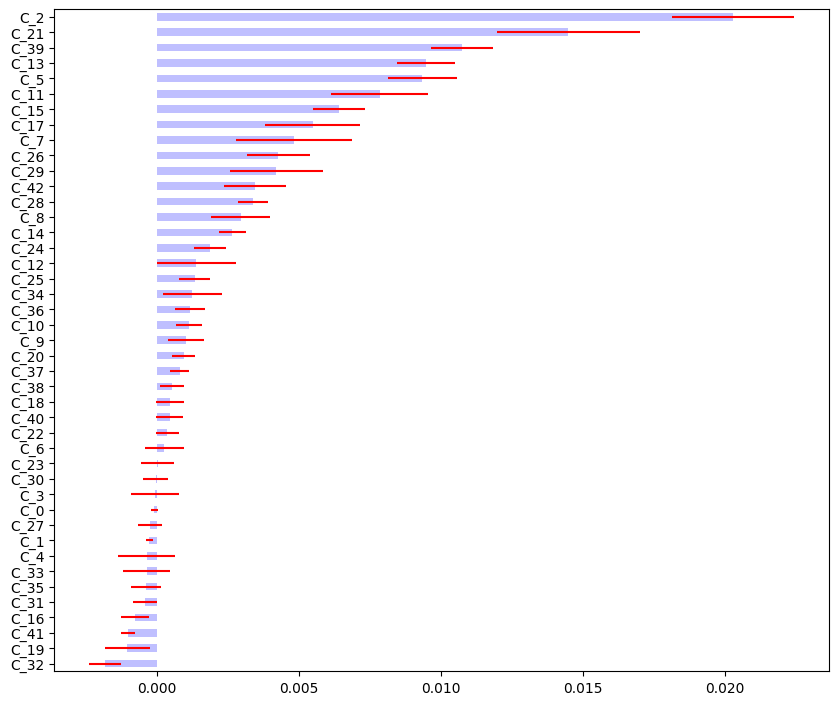

In [23]:
# cMDA importance with clf, sample weights

cpcv_gen = fml.cross_validation.CombinatorialPurgedKFold(n_splits=8, n_test_splits=2, samples_info_sets=triple_barrier_events.loc[X_train.index].t1, pct_embargo=0.01)

clf = DecisionTreeClassifier(
    criterion                = "entropy" , 
    max_features             = 1         , 
    class_weight             = "balanced", 
    min_weight_fraction_leaf = 0
    )
clf = BaggingClassifier(
    base_estimator = clf  , 
    n_estimators   = 1000 , 
    max_features   = 1.   ,
    max_samples    = 1.   , 
    oob_score      = False, 
    n_jobs         = -1
    )

importance = feature_importance_clustered_MDA(
    clf, X_train, y_train, clusters, 
    sample_weight=return_based_sample_weights_meta, 
    scoring="neg_log_loss", 
    cv_gen=cpcv_gen
    )

print(importance.head())

importance.sort_values('mean', inplace=True)
plt.figure(figsize=(10, importance.shape[0] / 5))
importance['mean'].plot(
    kind     = 'barh'           , 
    color    = 'b'              , 
    alpha    = 0.25             , 
    xerr     = importance['std'], 
    error_kw = {'ecolor': 'r'}
    )

In [24]:
# cMDA candidate features
import random

mda_clusters = [
    2,21,39,13,5,11,15
]
cluster_candidate_features = [random.choice(clusters[k]) for k in mda_clusters]
cluster_candidate_features = list(dict.fromkeys(cluster_candidate_features+['side']))
print("cMDA cluster candidate features for meta : ", cluster_candidate_features)

cMDA cluster candidate features for meta :  ['close_sign', 'ma_12', 'm_rsi', 'momentum_2', 'vm_eom', 'vm_fi_50', 'daily_volatility_50', 'side']


In [25]:
parameters = {'max_depth':[2, 3, 4, 5, 7, 15, 20],
              'n_estimators':[10, 25, 50, 100, 256, 512]}

cv_gen_purged = fml.cross_validation.CombinatorialPurgedKFold(n_splits=8, n_test_splits=2, samples_info_sets=triple_barrier_events.loc[X_train.index].t1, pct_embargo=0.01)

def perform_grid_search_sample_weights(X_data, y_data, cv_gen, scoring, type='standard'):
    max_cross_val_score = -np.inf
    top_model = None
    for m_depth in parameters['max_depth']:
        for n_est in parameters['n_estimators']:
            print(f"depth={m_depth} estimators={n_est}")
            clf_base = DecisionTreeClassifier(criterion='entropy', random_state=42, 
                                              max_depth=m_depth, class_weight='balanced')
            if type == 'standard':
                clf = BaggingClassifier(n_estimators=n_est, 
                                        base_estimator=clf_base, 
                                        random_state=42, n_jobs=-1, 
                                        oob_score=False, 
                                        )
            elif type == 'random_forest':
                clf = RandomForestClassifier(n_estimators=n_est, 
                                             max_depth=m_depth, 
                                             random_state=42, 
                                             n_jobs=-1, 
                                             oob_score=False, 
                                            criterion='entropy',
                                            class_weight='balanced_subsample', 
                                            )
            temp_score_base = fml.cross_validation.ml_cross_val_score(clf, X_data, y_data, cv_gen, scoring=scoring,
                                                                    sample_weight_train=return_based_sample_weights_meta.values)
            if temp_score_base.mean() > max_cross_val_score:
                max_cross_val_score = temp_score_base.mean()
                print(temp_score_base.mean())
                top_model = clf
    return top_model, max_cross_val_score


top_model, cross_val_score = perform_grid_search_sample_weights(
    X_train[cluster_candidate_features], y_train, 
    cv_gen_purged, 
    log_loss     ,
    type='random_forest')

top_model

depth=2 estimators=10
-0.6563998585292018
depth=2 estimators=25
-0.6547802290208035
depth=2 estimators=50
depth=2 estimators=100
depth=2 estimators=256
depth=2 estimators=512
depth=3 estimators=10
-0.6480887980107713
depth=3 estimators=25
-0.6458709460389888
depth=3 estimators=50
-0.6458249565653532
depth=3 estimators=100
-0.644793618401853
depth=3 estimators=256
depth=3 estimators=512
-0.6445984293594816
depth=4 estimators=10
-0.6428513300681544
depth=4 estimators=25
-0.639441504996764
depth=4 estimators=50
depth=4 estimators=100
-0.638659063355985
depth=4 estimators=256
-0.638298595905904
depth=4 estimators=512
-0.6381399760608827
depth=5 estimators=10
depth=5 estimators=25
-0.6380201327050635
depth=5 estimators=50
-0.6363043118371995
depth=5 estimators=100
-0.6354234822097904
depth=5 estimators=256
-0.6349359683257016
depth=5 estimators=512
-0.6346601610106882
depth=7 estimators=10
depth=7 estimators=25
depth=7 estimators=50
depth=7 estimators=100
-0.6339284242236652
depth=7 estimat

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=7, n_estimators=512, n_jobs=-1,
                       random_state=42)

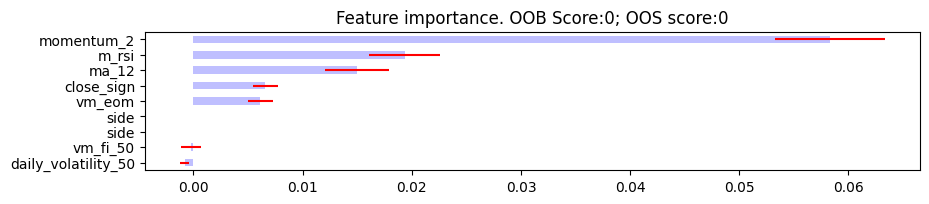

In [26]:
# about to sort candidate features for meta model
from mlfinlab.feature_importance import mean_decrease_accuracy, mean_decrease_impurity, single_feature_importance, plot_feature_importance

mda_feat_imp = mean_decrease_accuracy(top_model, X_train[cluster_candidate_features], y_train, cv_gen_purged, 
    scoring=log_loss, 
    sample_weight_train=return_based_sample_weights_meta.values)

plot_feature_importance(mda_feat_imp, 0, 0)

In [27]:
mda_feat_imp['mean_plus_std'] = mda_feat_imp['mean']+mda_feat_imp['std']

In [28]:
importance_df = mda_feat_imp.copy()
importance_df.sort_values('mean_plus_std', ascending=True, inplace=True)

importance_df

,mean,std,mean_plus_std
daily_volatility_50,-7.976964e-04,4.316012e-04,-3.660952e-04
side,6.644766e-19,1.779146e-17,1.845594e-17
side,6.644766e-19,1.779146e-17,1.845594e-17
vm_fi_50,-2.052887e-04,9.074919e-04,7.022032e-04
vm_eom,6.120025e-03,1.132268e-03,7.252292e-03
close_sign,6.572987e-03,1.157165e-03,7.730152e-03
ma_12,1.498873e-02,2.959459e-03,1.794819e-02
m_rsi,1.934081e-02,3.253648e-03,2.259446e-02
momentum_2,5.828254e-02,5.030445e-03,6.331298e-02


In [29]:
importance_threshold = 0.01
selected_cmda_features = list(importance_df[importance_df['mean_plus_std']>importance_threshold].index)
print(selected_cmda_features)

['ma_12', 'm_rsi', 'momentum_2']


In [30]:
importance_threshold = 0.0
selected_cmda_features = list(importance_df[importance_df['mean']>importance_threshold].index)

print(selected_cmda_features)

['side', 'side', 'vm_eom', 'close_sign', 'ma_12', 'm_rsi', 'momentum_2']


In [31]:
selected_cmda_features = ['vm_eom', 'close_sign', 'ma_12', 'm_rsi', 'momentum_2']

In [32]:
# parameter search

parameters = {'max_depth':[2, 5, 7, 9, 15, 30, 45, 50],
              'n_estimators':[10, 25, 50, 100, 256, 512, 718, 1024]}

cv_gen_purged = fml.cross_validation.CombinatorialPurgedKFold(n_splits=8, n_test_splits=2, samples_info_sets=triple_barrier_events.loc[X_train.index].t1, pct_embargo=0.01)

def perform_grid_search_sample_weights(X_data, y_data, cv_gen, scoring, type='standard'):
    max_cross_val_score = -np.inf
    top_model = None
    for m_depth in parameters['max_depth']:
        for n_est in parameters['n_estimators']:
            print(f"depth={m_depth} estimators={n_est}")
            clf_base = DecisionTreeClassifier(criterion='entropy', random_state=42, 
                                              max_depth=m_depth, class_weight='balanced')
            if type == 'standard':
                clf = BaggingClassifier(n_estimators=n_est, 
                                        base_estimator=clf_base, 
                                        random_state=42, n_jobs=-1, 
                                        oob_score=False, 
                                        )
            elif type == 'random_forest':
                clf = RandomForestClassifier(n_estimators=n_est, 
                                             max_depth=m_depth, 
                                             random_state=42, 
                                             n_jobs=-1, 
                                             oob_score=False, 
                                            criterion='entropy',
                                            class_weight='balanced_subsample', 
                                            )
            temp_score_base = fml.cross_validation.ml_cross_val_score(clf, X_data, y_data, cv_gen, scoring=scoring,
                                                                    sample_weight_train=return_based_sample_weights_meta.values)
            if temp_score_base.mean() > max_cross_val_score:
                max_cross_val_score = temp_score_base.mean()
                print(temp_score_base.mean())
                top_model = clf
    return top_model, max_cross_val_score


top_model, cross_val_score = perform_grid_search_sample_weights(
    X_train[selected_cmda_features], y_train, 
    cv_gen_purged, 
    log_loss,
    type='random_forest')

top_model

depth=2 estimators=10
-0.6559333254499581
depth=2 estimators=25
-0.6504840374694691
depth=2 estimators=50
-0.6503831797572259
depth=2 estimators=100
depth=2 estimators=256
depth=2 estimators=512
depth=2 estimators=718
depth=2 estimators=1024
depth=5 estimators=10
-0.6401520303023328
depth=5 estimators=25
-0.6344380098627733
depth=5 estimators=50
-0.6330709077135246
depth=5 estimators=100
-0.632843403583057
depth=5 estimators=256
-0.6326149348255764
depth=5 estimators=512
-0.6325156524427789
depth=5 estimators=718
depth=5 estimators=1024
depth=7 estimators=10
depth=7 estimators=25
depth=7 estimators=50
depth=7 estimators=100
-0.6324462792060987
depth=7 estimators=256
-0.6320548316759826
depth=7 estimators=512
depth=7 estimators=718
depth=7 estimators=1024
depth=9 estimators=10
depth=9 estimators=25
depth=9 estimators=50
depth=9 estimators=100
depth=9 estimators=256
depth=9 estimators=512
depth=9 estimators=718
depth=9 estimators=1024
depth=15 estimators=10
depth=15 estimators=25
depth=1

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=7, n_estimators=256, n_jobs=-1,
                       random_state=42)

              precision    recall  f1-score   support

           0       0.62      0.81      0.70       435
           1       0.37      0.18      0.24       268

    accuracy                           0.57       703
   macro avg       0.49      0.49      0.47       703
weighted avg       0.52      0.57      0.53       703



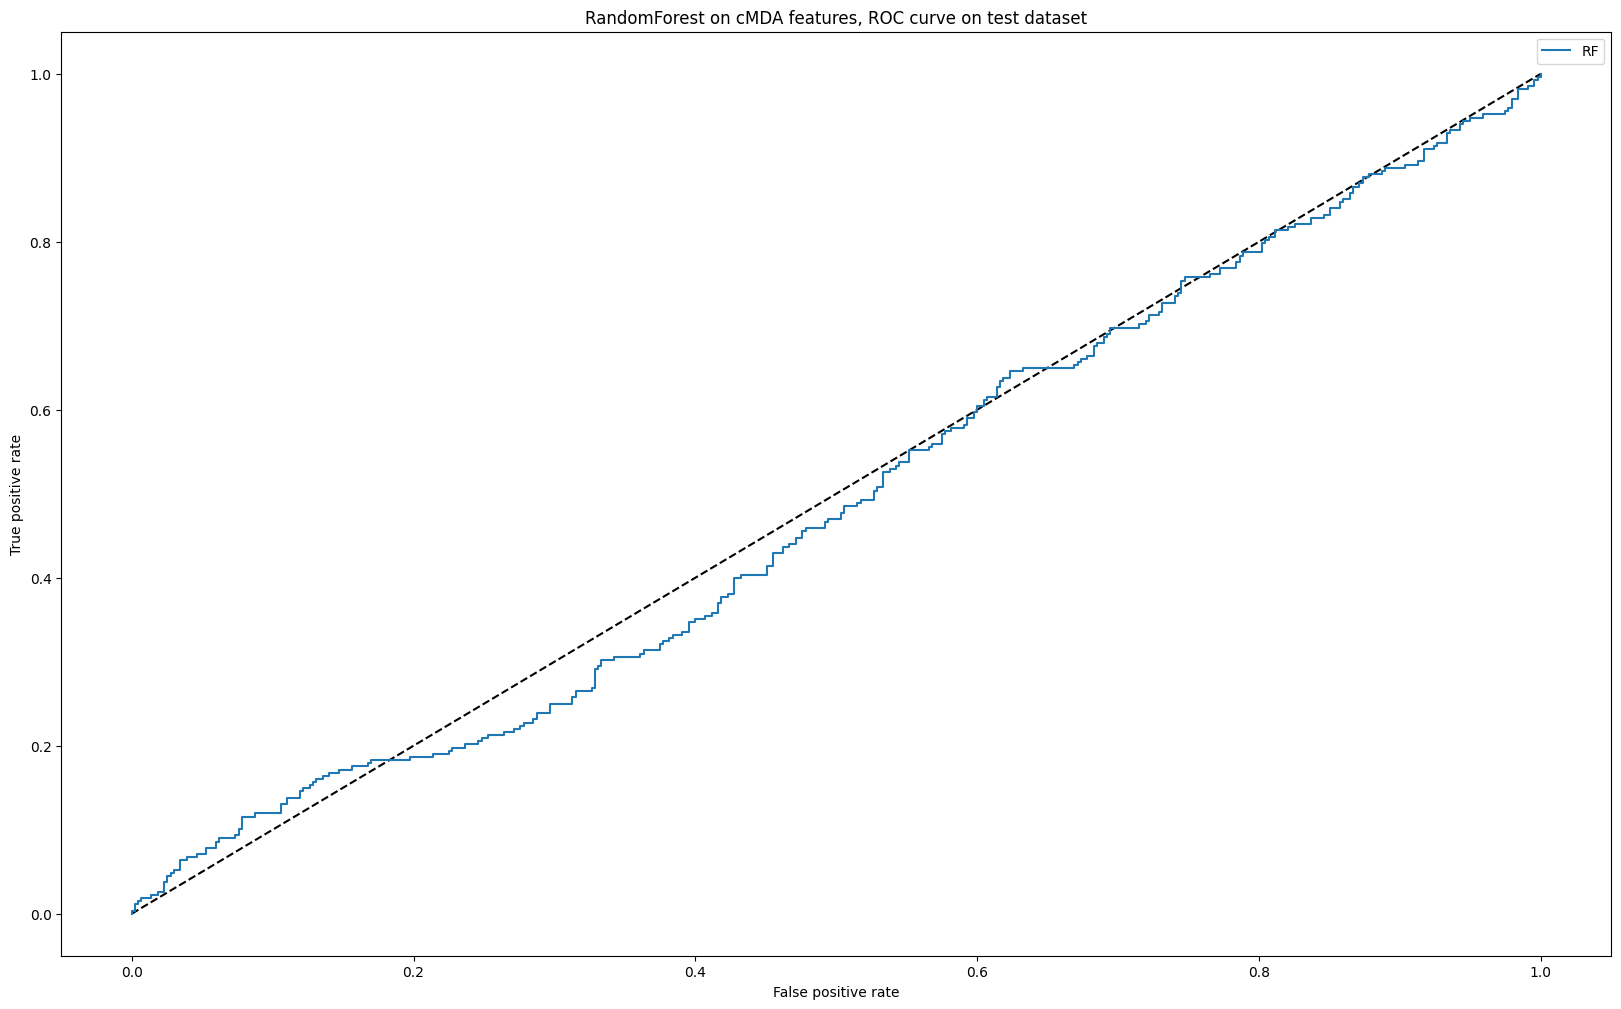

In [33]:
print(classification_report(
    y_test,
    top_model.predict(X_test[selected_cmda_features]),
    ))

fpr_rf, tpr_rf, _ = roc_curve(y_test, top_model.predict_proba(X_test[selected_cmda_features])[:, 1])
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('RandomForest on cMDA features, ROC curve on test dataset')
plt.legend(loc='best')
plt.show()

In [34]:
selected_cmda_features

['vm_eom', 'close_sign', 'ma_12', 'm_rsi', 'momentum_2']

              precision    recall  f1-score   support

           0       0.61      0.82      0.70       435
           1       0.34      0.16      0.22       268

    accuracy                           0.56       703
   macro avg       0.48      0.49      0.46       703
weighted avg       0.51      0.56      0.51       703



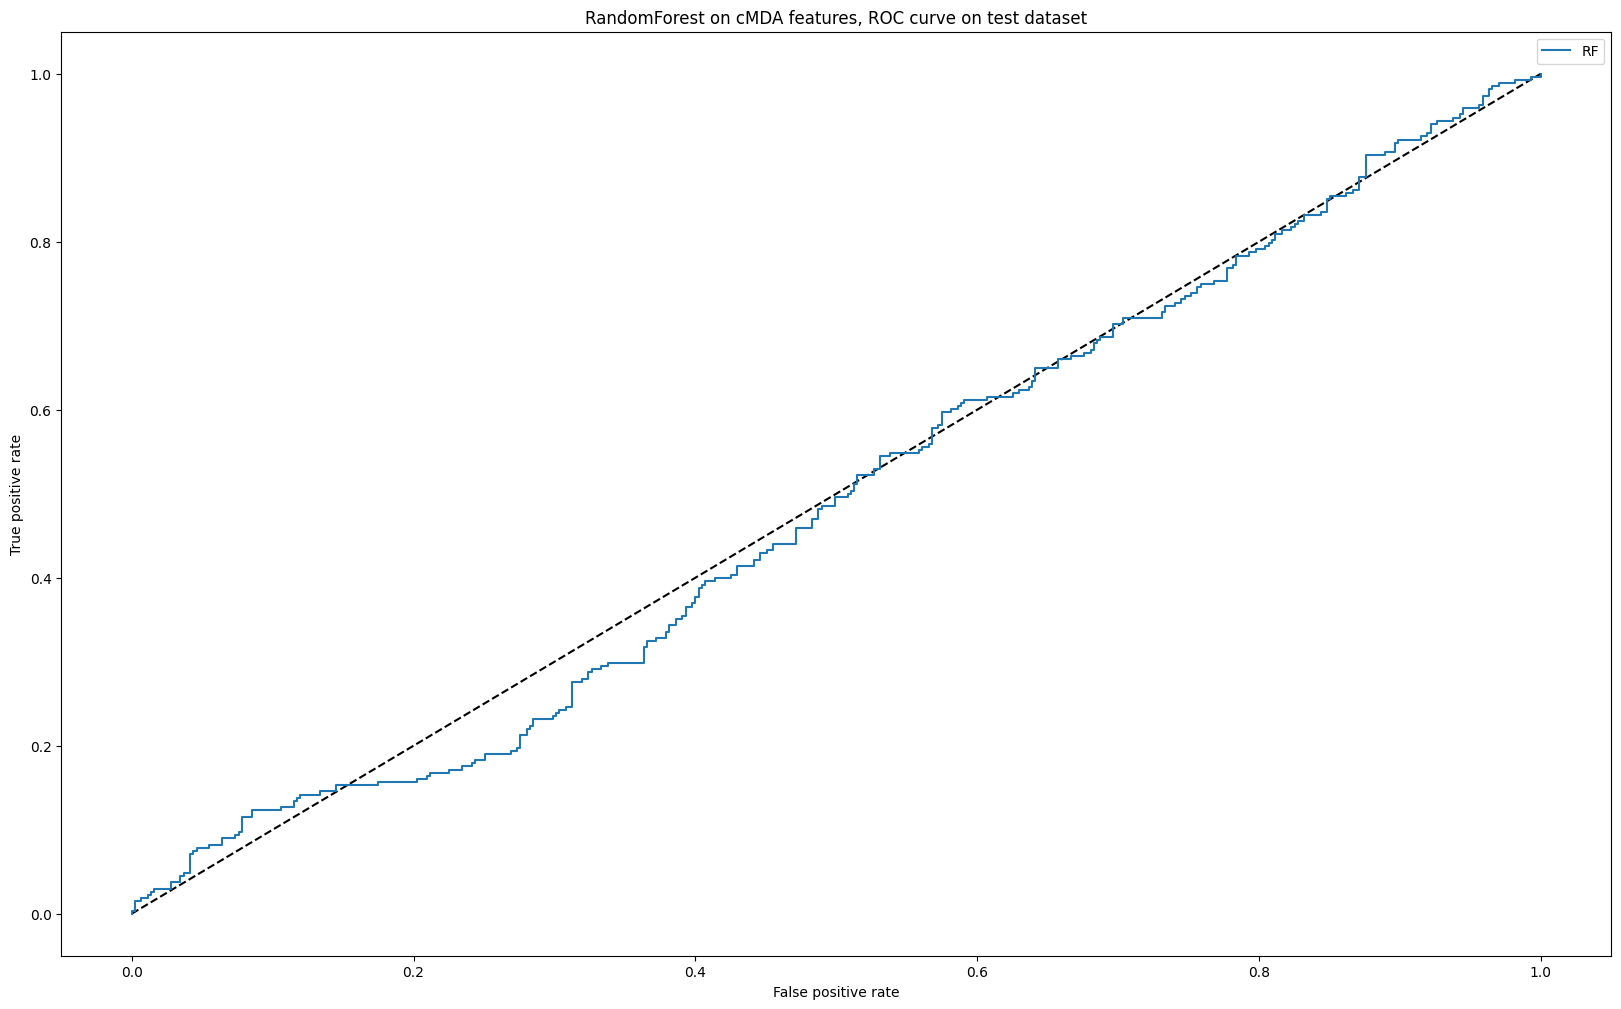

In [35]:
rf_meta = RandomForestClassifier(
    max_depth     = 7, 
    n_estimators  = 256,
    criterion     = 'entropy', 
    class_weight  = 'balanced_subsample',
    random_state  = 42,
    n_jobs        = -1
    )

rf_meta.fit(
    X_train[selected_cmda_features], 
    y_train,
    sample_weight=return_based_sample_weights_meta,
    )

print(classification_report(
    y_test,
    rf_meta.predict(X_test[selected_cmda_features]),
    ))

fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_meta.predict_proba(X_test[selected_cmda_features])[:, 1])
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('RandomForest on cMDA features, ROC curve on test dataset')
plt.legend(loc='best')
plt.show()

In [36]:
import os
import pickle
import joblib

os.makedirs("../model/", exist_ok=True)

In [37]:
# saving trained model
joblib.dump(top_model, "../model/btcusdt_rf_size.save")

['../model/btcusdt_rf_size.save']

In [38]:
features_string = " ".join(selected_cmda_features)
print(features_string)

with open("../model/features_size.txt", "w") as f:
    f.write(features_string)

vm_eom close_sign ma_12 m_rsi momentum_2


In [39]:
loaded_rf = joblib.load("../model/btcusdt_rf_size.save")

loaded_rf

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=7, n_estimators=256, n_jobs=-1,
                       random_state=42)

In [40]:
side_features = []
meta_features = []
size_features = []

with open("../model/features_side.txt", "r") as f:
    side_features = f.readlines()[0].strip().split()
with open("../model/features_meta.txt", "r") as f:
    meta_features = f.readlines()[0].strip().split()
with open("../model/features_size.txt", "r") as f:
    size_features = f.readlines()[0].strip().split()

print(f"side features : {side_features}")
print(f"meta features : {meta_features}")
print(f"size features : {size_features}")

side_rf = joblib.load("../model/btcusdt_rf_side.save")
meta_rf = joblib.load("../model/btcusdt_rf_meta.save")
size_rf = joblib.load("../model/btcusdt_rf_size.save")

print(side_rf)
print(meta_rf)
print(size_rf)

side features : ['ma_440', 'daily_volatility_30', 'vm_eom_25', 'vl_atr_180', 'vm_cmf_180']
meta features : ['vl_bbp', 't_adx_90', 'close_plus_minus_40']
size features : ['vm_eom', 'close_sign', 'ma_12', 'm_rsi', 'momentum_2']
RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=30, n_estimators=512, n_jobs=-1,
                       random_state=42)
RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=30, n_estimators=512, n_jobs=-1,
                       random_state=42)
RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=7, n_estimators=256, n_jobs=-1,
                       random_state=42)


In [41]:
eval_features = side_features+meta_features+size_features+['Open', 'High', 'Low', 'Close', 'Volume', 'volatility_tpsl_600']
eval_features = list(dict.fromkeys(eval_features))

eval_features

['ma_440',
 'daily_volatility_30',
 'vm_eom_25',
 'vl_atr_180',
 'vm_cmf_180',
 'vl_bbp',
 't_adx_90',
 'close_plus_minus_40',
 'vm_eom',
 'close_sign',
 'ma_12',
 'm_rsi',
 'momentum_2',
 'Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'volatility_tpsl_600']

In [42]:
eval_df = df["2022-01-14":][eval_features].copy()
eval_df

,ma_440,daily_volatility_30,vm_eom_25,vl_atr_180,vm_cmf_180,vl_bbp,t_adx_90,close_plus_minus_40,vm_eom,close_sign,ma_12,m_rsi,momentum_2,Open,High,Low,Close,Volume,volatility_tpsl_600
timestamp,,,,,,,,,,,,,,,,,,,
2022-01-14 00:00:00,-0.003425,0.000999,6.157429e+09,43.534959,0.034662,0.511889,8.786168,0.0,6.157429e+09,1.0,0.000763,50.444983,0.001510,42558.35,42603.33,42548.26,42600.08,18.40607,0.016942
2022-01-14 00:01:00,-0.004554,0.000970,1.699927e+09,43.683487,0.022891,0.295881,8.793881,-2.0,1.699927e+09,-1.0,-0.000235,42.936225,-0.000235,42600.08,42614.88,42544.61,42550.10,16.32814,0.016930
2022-01-14 00:02:00,-0.007208,0.001301,-1.416898e+10,44.094301,0.000420,-0.105548,8.860483,-4.0,-1.416898e+10,-1.0,-0.002544,31.330195,-0.003884,42550.10,42550.10,42432.47,42434.60,73.43893,0.016930
2022-01-14 00:03:00,-0.007990,0.001796,-1.349765e+10,44.369499,0.005315,-0.107642,8.953097,-6.0,-1.349765e+10,-1.0,-0.002984,28.749227,-0.003552,42434.61,42471.11,42377.48,42398.98,46.46937,0.016936
2022-01-14 00:04:00,-0.007405,0.002144,-5.675909e+09,44.559057,0.011602,0.037604,9.051596,-4.0,-5.675909e+09,1.0,-0.002140,32.590602,-0.000300,42398.99,42441.40,42362.91,42421.86,30.61657,0.016942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-30 23:55:00,0.010258,0.001883,6.892347e+07,17.238777,0.004436,0.236342,21.611949,2.0,6.892347e+07,-1.0,-0.001376,46.137493,-0.001387,17175.50,17215.59,17170.01,17173.33,531.36517,0.007241
2022-11-30 23:56:00,0.009856,0.001821,-2.279030e+08,17.280228,0.007083,0.139843,21.597760,0.0,-2.279030e+08,-1.0,-0.001469,43.956738,-0.000424,17173.33,17175.40,17150.70,17167.16,322.42878,0.007255
2022-11-30 23:57:00,0.009470,0.001766,6.424704e+06,17.262172,0.004526,0.033636,21.583728,0.0,6.424704e+06,-1.0,-0.001560,41.916461,-0.000703,17165.50,17170.80,17156.77,17161.26,160.50623,0.007266


In [43]:
eval_df['position'  ] = side_rf.predict(eval_df[side_features])
eval_df['short_prob'] = side_rf.predict_proba(eval_df[side_features])[:,0]
eval_df['long_prob' ] = side_rf.predict_proba(eval_df[side_features])[:,1]

In [44]:
eval_df['position'].value_counts()

 1.0    264815
-1.0    197425
Name: position, dtype: int64

<AxesSubplot: >

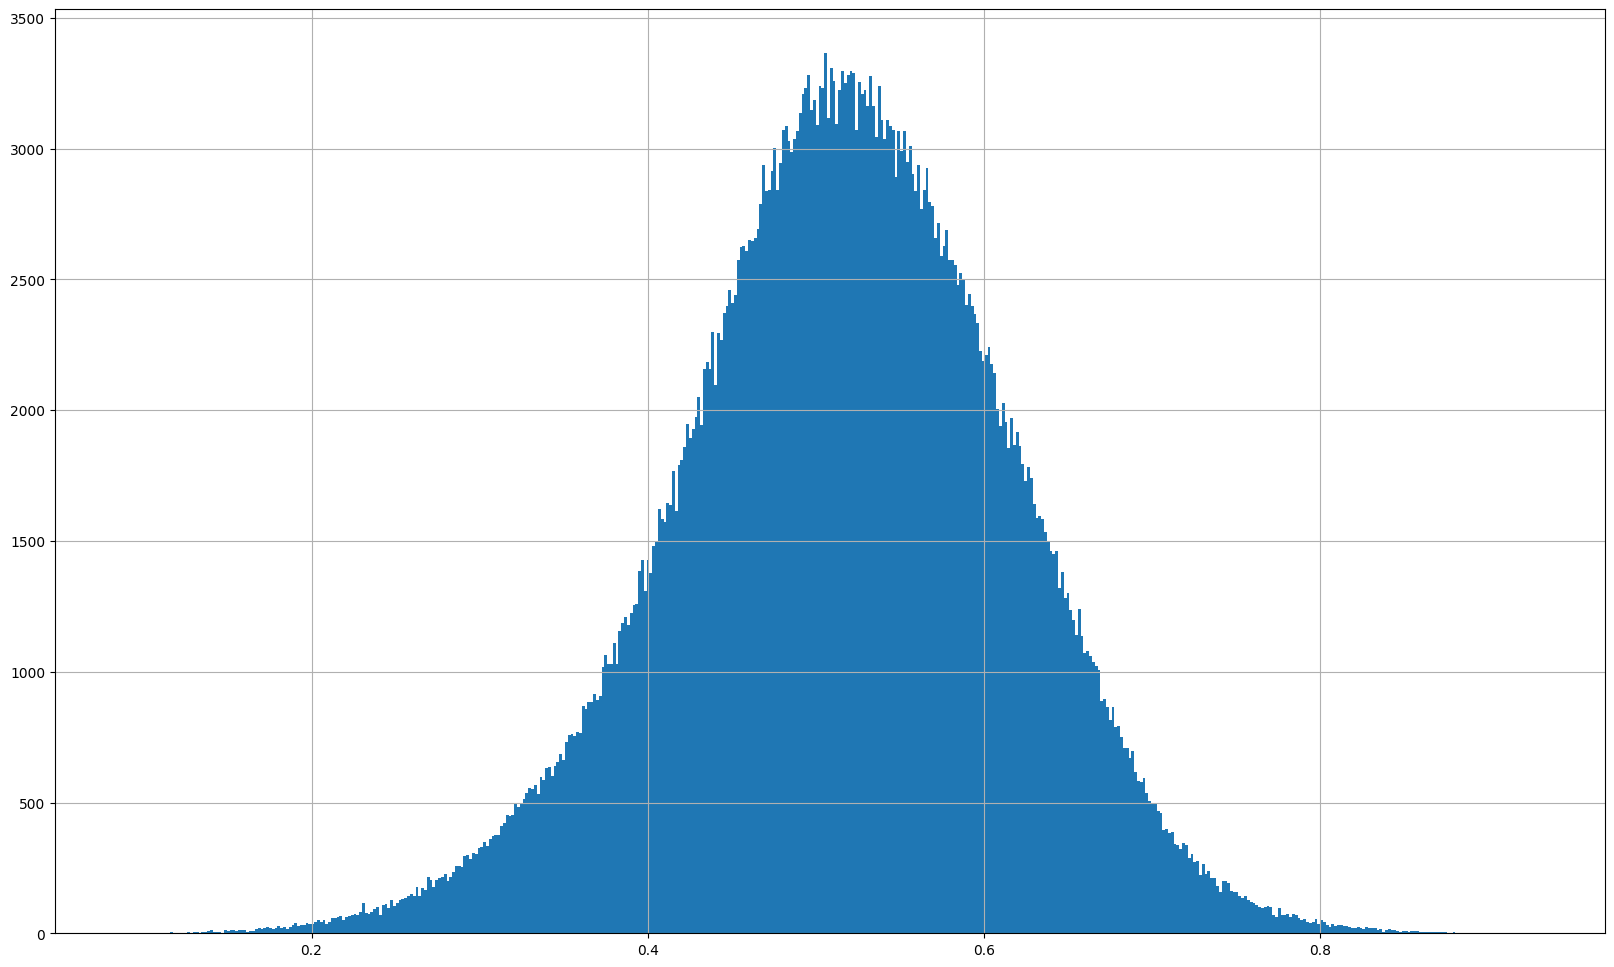

In [45]:
eval_df['long_prob'].hist(bins=500)

<AxesSubplot: >

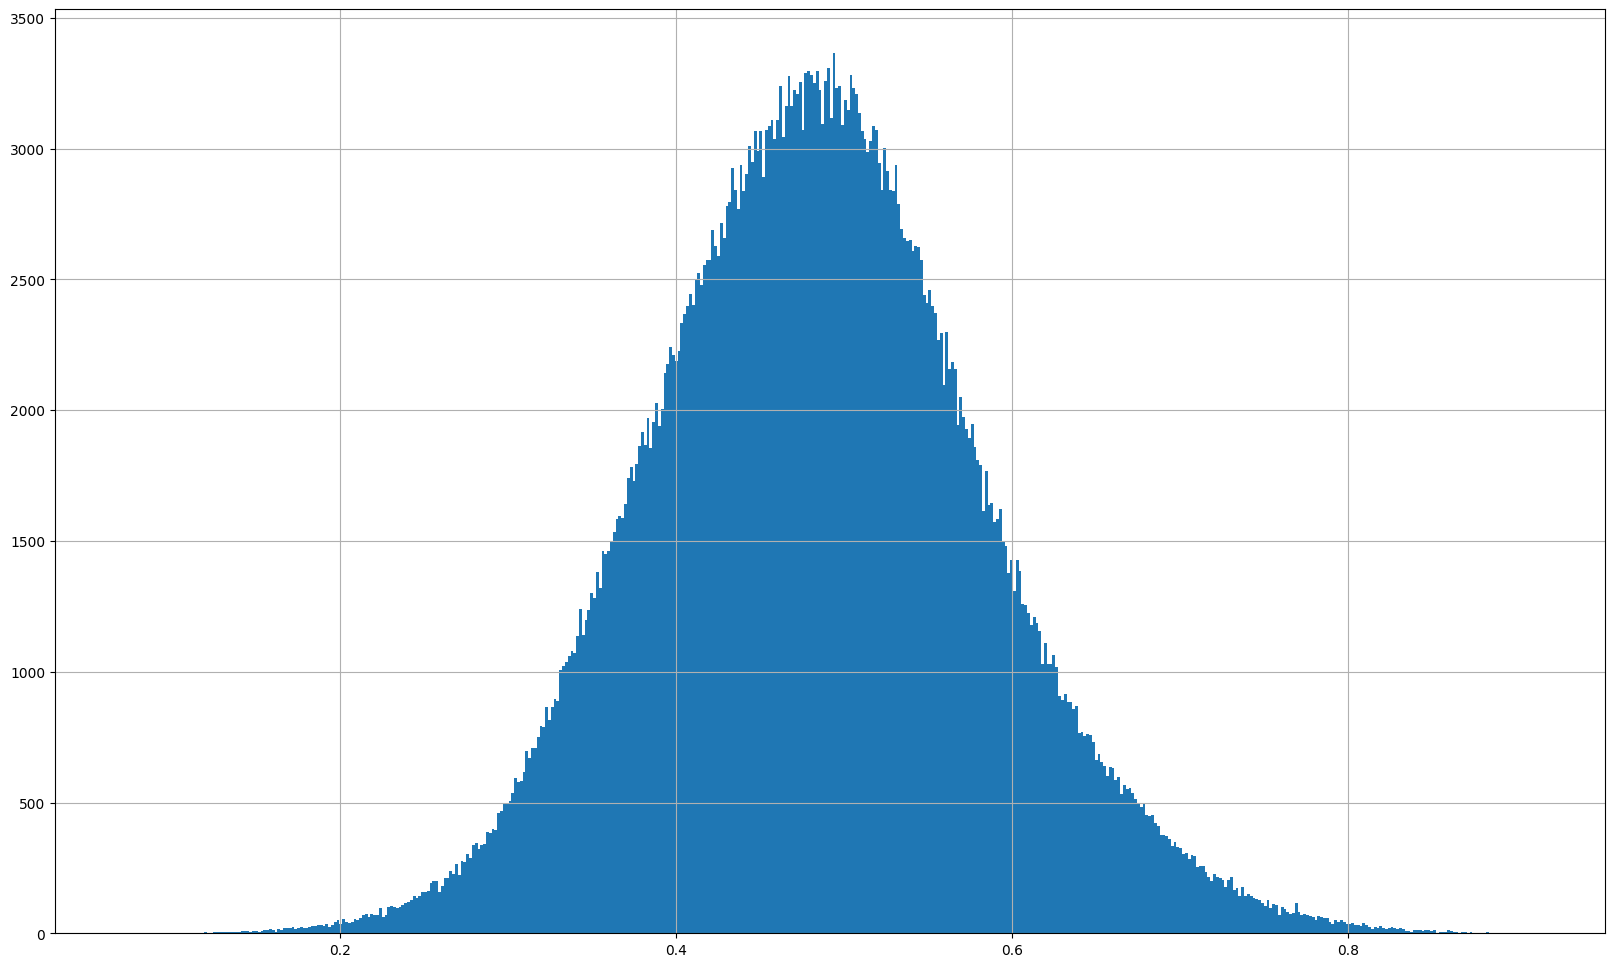

In [46]:
eval_df['short_prob'].hist(bins=500)

In [47]:
primary_threshold = 0.65

eval_df['is_signal'] = False
eval_df.loc[(eval_df['short_prob']>=primary_threshold)|(eval_df['long_prob']>=primary_threshold), 'is_signal'] = True

In [48]:
eval_df[eval_df['is_signal']==True]['position'].value_counts()

 1.0    38145
-1.0    23968
Name: position, dtype: int64

In [49]:
signal_indexes = eval_df[eval_df['is_signal']==True].index
eval_df['meta_act'] = 0
eval_df.loc[signal_indexes, 'meta_act'     ] = meta_rf.predict(eval_df.loc[signal_indexes][meta_features])
eval_df.loc[signal_indexes, 'meta_act_prob'] = meta_rf.predict_proba(eval_df.loc[signal_indexes][meta_features])[:,1]

In [50]:
eval_df['meta_act'].value_counts()

0    426736
1     35504
Name: meta_act, dtype: int64

<AxesSubplot: >

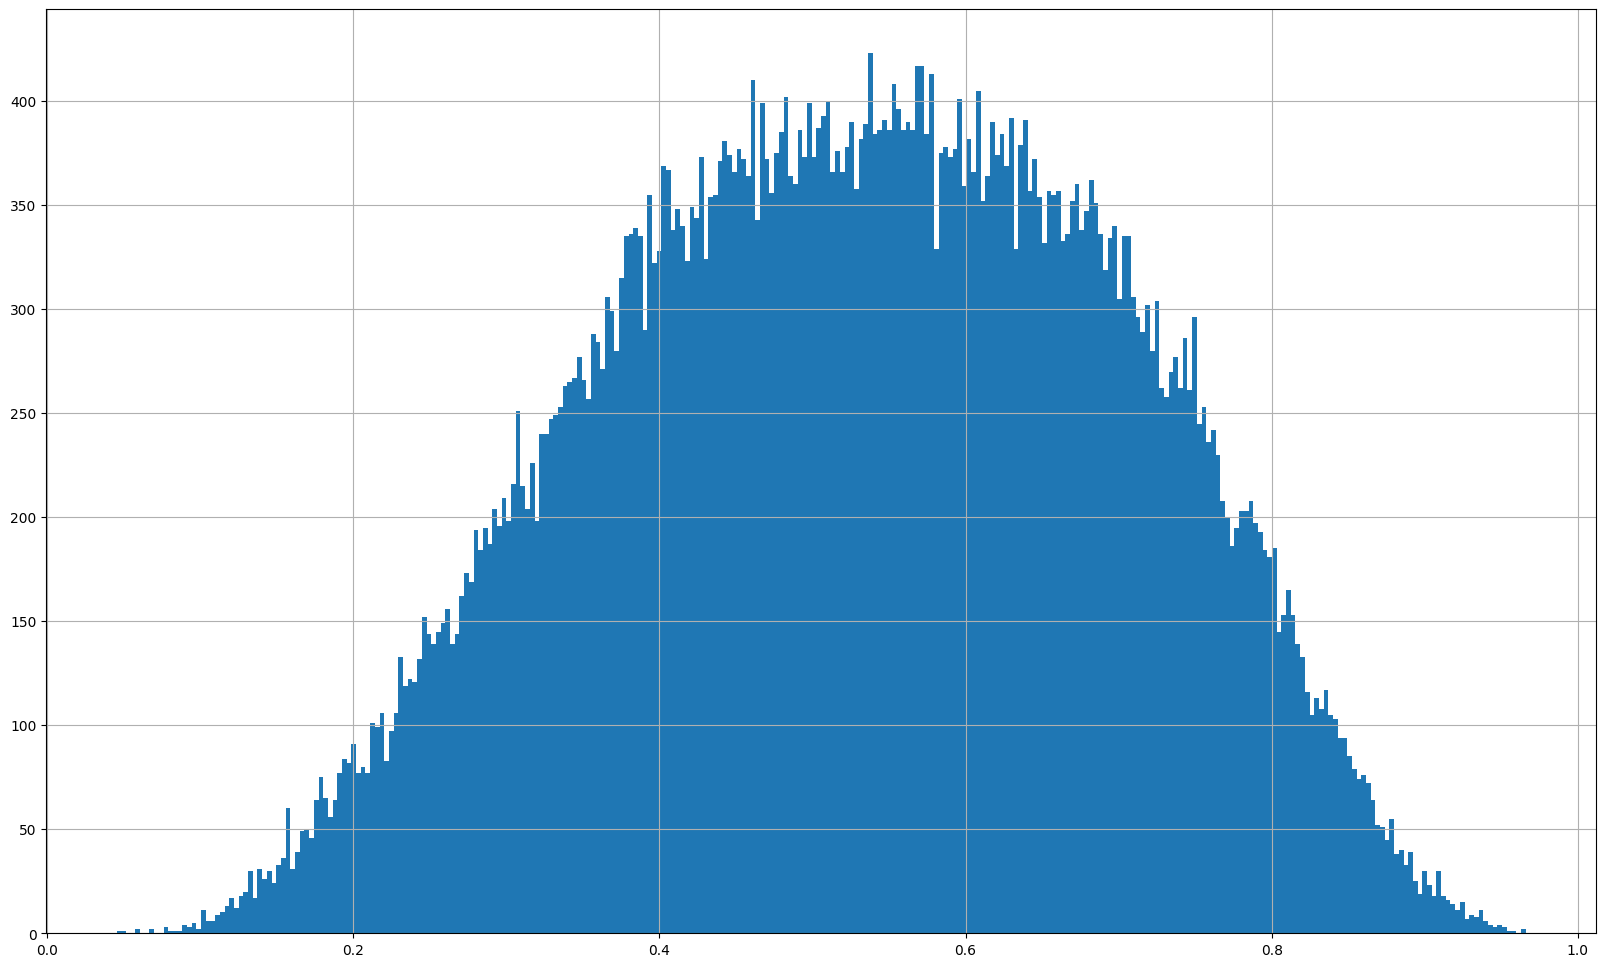

In [51]:
eval_df['meta_act_prob'].hist(bins=300)

In [52]:
meta_threshold = 0.55
eval_df['is_meta_signal'] = False
eval_df.loc[eval_df['meta_act_prob']>=meta_threshold, 'is_meta_signal'] = True

In [53]:
meta_signal_indexes = eval_df[eval_df['is_meta_signal']==True].index

In [54]:
eval_df.loc[meta_signal_indexes, 'size_prob'] = size_rf.predict_proba(eval_df.loc[meta_signal_indexes][size_features])[:,1]

<AxesSubplot: >

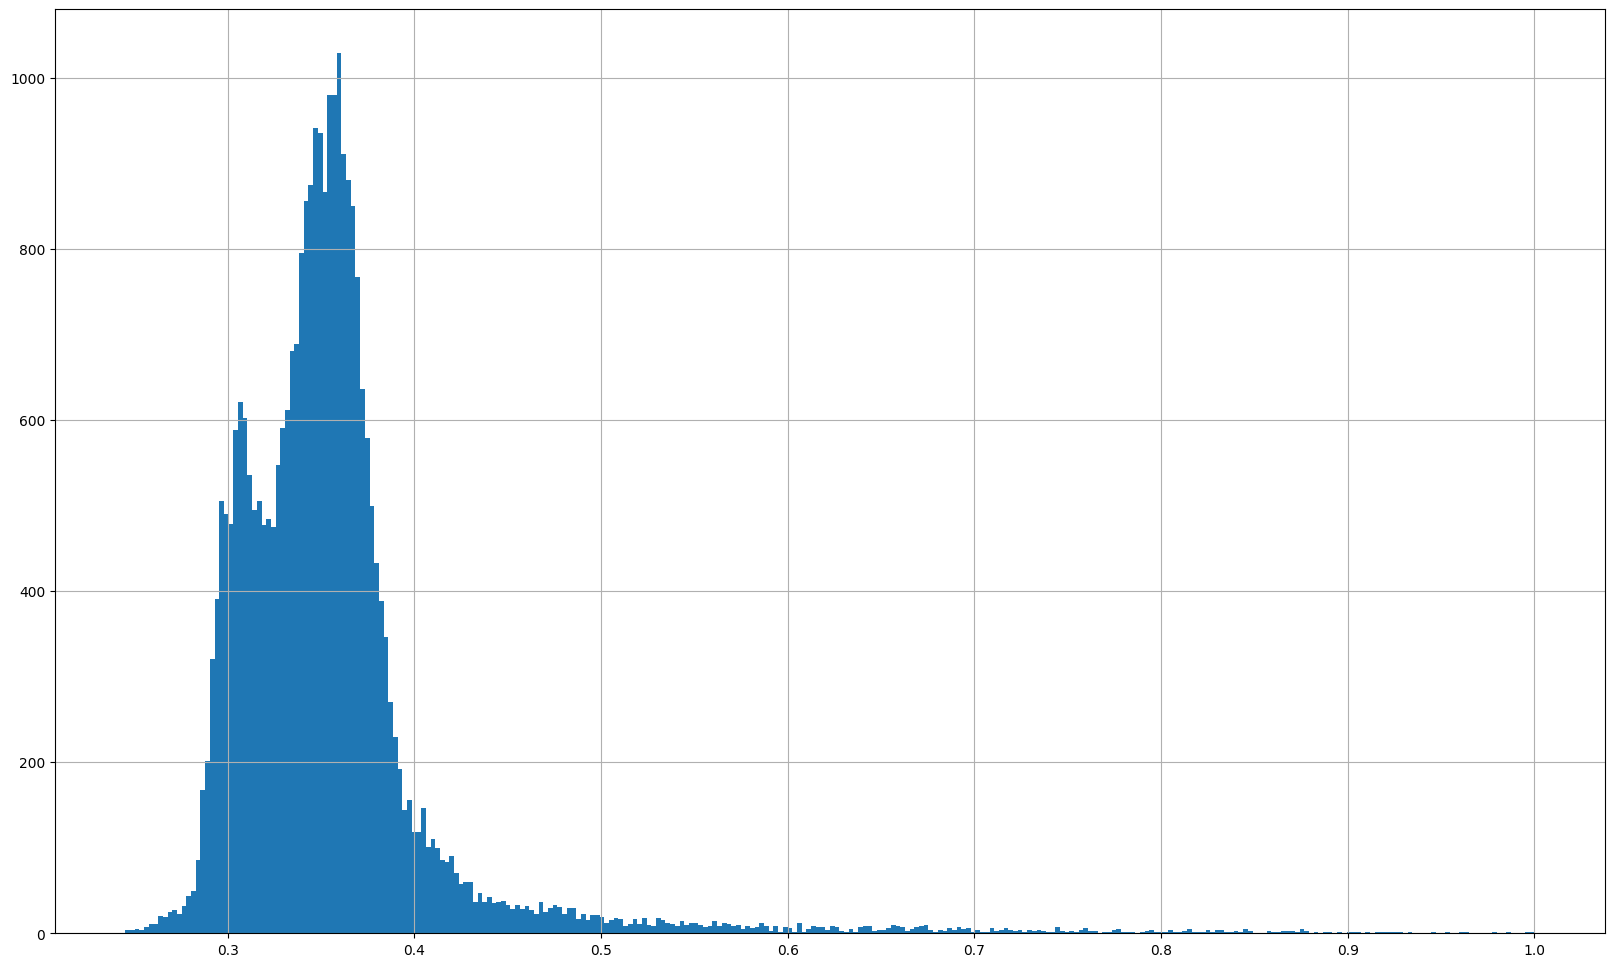

In [55]:
eval_df['size_prob'].hist(bins=300)

In [56]:
from backtesting     import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.lib import resample_apply

def SMA(array, n):
    return pd.Series(array).rolling(n).mean()

def kelly(prob_win, payout_perc):
    return (prob_win * payout_perc - (1 - prob_win)) / payout_perc

binance_commission = 0.0004  # Taker Fee rate is 0.04%

In [61]:
meta_threshold = 0.55
size_threshold = 0.55

class MetaStrategy(Strategy):
    def init(self):
        super().init()
    def next(self):
        super().next()

        available_to_trade = True
        if len(self.trades)>=1:
            available_to_trade = False
        if not available_to_trade:
            return

        close_price     = self.data.Close[-1]
        volatility_tpsl = self.data.volatility_tpsl_600[-1]
        position        = self.data.position[-1]
        meta_act_prob   = self.data.meta_act_prob[-1]
        size_prob       = self.data.size_prob[-1]

        size=0.1

        if position==1 and meta_act_prob>=meta_threshold and size_prob>=size_threshold:
            ret_upper = np.exp(round((volatility_tpsl*long_ptsl[0]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*long_ptsl[1]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_tp = close_price+delta_upper
            price_sl = close_price-delta_lower
            self.buy(size=size, sl=price_sl, tp=price_tp)

        if position==-1 and meta_act_prob>=meta_threshold and size_prob>=size_threshold:
            ret_upper = np.exp(round((volatility_tpsl*short_ptsl[1]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*short_ptsl[0]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_sl = close_price+delta_upper
            price_tp = close_price-delta_lower
            self.sell(size=size, sl=price_sl, tp=price_tp)

bt = Backtest(
    eval_df, 
    MetaStrategy, 
    cash             = 100000000, 
    commission       = binance_commission, 
    exclusive_orders = True
    )

stats = bt.run()
stats

Start                     2022-01-14 00:00:00
End                       2022-11-30 23:59:00
Duration                    320 days 23:59:00
Exposure Time [%]                   44.841641
Equity Final [$]              96478591.298746
Equity Peak [$]              101060100.071649
Return [%]                          -3.521409
Buy & Hold Return [%]              -59.709841
Return (Ann.) [%]                   -3.994331
Volatility (Ann.) [%]                4.672949
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -7.024884
Avg. Drawdown [%]                   -0.361524
Max. Drawdown Duration      312 days 12:11:00
Avg. Drawdown Duration       13 days 01:37:00
# Trades                                  269
Win Rate [%]                        34.572491
Best Trade [%]                       7.930082
Worst Trade [%]                     -7.141878
Avg. Trade [%]                    

Start date,2022-01-20
End date,2022-11-30
Total months,12
,Backtest
Annual return,-34.2%
Cumulative returns,-36.0%
Annual volatility,42.9%
Sharpe ratio,-0.76
Calmar ratio,-0.65
Stability,0.63
Max drawdown,-52.9%


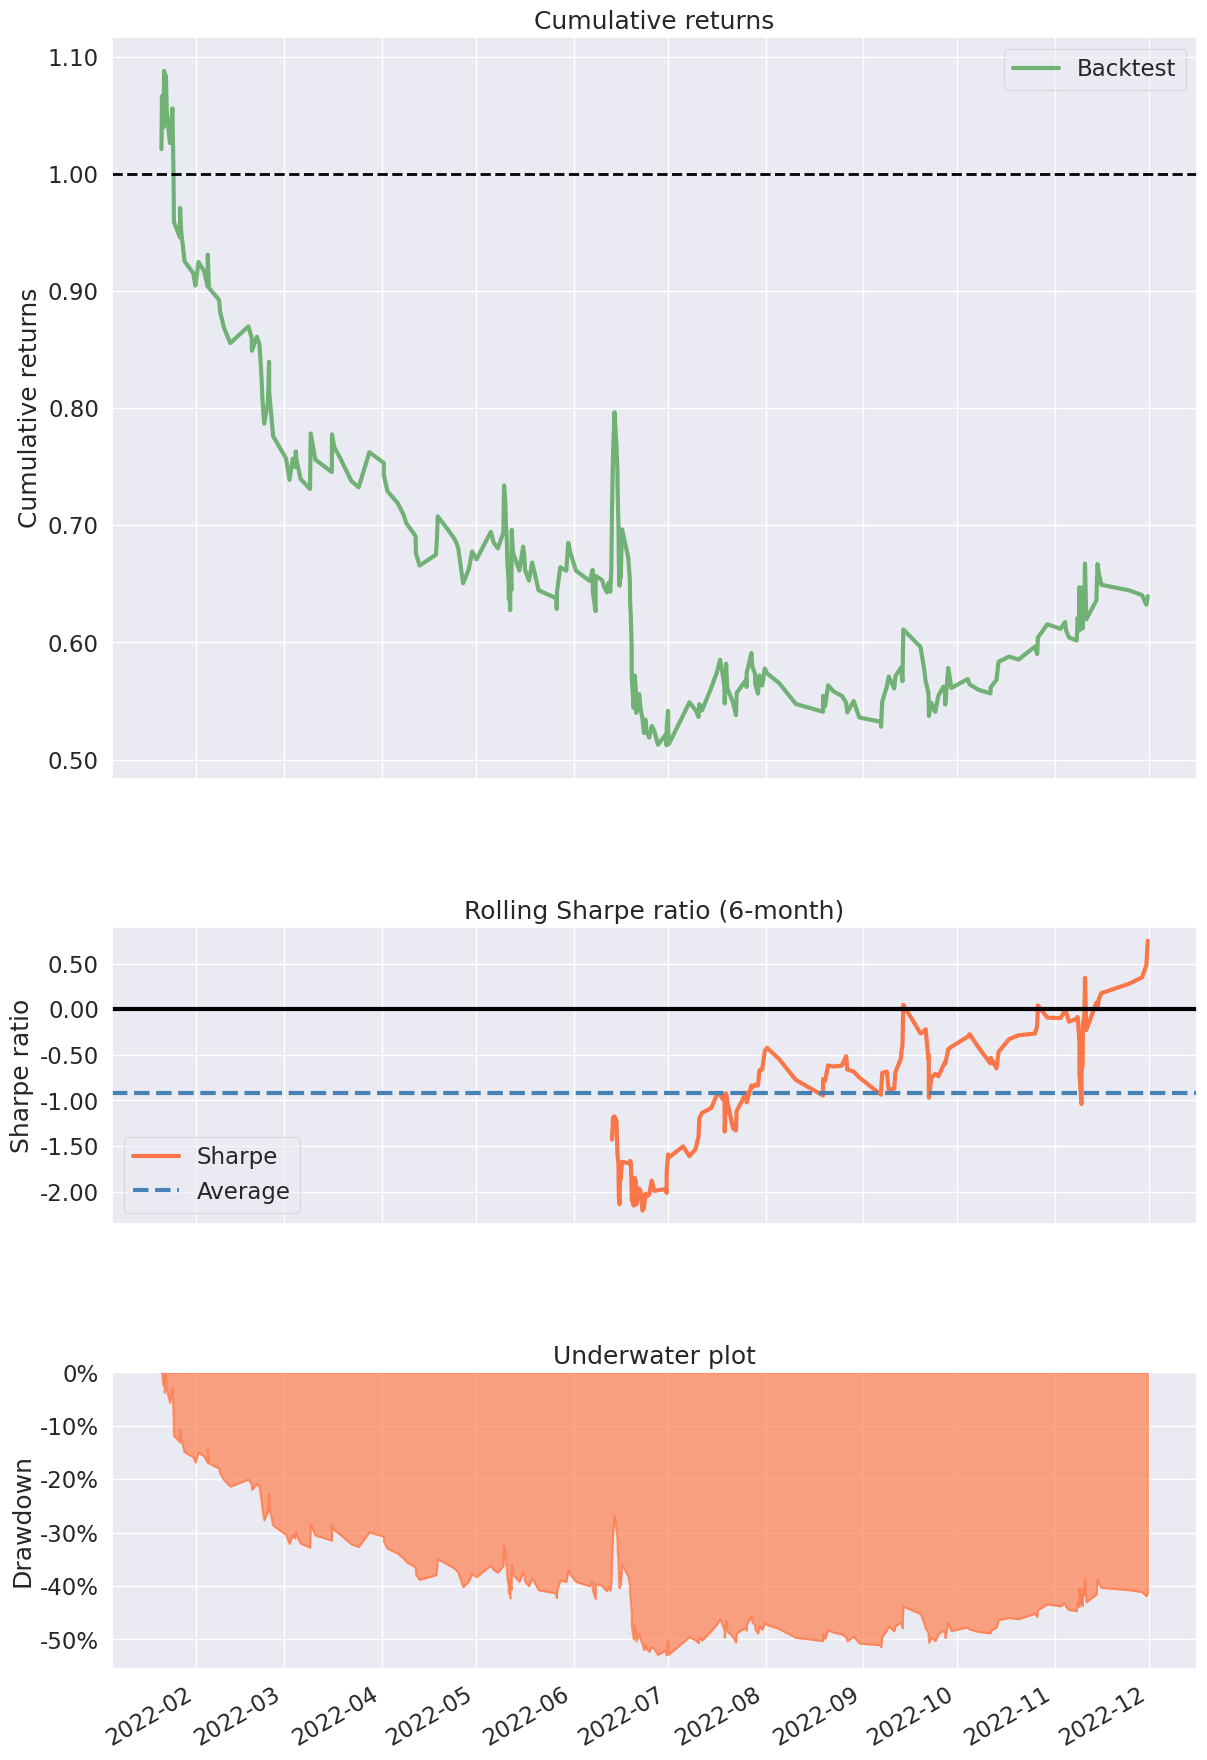

In [62]:
stats_df = stats['_trades'][['ReturnPct', 'EntryTime']]
stats_df = stats_df.set_index('EntryTime')

pf.create_simple_tear_sheet(stats_df['ReturnPct'])

In [63]:
meta_threshold = 0.55
size_threshold = 0.6

class MetaStrategy(Strategy):
    def init(self):
        super().init()
    def next(self):
        super().next()

        available_to_trade = True
        if len(self.trades)>=1:
            available_to_trade = False
        if not available_to_trade:
            return

        close_price     = self.data.Close[-1]
        volatility_tpsl = self.data.volatility_tpsl_600[-1]
        position        = self.data.position[-1]
        meta_act_prob   = self.data.meta_act_prob[-1]
        size_prob       = self.data.size_prob[-1]

        size=0.1

        if position==1 and meta_act_prob>=meta_threshold and size_prob>=size_threshold:
            ret_upper = np.exp(round((volatility_tpsl*long_ptsl[0]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*long_ptsl[1]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_tp = close_price+delta_upper
            price_sl = close_price-delta_lower
            self.buy(size=size, sl=price_sl, tp=price_tp)

        if position==-1 and meta_act_prob>=meta_threshold and size_prob>=size_threshold:
            ret_upper = np.exp(round((volatility_tpsl*short_ptsl[1]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*short_ptsl[0]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_sl = close_price+delta_upper
            price_tp = close_price-delta_lower
            self.sell(size=size, sl=price_sl, tp=price_tp)

bt = Backtest(
    eval_df, 
    MetaStrategy, 
    cash             = 100000000, 
    commission       = binance_commission, 
    exclusive_orders = True
    )

stats = bt.run()
stats

Start                     2022-01-14 00:00:00
End                       2022-11-30 23:59:00
Duration                    320 days 23:59:00
Exposure Time [%]                   36.558065
Equity Final [$]              99949845.309569
Equity Peak [$]              102276242.185655
Return [%]                          -0.050155
Buy & Hold Return [%]              -59.709841
Return (Ann.) [%]                   -0.057028
Volatility (Ann.) [%]                4.408374
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                    -4.17998
Avg. Drawdown [%]                   -0.197031
Max. Drawdown Duration      169 days 07:57:00
Avg. Drawdown Duration        5 days 18:57:00
# Trades                                  213
Win Rate [%]                        36.150235
Best Trade [%]                       7.930082
Worst Trade [%]                     -7.141878
Avg. Trade [%]                    

Start date,2022-01-20
End date,2022-11-30
Total months,10
,Backtest
Annual return,-9.3%
Cumulative returns,-7.9%
Annual volatility,45.6%
Sharpe ratio,0.01
Calmar ratio,-0.27
Stability,0.00
Max drawdown,-34.1%


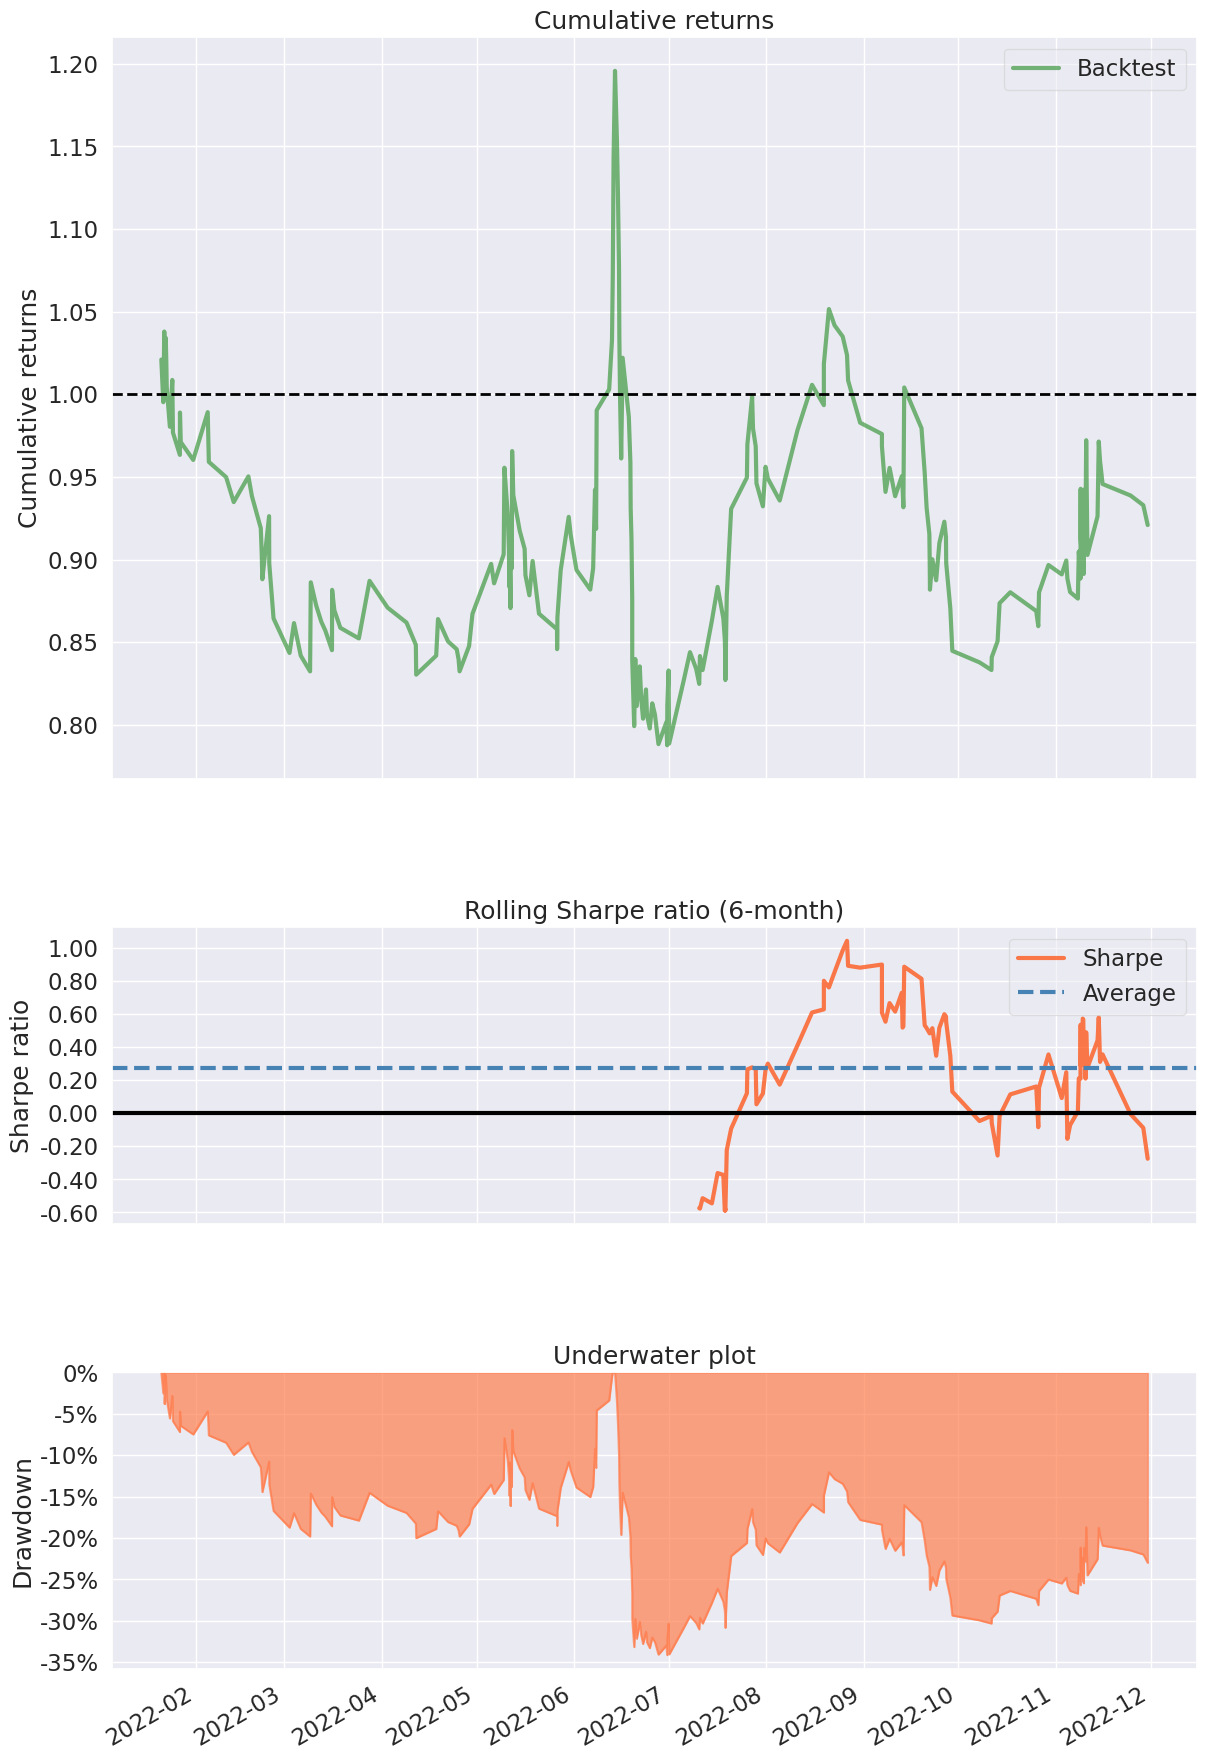

In [64]:
stats_df = stats['_trades'][['ReturnPct', 'EntryTime']]
stats_df = stats_df.set_index('EntryTime')

pf.create_simple_tear_sheet(stats_df['ReturnPct'])

In [65]:
meta_threshold = 0.55
size_threshold = 0.55

class KellyMetaStrategy(Strategy):
    def init(self):
        super().init()
    def next(self):
        super().next()

        available_to_trade = True
        if len(self.trades)>=1:
            available_to_trade = False
        if not available_to_trade:
            return

        close_price     = self.data.Close[-1]
        volatility_tpsl = self.data.volatility_tpsl_600[-1]
        position        = self.data.position[-1]
        meta_act_prob   = self.data.meta_act_prob[-1]
        size_prob       = self.data.size_prob[-1]

        size=0.1

        if position==1 and meta_act_prob>=meta_threshold and size_prob>=size_threshold:
            size = round(kelly(size_prob, 1.0),2)
            ret_upper = np.exp(round((volatility_tpsl*long_ptsl[0]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*long_ptsl[1]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_tp = close_price+delta_upper
            price_sl = close_price-delta_lower
            #print(f"BUY at {close_price} SL={price_sl} TP={price_tp}")
            self.buy(size=size, sl=price_sl, tp=price_tp)

        if position==-1 and meta_act_prob>=meta_threshold and size_prob>=size_threshold:
            size = round(kelly(size_prob, 1.0),2)
            ret_upper = np.exp(round((volatility_tpsl*short_ptsl[1]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*short_ptsl[0]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_sl = close_price+delta_upper
            price_tp = close_price-delta_lower
            #print(f"SELL at {close_price} SL={price_sl} TP={price_tp}")
            self.sell(size=size, sl=price_sl, tp=price_tp)

bt = Backtest(
    eval_df, 
    KellyMetaStrategy, 
    cash             = 100000000, 
    commission       = binance_commission, 
    exclusive_orders = True
    )

stats = bt.run()
stats

Start                     2022-01-14 00:00:00
End                       2022-11-30 23:59:00
Duration                    320 days 23:59:00
Exposure Time [%]                   44.841641
Equity Final [$]              93210652.535528
Equity Peak [$]              112328261.465126
Return [%]                          -6.789347
Buy & Hold Return [%]              -59.709841
Return (Ann.) [%]                   -7.683328
Volatility (Ann.) [%]               19.588059
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -22.321429
Avg. Drawdown [%]                   -1.230906
Max. Drawdown Duration      169 days 07:57:00
Avg. Drawdown Duration        6 days 03:14:00
# Trades                                  269
Win Rate [%]                        34.572491
Best Trade [%]                       7.930082
Worst Trade [%]                     -7.141878
Avg. Trade [%]                    

Start date,2022-01-20
End date,2022-11-30
Total months,12
,Backtest
Annual return,-34.2%
Cumulative returns,-36.0%
Annual volatility,42.9%
Sharpe ratio,-0.76
Calmar ratio,-0.65
Stability,0.63
Max drawdown,-52.9%


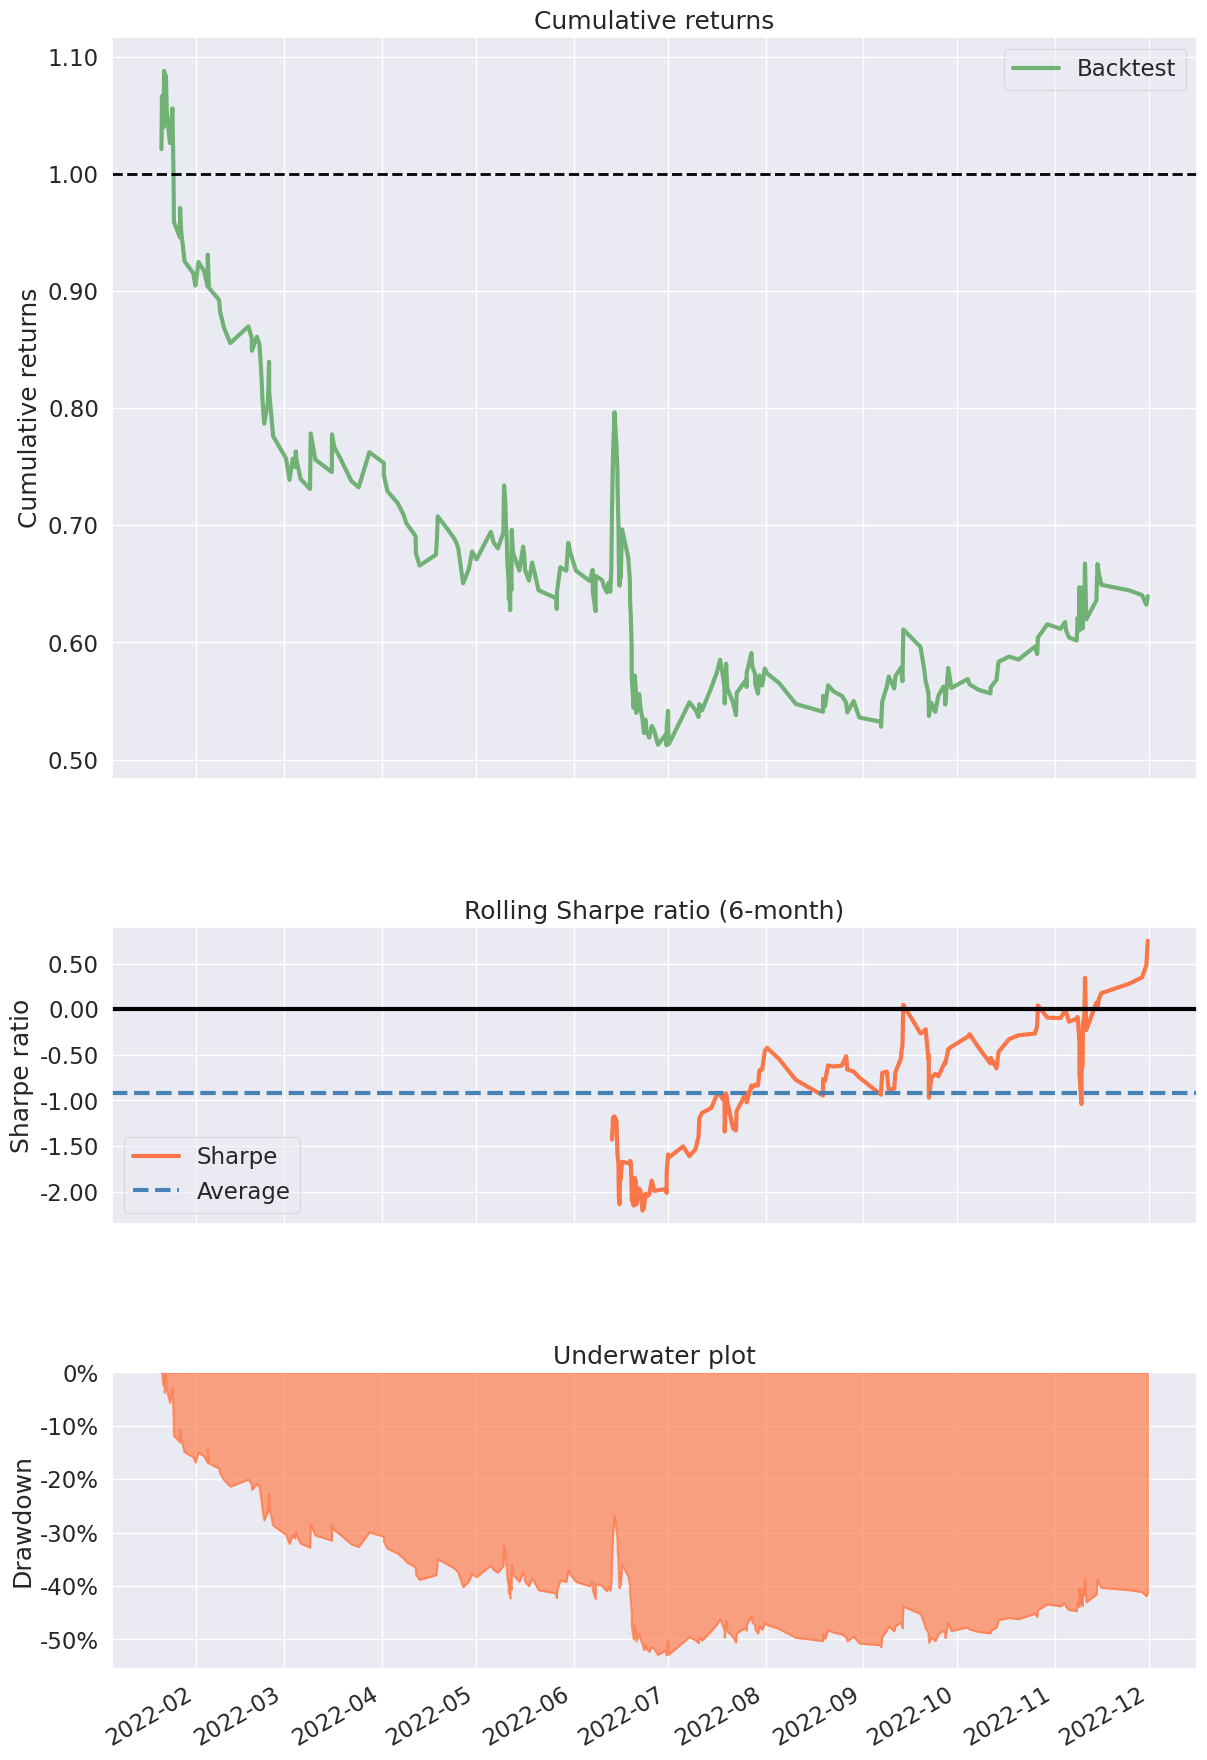

In [66]:
stats_df = stats['_trades'][['ReturnPct', 'EntryTime']]
stats_df = stats_df.set_index('EntryTime')

pf.create_simple_tear_sheet(stats_df['ReturnPct'])

In [67]:
meta_threshold = 0.55
size_threshold = 0.6

class KellyMetaStrategy(Strategy):
    def init(self):
        super().init()
    def next(self):
        super().next()

        available_to_trade = True
        if len(self.trades)>=1:
            available_to_trade = False
        if not available_to_trade:
            return

        close_price     = self.data.Close[-1]
        volatility_tpsl = self.data.volatility_tpsl_600[-1]
        position        = self.data.position[-1]
        meta_act_prob   = self.data.meta_act_prob[-1]
        size_prob       = self.data.size_prob[-1]

        size=0.1

        if position==1 and meta_act_prob>=meta_threshold and size_prob>=size_threshold:
            size = round(kelly(size_prob, 1.0),2)
            ret_upper = np.exp(round((volatility_tpsl*long_ptsl[0]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*long_ptsl[1]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_tp = close_price+delta_upper
            price_sl = close_price-delta_lower
            #print(f"BUY at {close_price} SL={price_sl} TP={price_tp}")
            self.buy(size=size, sl=price_sl, tp=price_tp)

        if position==-1 and meta_act_prob>=meta_threshold and size_prob>=size_threshold:
            size = round(kelly(size_prob, 1.0),2)
            ret_upper = np.exp(round((volatility_tpsl*short_ptsl[1]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*short_ptsl[0]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_sl = close_price+delta_upper
            price_tp = close_price-delta_lower
            #print(f"SELL at {close_price} SL={price_sl} TP={price_tp}")
            self.sell(size=size, sl=price_sl, tp=price_tp)

bt = Backtest(
    eval_df, 
    KellyMetaStrategy, 
    cash             = 100000000, 
    commission       = binance_commission, 
    exclusive_orders = True
    )

stats = bt.run()
stats

Start                     2022-01-14 00:00:00
End                       2022-11-30 23:59:00
Duration                    320 days 23:59:00
Exposure Time [%]                   36.558065
Equity Final [$]              98594764.398519
Equity Peak [$]              121173353.150282
Return [%]                          -1.405236
Buy & Hold Return [%]              -59.709841
Return (Ann.) [%]                   -1.596308
Volatility (Ann.) [%]                21.64666
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -23.29956
Avg. Drawdown [%]                   -1.020319
Max. Drawdown Duration      169 days 07:57:00
Avg. Drawdown Duration        3 days 22:39:00
# Trades                                  213
Win Rate [%]                        36.150235
Best Trade [%]                       7.930082
Worst Trade [%]                     -7.141878
Avg. Trade [%]                    

Start date,2022-01-20
End date,2022-11-30
Total months,10
,Backtest
Annual return,-9.3%
Cumulative returns,-7.9%
Annual volatility,45.6%
Sharpe ratio,0.01
Calmar ratio,-0.27
Stability,0.00
Max drawdown,-34.1%


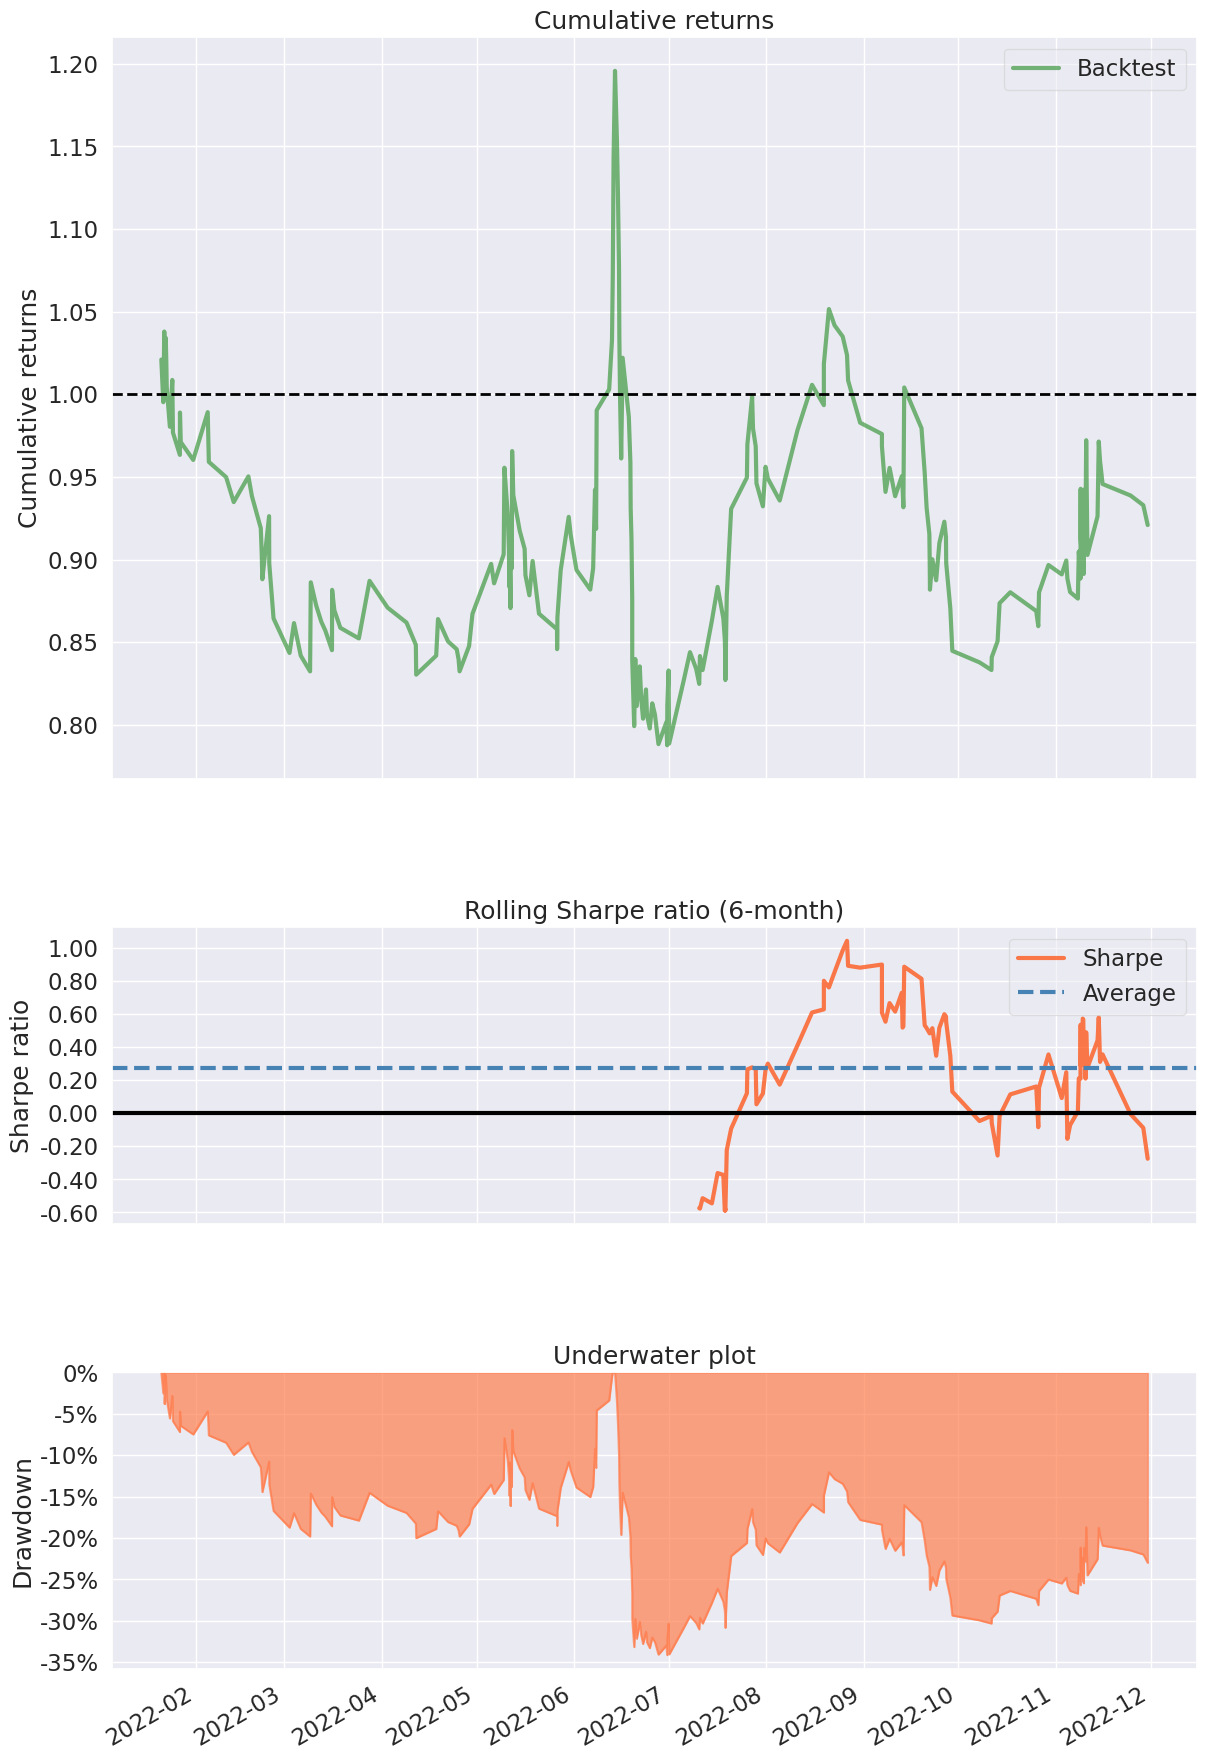

In [68]:
stats_df = stats['_trades'][['ReturnPct', 'EntryTime']]
stats_df = stats_df.set_index('EntryTime')

pf.create_simple_tear_sheet(stats_df['ReturnPct'])

In [69]:
meta_threshold       = 0.55
size_threshold       = 0.55
size_upper_threshold = 0.6

class MetaStrategy(Strategy):
    def init(self):
        super().init()
    def next(self):
        super().next()

        available_to_trade = True
        if len(self.trades)>=1:
            available_to_trade = False
        if not available_to_trade:
            return

        close_price     = self.data.Close[-1]
        volatility_tpsl = self.data.volatility_tpsl_600[-1]
        position        = self.data.position[-1]
        meta_act_prob   = self.data.meta_act_prob[-1]
        size_prob       = self.data.size_prob[-1]

        size=0.1
        if size_prob>=size_threshold and size_prob<=size_upper_threshold:
            size = 0.5
        if size_prob>size_upper_threshold:
            size = 1.0

        if position==1 and meta_act_prob>=meta_threshold and size_prob>=size_threshold:
            ret_upper = np.exp(round((volatility_tpsl*long_ptsl[0]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*long_ptsl[1]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_tp = close_price+delta_upper
            price_sl = close_price-delta_lower
            #print(f"BUY at {close_price} SL={price_sl} TP={price_tp}")
            self.buy(size=size, sl=price_sl, tp=price_tp)

        if position==-1 and meta_act_prob>=meta_threshold and size_prob>=size_threshold:
            ret_upper = np.exp(round((volatility_tpsl*short_ptsl[1]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*short_ptsl[0]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_sl = close_price+delta_upper
            price_tp = close_price-delta_lower
            #print(f"SELL at {close_price} SL={price_sl} TP={price_tp}")
            self.sell(size=size, sl=price_sl, tp=price_tp)

bt = Backtest(
    eval_df, 
    MetaStrategy, 
    cash             = 100000000, 
    commission       = binance_commission, 
    exclusive_orders = True
    )

stats = bt.run()
stats

Start                     2022-01-14 00:00:00
End                       2022-11-30 23:59:00
Duration                    320 days 23:59:00
Exposure Time [%]                   44.841641
Equity Final [$]              83528488.516661
Equity Peak [$]              104414607.759878
Return [%]                         -16.471511
Buy & Hold Return [%]              -59.709841
Return (Ann.) [%]                  -18.506989
Volatility (Ann.) [%]                9.824637
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -25.883335
Avg. Drawdown [%]                   -1.073846
Max. Drawdown Duration      312 days 12:11:00
Avg. Drawdown Duration       11 days 04:48:00
# Trades                                  269
Win Rate [%]                        34.572491
Best Trade [%]                       7.930082
Worst Trade [%]                     -7.141878
Avg. Trade [%]                    

Start date,2022-01-20
End date,2022-11-30
Total months,12
,Backtest
Annual return,-34.2%
Cumulative returns,-36.0%
Annual volatility,42.9%
Sharpe ratio,-0.76
Calmar ratio,-0.65
Stability,0.63
Max drawdown,-52.9%


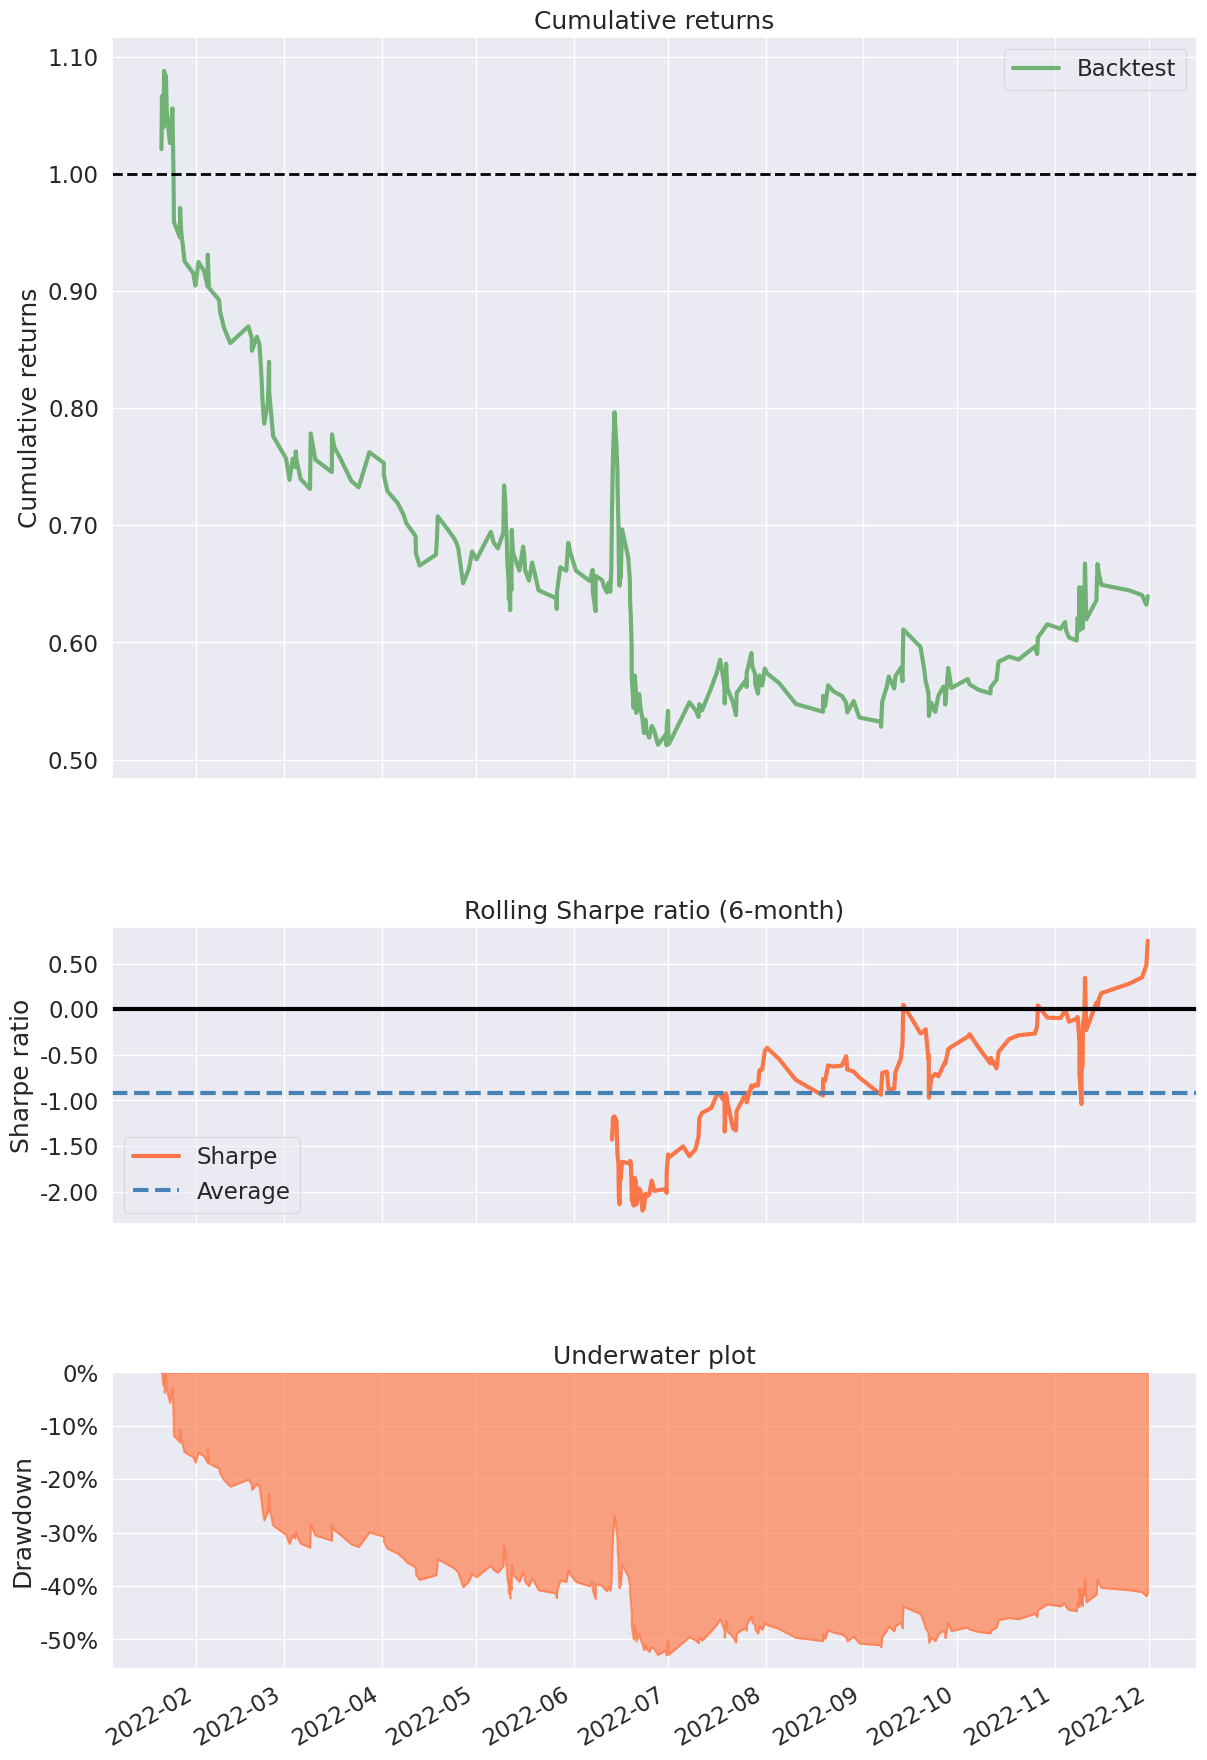

In [70]:
stats_df = stats['_trades'][['ReturnPct', 'EntryTime']]
stats_df = stats_df.set_index('EntryTime')

pf.create_simple_tear_sheet(stats_df['ReturnPct'])

In [71]:
meta_threshold       = 0.55
size_threshold       = 0.6
size_upper_threshold = 0.65

class MetaStrategy(Strategy):
    def init(self):
        super().init()
    def next(self):
        super().next()

        available_to_trade = True
        if len(self.trades)>=1:
            available_to_trade = False
        if not available_to_trade:
            return

        close_price     = self.data.Close[-1]
        volatility_tpsl = self.data.volatility_tpsl_600[-1]
        position        = self.data.position[-1]
        meta_act_prob   = self.data.meta_act_prob[-1]
        size_prob       = self.data.size_prob[-1]

        size=0.1
        if size_prob>=size_threshold and size_prob<=size_upper_threshold:
            size = 0.5
        if size_prob>size_upper_threshold:
            size = 1.0

        if position==1 and meta_act_prob>=meta_threshold and size_prob>=size_threshold:
            ret_upper = np.exp(round((volatility_tpsl*long_ptsl[0]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*long_ptsl[1]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_tp = close_price+delta_upper
            price_sl = close_price-delta_lower
            #print(f"BUY at {close_price} SL={price_sl} TP={price_tp}")
            self.buy(size=size, sl=price_sl, tp=price_tp)

        if position==-1 and meta_act_prob>=meta_threshold and size_prob>=size_threshold:
            ret_upper = np.exp(round((volatility_tpsl*short_ptsl[1]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*short_ptsl[0]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_sl = close_price+delta_upper
            price_tp = close_price-delta_lower
            #print(f"SELL at {close_price} SL={price_sl} TP={price_tp}")
            self.sell(size=size, sl=price_sl, tp=price_tp)

bt = Backtest(
    eval_df, 
    MetaStrategy, 
    cash             = 100000000, 
    commission       = binance_commission, 
    exclusive_orders = True
    )

stats = bt.run()
stats

Start                     2022-01-14 00:00:00
End                       2022-11-30 23:59:00
Duration                    320 days 23:59:00
Exposure Time [%]                   36.558065
Equity Final [$]              87626251.197429
Equity Peak [$]              101812003.440032
Return [%]                         -12.373749
Buy & Hold Return [%]              -59.709841
Return (Ann.) [%]                   -13.94601
Volatility (Ann.) [%]                9.485306
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -15.582681
Avg. Drawdown [%]                   -1.537495
Max. Drawdown Duration      312 days 11:49:00
Avg. Drawdown Duration       24 days 02:41:00
# Trades                                  213
Win Rate [%]                        36.150235
Best Trade [%]                       7.930082
Worst Trade [%]                     -7.141878
Avg. Trade [%]                    

Start date,2022-01-20
End date,2022-11-30
Total months,10
,Backtest
Annual return,-9.3%
Cumulative returns,-7.9%
Annual volatility,45.6%
Sharpe ratio,0.01
Calmar ratio,-0.27
Stability,0.00
Max drawdown,-34.1%


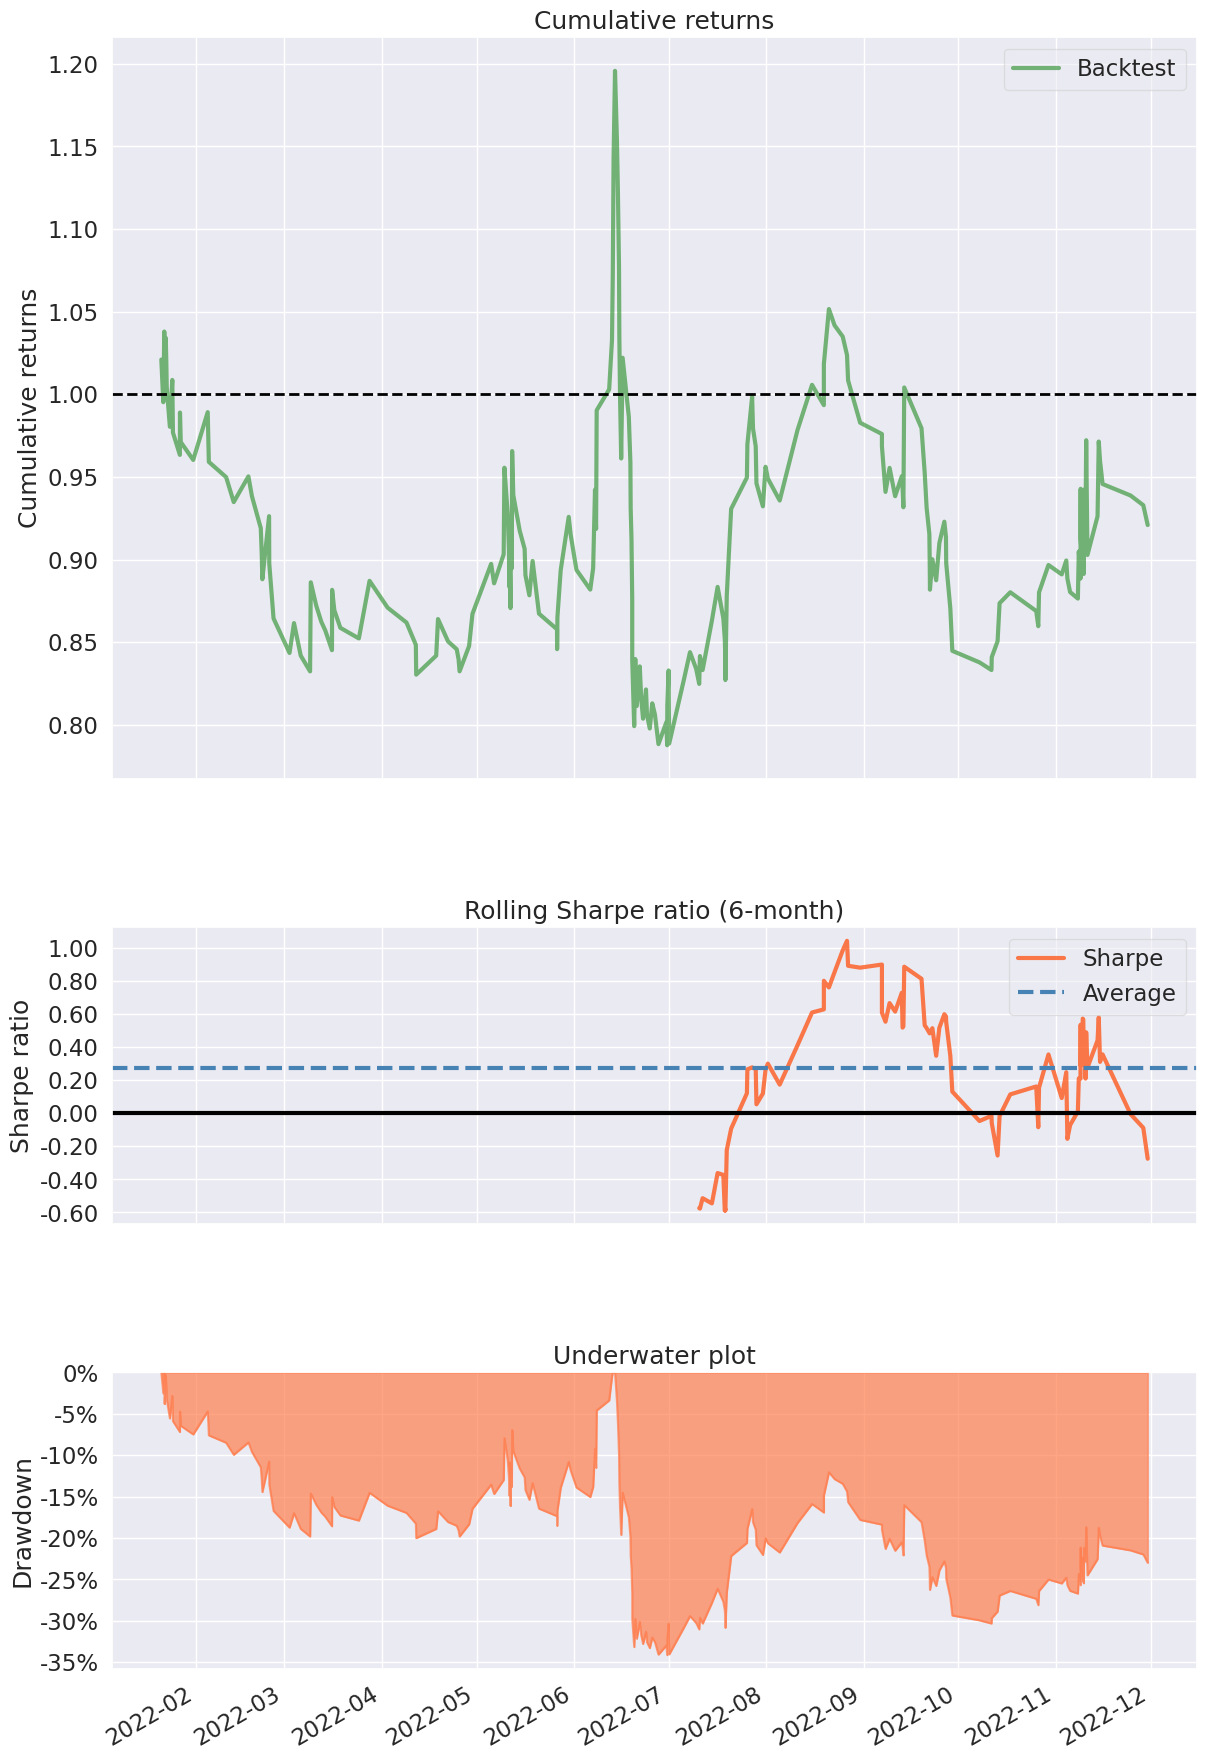

In [72]:
stats_df = stats['_trades'][['ReturnPct', 'EntryTime']]
stats_df = stats_df.set_index('EntryTime')

pf.create_simple_tear_sheet(stats_df['ReturnPct'])

In [73]:
meta_threshold       = 0.55
size_threshold       = 0.6
size_upper_threshold = 0.7

class MetaStrategy(Strategy):
    def init(self):
        super().init()
    def next(self):
        super().next()

        available_to_trade = True
        if len(self.trades)>=1:
            available_to_trade = False
        if not available_to_trade:
            return

        close_price     = self.data.Close[-1]
        volatility_tpsl = self.data.volatility_tpsl_600[-1]
        position        = self.data.position[-1]
        meta_act_prob   = self.data.meta_act_prob[-1]
        size_prob       = self.data.size_prob[-1]

        size=0.1
        if size_prob>=size_threshold and size_prob<=size_upper_threshold:
            size = 0.5
        if size_prob>size_upper_threshold:
            size = 1.0

        if position==1 and meta_act_prob>=meta_threshold and size_prob>=size_threshold:
            ret_upper = np.exp(round((volatility_tpsl*long_ptsl[0]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*long_ptsl[1]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_tp = close_price+delta_upper
            price_sl = close_price-delta_lower
            #print(f"BUY at {close_price} SL={price_sl} TP={price_tp}")
            self.buy(size=size, sl=price_sl, tp=price_tp)

        if position==-1 and meta_act_prob>=meta_threshold and size_prob>=size_threshold:
            ret_upper = np.exp(round((volatility_tpsl*short_ptsl[1]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*short_ptsl[0]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_sl = close_price+delta_upper
            price_tp = close_price-delta_lower
            #print(f"SELL at {close_price} SL={price_sl} TP={price_tp}")
            self.sell(size=size, sl=price_sl, tp=price_tp)

bt = Backtest(
    eval_df, 
    MetaStrategy, 
    cash             = 100000000, 
    commission       = binance_commission, 
    exclusive_orders = True
    )

stats = bt.run()
stats

Start                     2022-01-14 00:00:00
End                       2022-11-30 23:59:00
Duration                    320 days 23:59:00
Exposure Time [%]                   36.558065
Equity Final [$]              92125794.796708
Equity Peak [$]              101526763.427946
Return [%]                          -7.874205
Buy & Hold Return [%]              -59.709841
Return (Ann.) [%]                    -8.90408
Volatility (Ann.) [%]               13.273657
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -17.010998
Avg. Drawdown [%]                   -1.732304
Max. Drawdown Duration      313 days 01:55:00
Avg. Drawdown Duration       28 days 12:04:00
# Trades                                  213
Win Rate [%]                        36.150235
Best Trade [%]                       7.930082
Worst Trade [%]                     -7.141878
Avg. Trade [%]                    

Start date,2022-01-20
End date,2022-11-30
Total months,10
,Backtest
Annual return,-9.3%
Cumulative returns,-7.9%
Annual volatility,45.6%
Sharpe ratio,0.01
Calmar ratio,-0.27
Stability,0.00
Max drawdown,-34.1%


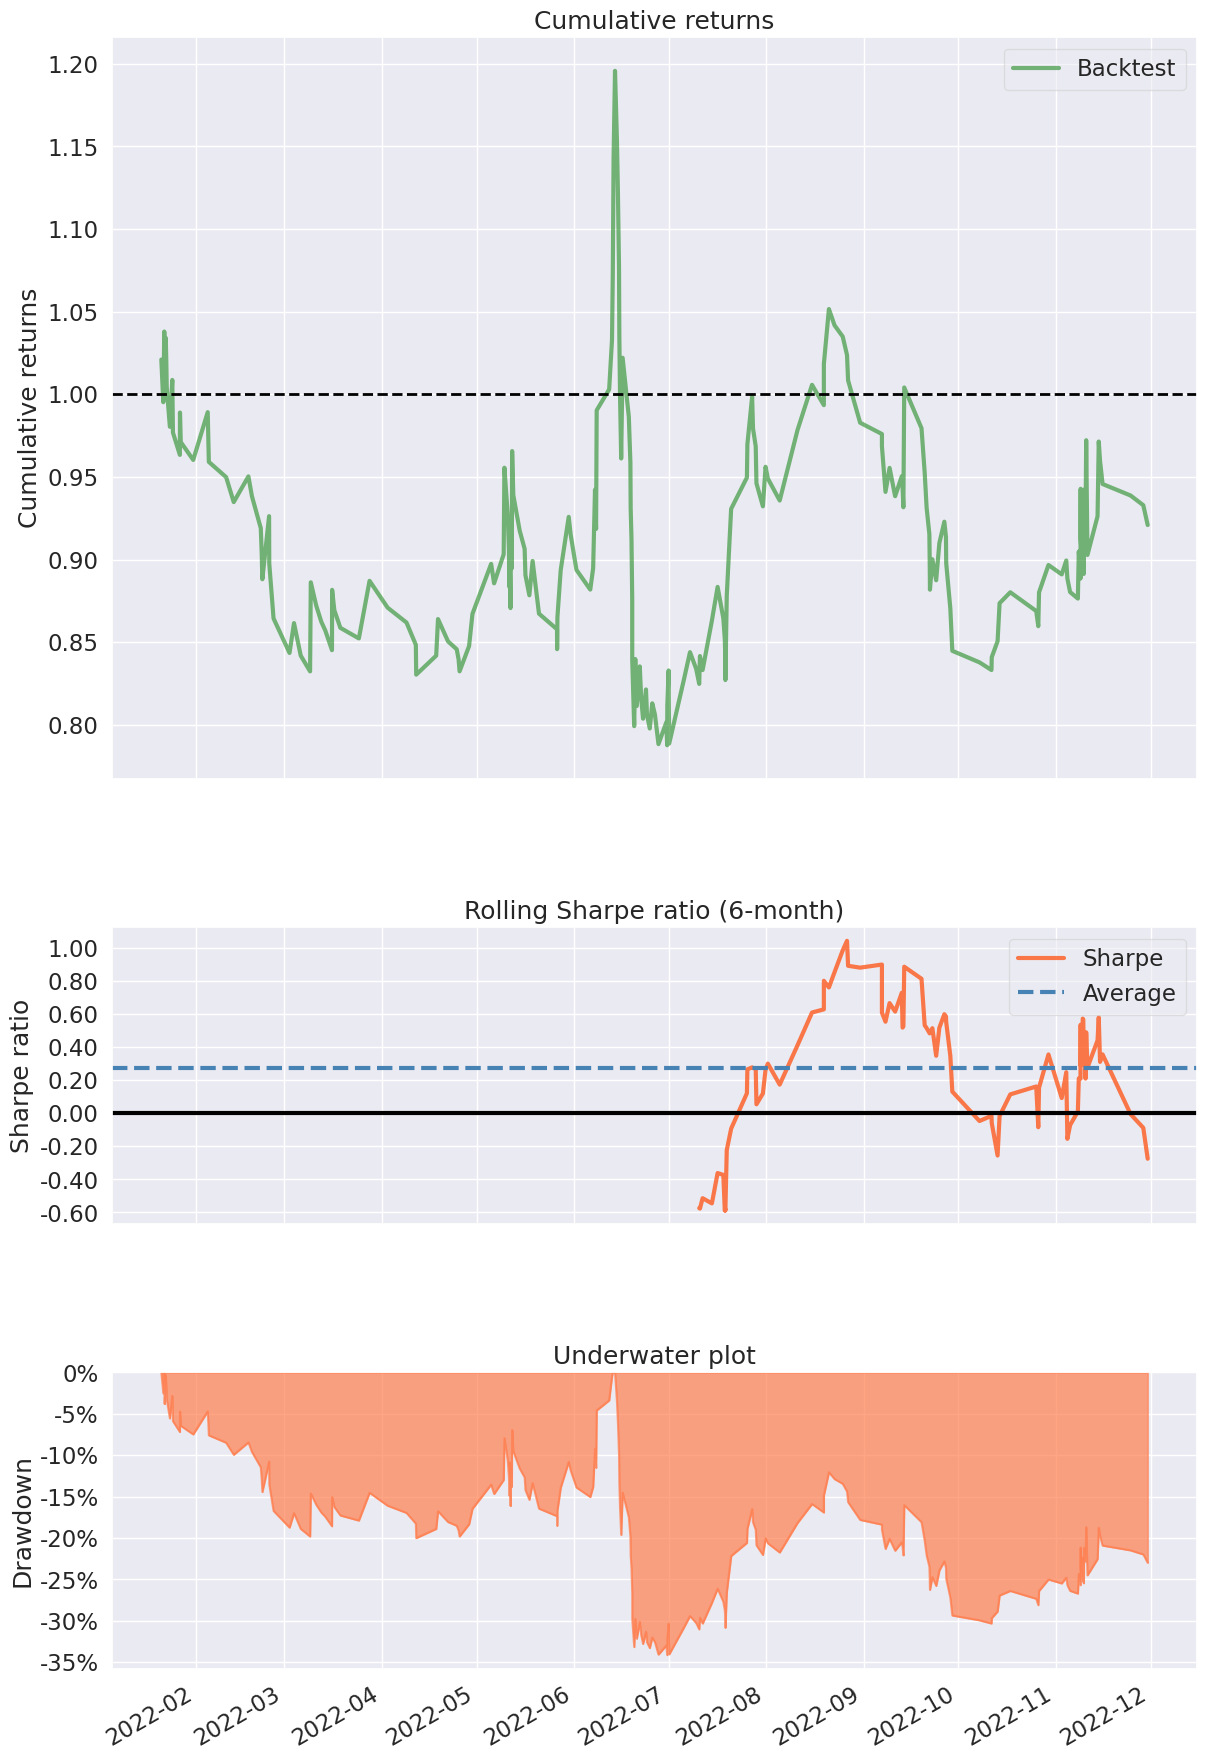

In [74]:
stats_df = stats['_trades'][['ReturnPct', 'EntryTime']]
stats_df = stats_df.set_index('EntryTime')

pf.create_simple_tear_sheet(stats_df['ReturnPct'])

In [75]:
meta_threshold       = 0.55
size_threshold       = 0.75
size_upper_threshold = 0.8

class MetaStrategy(Strategy):
    def init(self):
        super().init()
    def next(self):
        super().next()

        available_to_trade = True
        if len(self.trades)>=1:
            available_to_trade = False
        if not available_to_trade:
            return

        close_price     = self.data.Close[-1]
        volatility_tpsl = self.data.volatility_tpsl_600[-1]
        position        = self.data.position[-1]
        meta_act_prob   = self.data.meta_act_prob[-1]
        size_prob       = self.data.size_prob[-1]

        size=0.1
        if size_prob>=size_threshold and size_prob<=size_upper_threshold:
            size = 0.5
        if size_prob>size_upper_threshold:
            size = 1.0

        if position==1 and meta_act_prob>=meta_threshold and size_prob>=size_threshold:
            ret_upper = np.exp(round((volatility_tpsl*long_ptsl[0]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*long_ptsl[1]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_tp = close_price+delta_upper
            price_sl = close_price-delta_lower
            #print(f"BUY at {close_price} SL={price_sl} TP={price_tp}")
            self.buy(size=size, sl=price_sl, tp=price_tp)

        if position==-1 and meta_act_prob>=meta_threshold and size_prob>=size_threshold:
            ret_upper = np.exp(round((volatility_tpsl*short_ptsl[1]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*short_ptsl[0]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_sl = close_price+delta_upper
            price_tp = close_price-delta_lower
            #print(f"SELL at {close_price} SL={price_sl} TP={price_tp}")
            self.sell(size=size, sl=price_sl, tp=price_tp)

bt = Backtest(
    eval_df, 
    MetaStrategy, 
    cash             = 100000000, 
    commission       = binance_commission, 
    exclusive_orders = True
    )

stats = bt.run()
stats

Start                     2022-01-14 00:00:00
End                       2022-11-30 23:59:00
Duration                    320 days 23:59:00
Exposure Time [%]                    14.88837
Equity Final [$]             102394837.291286
Equity Peak [$]              114343930.073762
Return [%]                           2.394837
Buy & Hold Return [%]              -59.709841
Return (Ann.) [%]                    2.727541
Volatility (Ann.) [%]                9.159133
Sharpe Ratio                         0.297795
Sortino Ratio                         0.55171
Calmar Ratio                         0.240102
Max. Drawdown [%]                  -11.359901
Avg. Drawdown [%]                   -0.312499
Max. Drawdown Duration      165 days 03:07:00
Avg. Drawdown Duration        1 days 15:15:00
# Trades                                   98
Win Rate [%]                        39.795918
Best Trade [%]                       8.146828
Worst Trade [%]                     -7.141878
Avg. Trade [%]                    

Start date,2022-01-20
End date,2022-11-28
Total months,4
,Backtest
Annual return,98.1%
Cumulative returns,30.5%
Annual volatility,52.5%
Sharpe ratio,1.56
Calmar ratio,3.75
Stability,0.41
Max drawdown,-26.2%


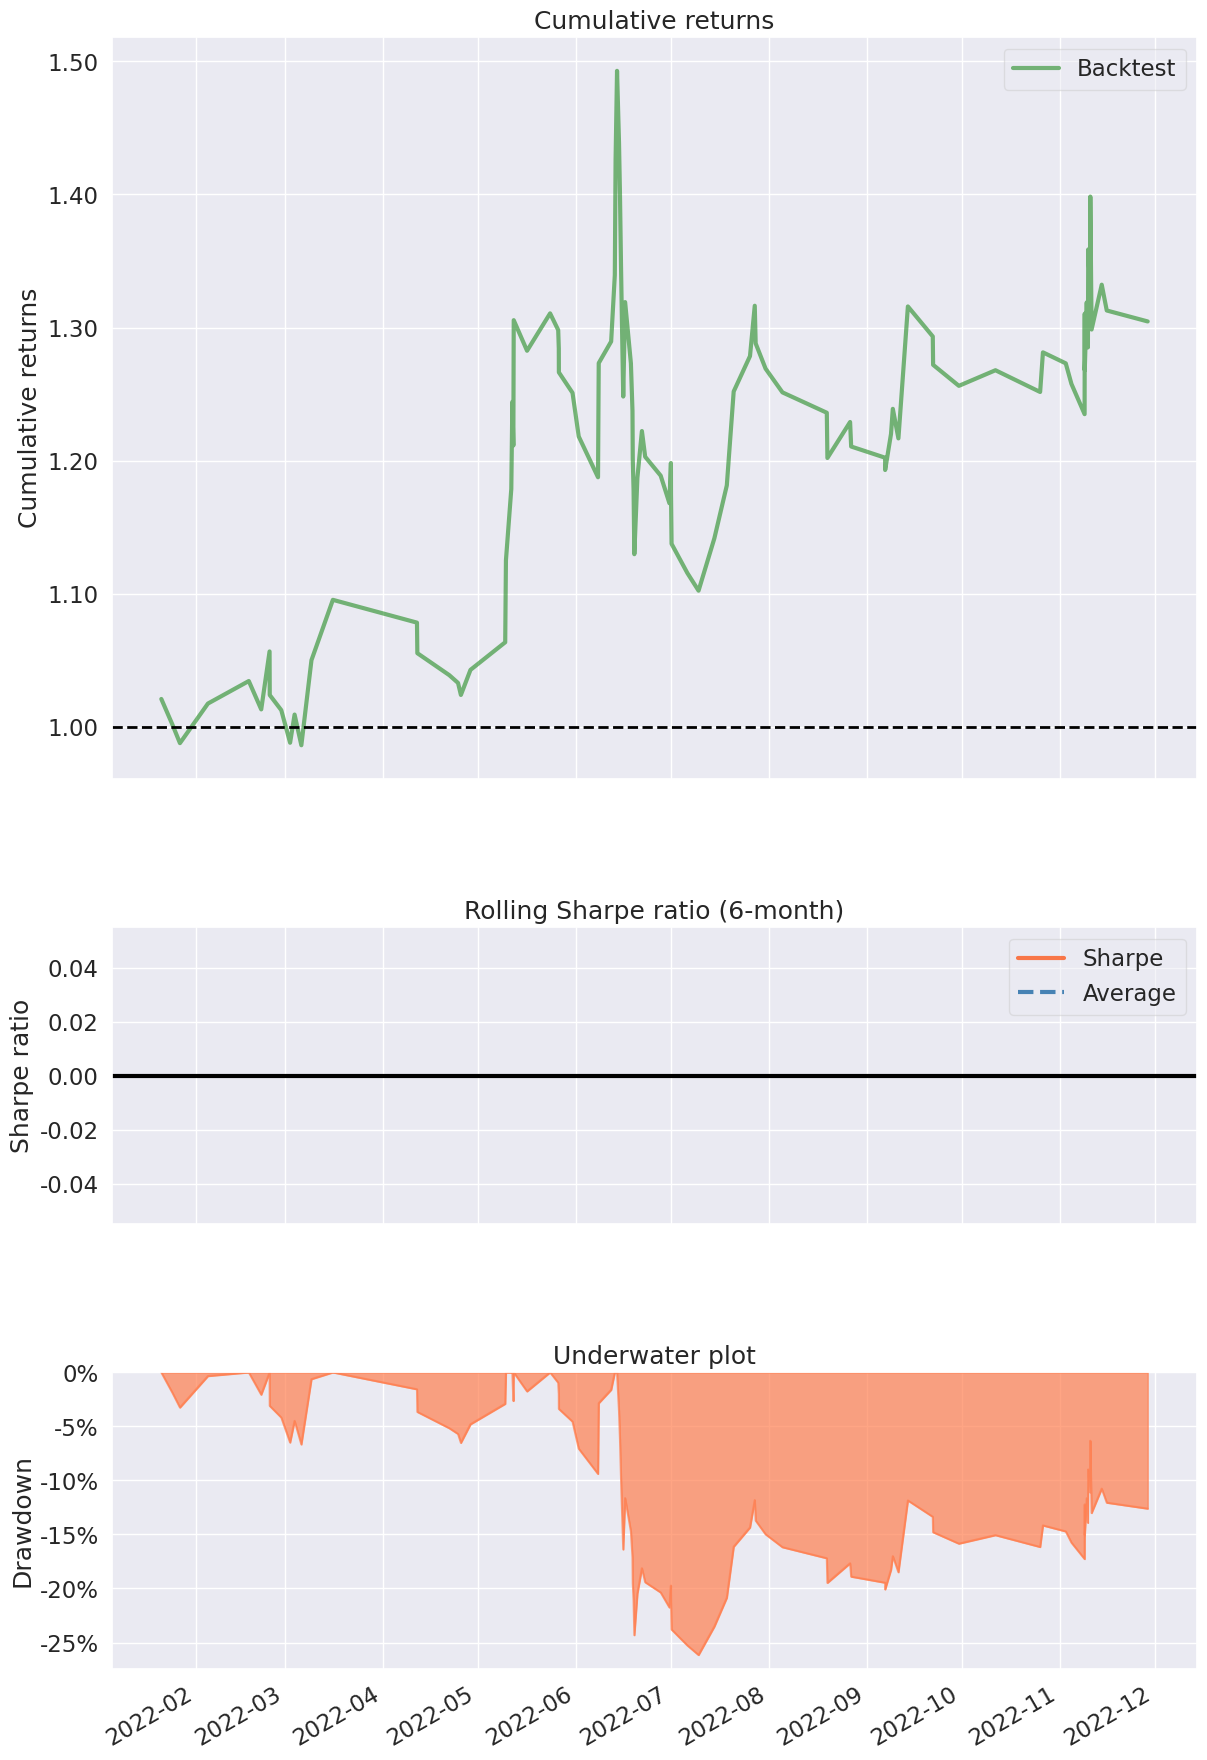

In [76]:
stats_df = stats['_trades'][['ReturnPct', 'EntryTime']]
stats_df = stats_df.set_index('EntryTime')

pf.create_simple_tear_sheet(stats_df['ReturnPct'])

In [77]:
meta_threshold       = 0.55
size_threshold       = 0.65
size_upper_threshold = 0.8

class MetaStrategy(Strategy):
    def init(self):
        super().init()
    def next(self):
        super().next()

        available_to_trade = True
        if len(self.trades)>=1:
            available_to_trade = False
        if not available_to_trade:
            return

        close_price     = self.data.Close[-1]
        volatility_tpsl = self.data.volatility_tpsl_600[-1]
        position        = self.data.position[-1]
        meta_act_prob   = self.data.meta_act_prob[-1]
        size_prob       = self.data.size_prob[-1]

        size=0.1
        if size_prob>=size_threshold and size_prob<=size_upper_threshold:
            size = 0.5
        if size_prob>size_upper_threshold:
            size = 1.0

        if position==1 and meta_act_prob>=meta_threshold and size_prob>=size_threshold:
            ret_upper = np.exp(round((volatility_tpsl*long_ptsl[0]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*long_ptsl[1]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_tp = close_price+delta_upper
            price_sl = close_price-delta_lower
            #print(f"BUY at {close_price} SL={price_sl} TP={price_tp}")
            self.buy(size=size, sl=price_sl, tp=price_tp)

        if position==-1 and meta_act_prob>=meta_threshold and size_prob>=size_threshold:
            ret_upper = np.exp(round((volatility_tpsl*short_ptsl[1]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*short_ptsl[0]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_sl = close_price+delta_upper
            price_tp = close_price-delta_lower
            #print(f"SELL at {close_price} SL={price_sl} TP={price_tp}")
            self.sell(size=size, sl=price_sl, tp=price_tp)

bt = Backtest(
    eval_df, 
    MetaStrategy, 
    cash             = 100000000, 
    commission       = binance_commission, 
    exclusive_orders = True
    )

stats = bt.run()
stats

Start                     2022-01-14 00:00:00
End                       2022-11-30 23:59:00
Duration                    320 days 23:59:00
Exposure Time [%]                   29.699939
Equity Final [$]             107627590.211801
Equity Peak [$]              116031920.491201
Return [%]                            7.62759
Buy & Hold Return [%]              -59.709841
Return (Ann.) [%]                    8.717496
Volatility (Ann.) [%]               17.321403
Sharpe Ratio                         0.503279
Sortino Ratio                        0.911651
Calmar Ratio                         0.840274
Max. Drawdown [%]                  -10.374592
Avg. Drawdown [%]                   -0.385877
Max. Drawdown Duration      107 days 22:38:00
Avg. Drawdown Duration        1 days 13:35:00
# Trades                                  164
Win Rate [%]                         39.02439
Best Trade [%]                       7.930082
Worst Trade [%]                     -7.141878
Avg. Trade [%]                    

Start date,2022-01-20
End date,2022-11-28
Total months,7
,Backtest
Annual return,37.1%
Cumulative returns,22.8%
Annual volatility,47.6%
Sharpe ratio,0.90
Calmar ratio,1.14
Stability,0.50
Max drawdown,-32.7%


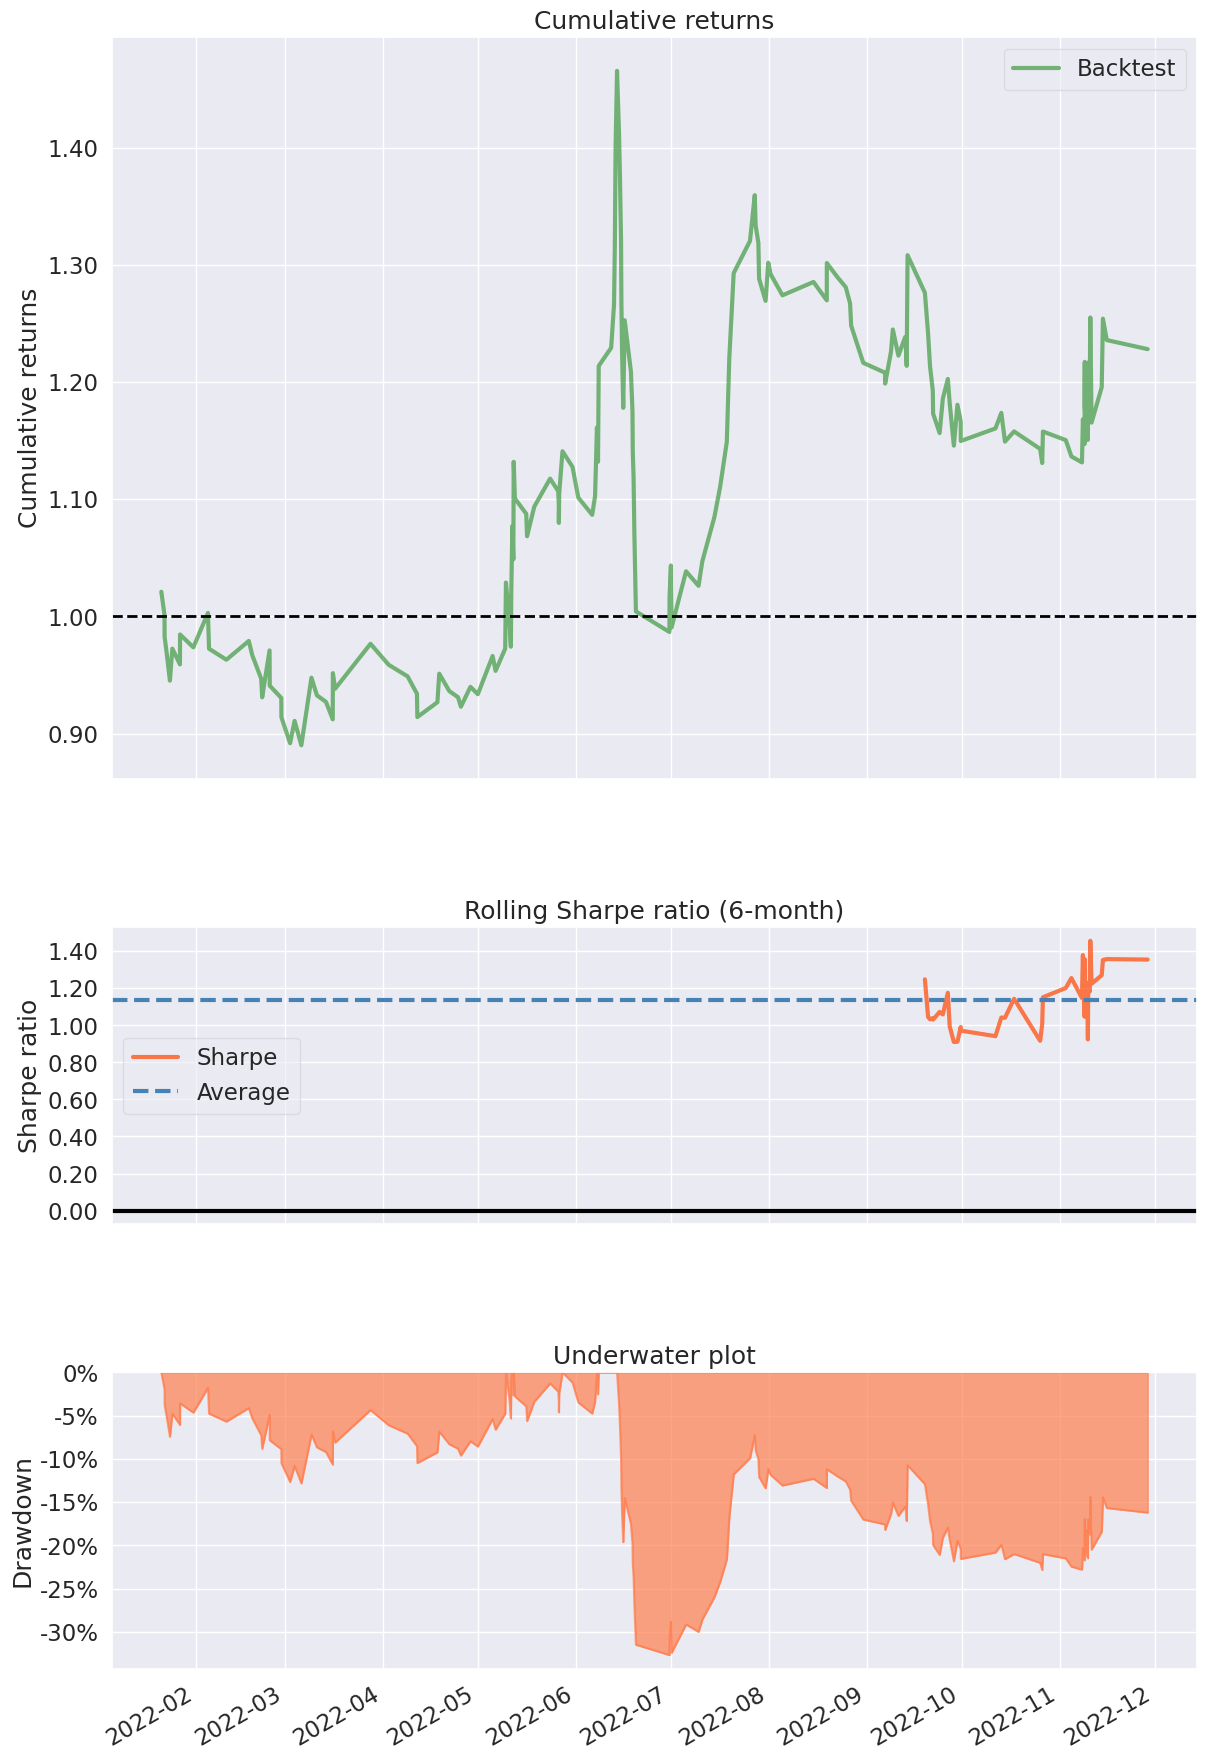

In [78]:
stats_df = stats['_trades'][['ReturnPct', 'EntryTime']]
stats_df = stats_df.set_index('EntryTime')

pf.create_simple_tear_sheet(stats_df['ReturnPct'])

In [79]:
meta_threshold       = 0.55
size_threshold       = 0.65
size_upper_threshold = 0.75

class MetaStrategy(Strategy):
    def init(self):
        super().init()
    def next(self):
        super().next()

        available_to_trade = True
        if len(self.trades)>=1:
            available_to_trade = False
        if not available_to_trade:
            return

        close_price     = self.data.Close[-1]
        volatility_tpsl = self.data.volatility_tpsl_600[-1]
        position        = self.data.position[-1]
        meta_act_prob   = self.data.meta_act_prob[-1]
        size_prob       = self.data.size_prob[-1]

        size=0.1
        if size_prob>=size_threshold and size_prob<=size_upper_threshold:
            size = 0.5
        if size_prob>size_upper_threshold:
            size = 1.0

        if position==1 and meta_act_prob>=meta_threshold and size_prob>=size_threshold:
            ret_upper = np.exp(round((volatility_tpsl*long_ptsl[0]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*long_ptsl[1]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_tp = close_price+delta_upper
            price_sl = close_price-delta_lower
            #print(f"BUY at {close_price} SL={price_sl} TP={price_tp}")
            self.buy(size=size, sl=price_sl, tp=price_tp)

        if position==-1 and meta_act_prob>=meta_threshold and size_prob>=size_threshold:
            ret_upper = np.exp(round((volatility_tpsl*short_ptsl[1]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*short_ptsl[0]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_sl = close_price+delta_upper
            price_tp = close_price-delta_lower
            #print(f"SELL at {close_price} SL={price_sl} TP={price_tp}")
            self.sell(size=size, sl=price_sl, tp=price_tp)

bt = Backtest(
    eval_df, 
    MetaStrategy, 
    cash             = 100000000, 
    commission       = binance_commission, 
    exclusive_orders = True
    )

stats = bt.run()
stats

Start                     2022-01-14 00:00:00
End                       2022-11-30 23:59:00
Duration                    320 days 23:59:00
Exposure Time [%]                   29.699939
Equity Final [$]             106340985.458324
Equity Peak [$]              111694492.981479
Return [%]                           6.340985
Buy & Hold Return [%]              -59.709841
Return (Ann.) [%]                    7.240934
Volatility (Ann.) [%]               14.907351
Sharpe Ratio                         0.485729
Sortino Ratio                        0.834537
Calmar Ratio                         0.688812
Max. Drawdown [%]                  -10.512213
Avg. Drawdown [%]                   -0.278551
Max. Drawdown Duration      142 days 01:26:00
Avg. Drawdown Duration        1 days 07:27:00
# Trades                                  164
Win Rate [%]                         39.02439
Best Trade [%]                       7.930082
Worst Trade [%]                     -7.141878
Avg. Trade [%]                    

Start date,2022-01-20
End date,2022-11-28
Total months,7
,Backtest
Annual return,37.1%
Cumulative returns,22.8%
Annual volatility,47.6%
Sharpe ratio,0.90
Calmar ratio,1.14
Stability,0.50
Max drawdown,-32.7%


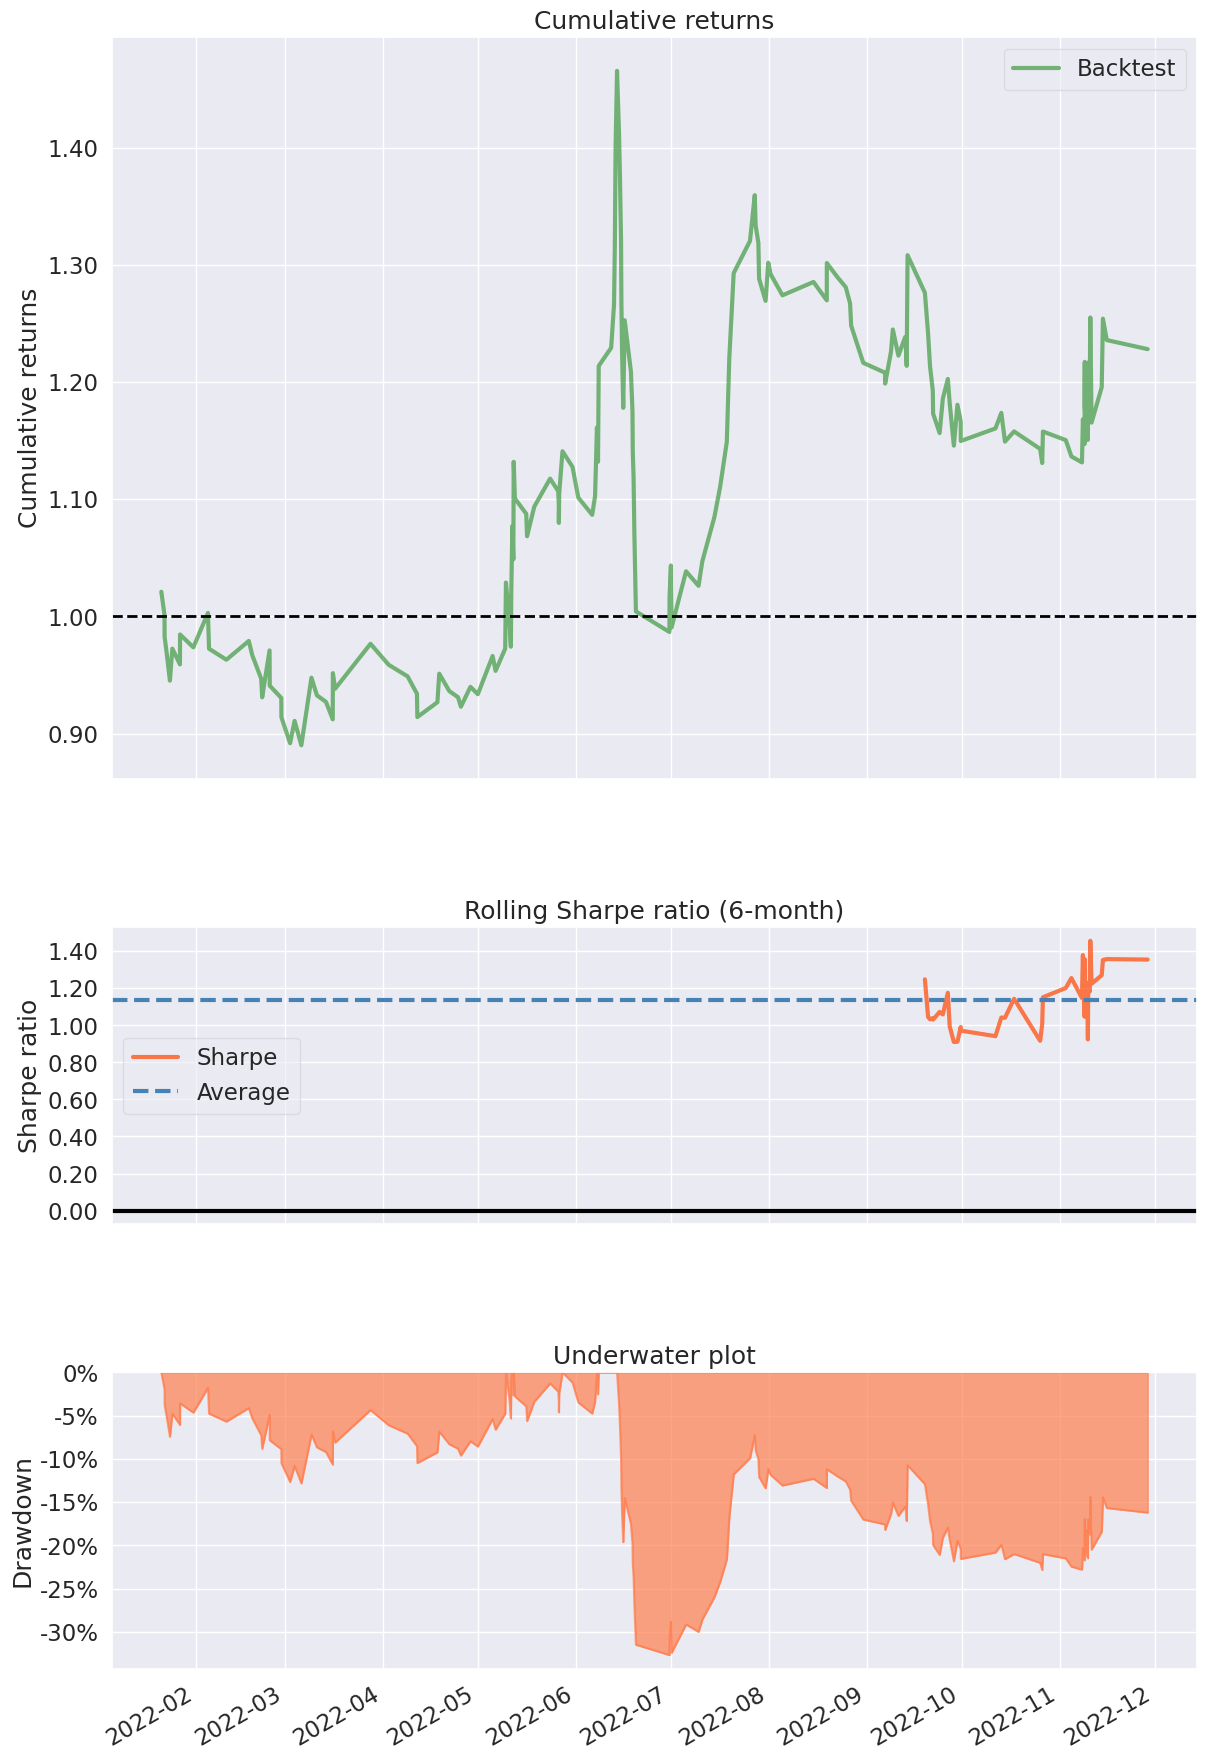

In [80]:
stats_df = stats['_trades'][['ReturnPct', 'EntryTime']]
stats_df = stats_df.set_index('EntryTime')

pf.create_simple_tear_sheet(stats_df['ReturnPct'])

In [81]:
meta_threshold       = 0.55
size_threshold       = 0.6
size_upper_threshold = 0.75

class MetaStrategy(Strategy):
    def init(self):
        super().init()
    def next(self):
        super().next()

        available_to_trade = True
        if len(self.trades)>=1:
            available_to_trade = False
        if not available_to_trade:
            return

        close_price     = self.data.Close[-1]
        volatility_tpsl = self.data.volatility_tpsl_600[-1]
        position        = self.data.position[-1]
        meta_act_prob   = self.data.meta_act_prob[-1]
        size_prob       = self.data.size_prob[-1]

        size=0.1
        if size_prob>=size_threshold and size_prob<=size_upper_threshold:
            size = 0.5
        if size_prob>size_upper_threshold:
            size = 1.0

        if position==1 and meta_act_prob>=meta_threshold and size_prob>=size_threshold:
            ret_upper = np.exp(round((volatility_tpsl*long_ptsl[0]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*long_ptsl[1]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_tp = close_price+delta_upper
            price_sl = close_price-delta_lower
            #print(f"BUY at {close_price} SL={price_sl} TP={price_tp}")
            self.buy(size=size, sl=price_sl, tp=price_tp)

        if position==-1 and meta_act_prob>=meta_threshold and size_prob>=size_threshold:
            ret_upper = np.exp(round((volatility_tpsl*short_ptsl[1]), 6))-1.0
            ret_lower = np.exp(round((volatility_tpsl*short_ptsl[0]), 6))-1.0
            price_upper = (ret_upper+1.0)*close_price
            price_lower = (ret_lower+1.0)*close_price
            delta_upper = abs(close_price-price_upper)
            delta_lower = abs(close_price-price_lower)
            price_sl = close_price+delta_upper
            price_tp = close_price-delta_lower
            #print(f"SELL at {close_price} SL={price_sl} TP={price_tp}")
            self.sell(size=size, sl=price_sl, tp=price_tp)

bt = Backtest(
    eval_df, 
    MetaStrategy, 
    cash             = 100000000, 
    commission       = binance_commission, 
    exclusive_orders = True
    )

stats = bt.run()
stats

Start                     2022-01-14 00:00:00
End                       2022-11-30 23:59:00
Duration                    320 days 23:59:00
Exposure Time [%]                   36.558065
Equity Final [$]              94558728.152297
Equity Peak [$]              101526763.427946
Return [%]                          -5.441272
Buy & Hold Return [%]              -59.709841
Return (Ann.) [%]                   -6.163672
Volatility (Ann.) [%]               16.471506
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -16.330714
Avg. Drawdown [%]                    -1.67046
Max. Drawdown Duration      313 days 01:55:00
Avg. Drawdown Duration       28 days 12:04:00
# Trades                                  213
Win Rate [%]                        36.150235
Best Trade [%]                       7.930082
Worst Trade [%]                     -7.141878
Avg. Trade [%]                    

Start date,2022-01-20
End date,2022-11-30
Total months,10
,Backtest
Annual return,-9.3%
Cumulative returns,-7.9%
Annual volatility,45.6%
Sharpe ratio,0.01
Calmar ratio,-0.27
Stability,0.00
Max drawdown,-34.1%


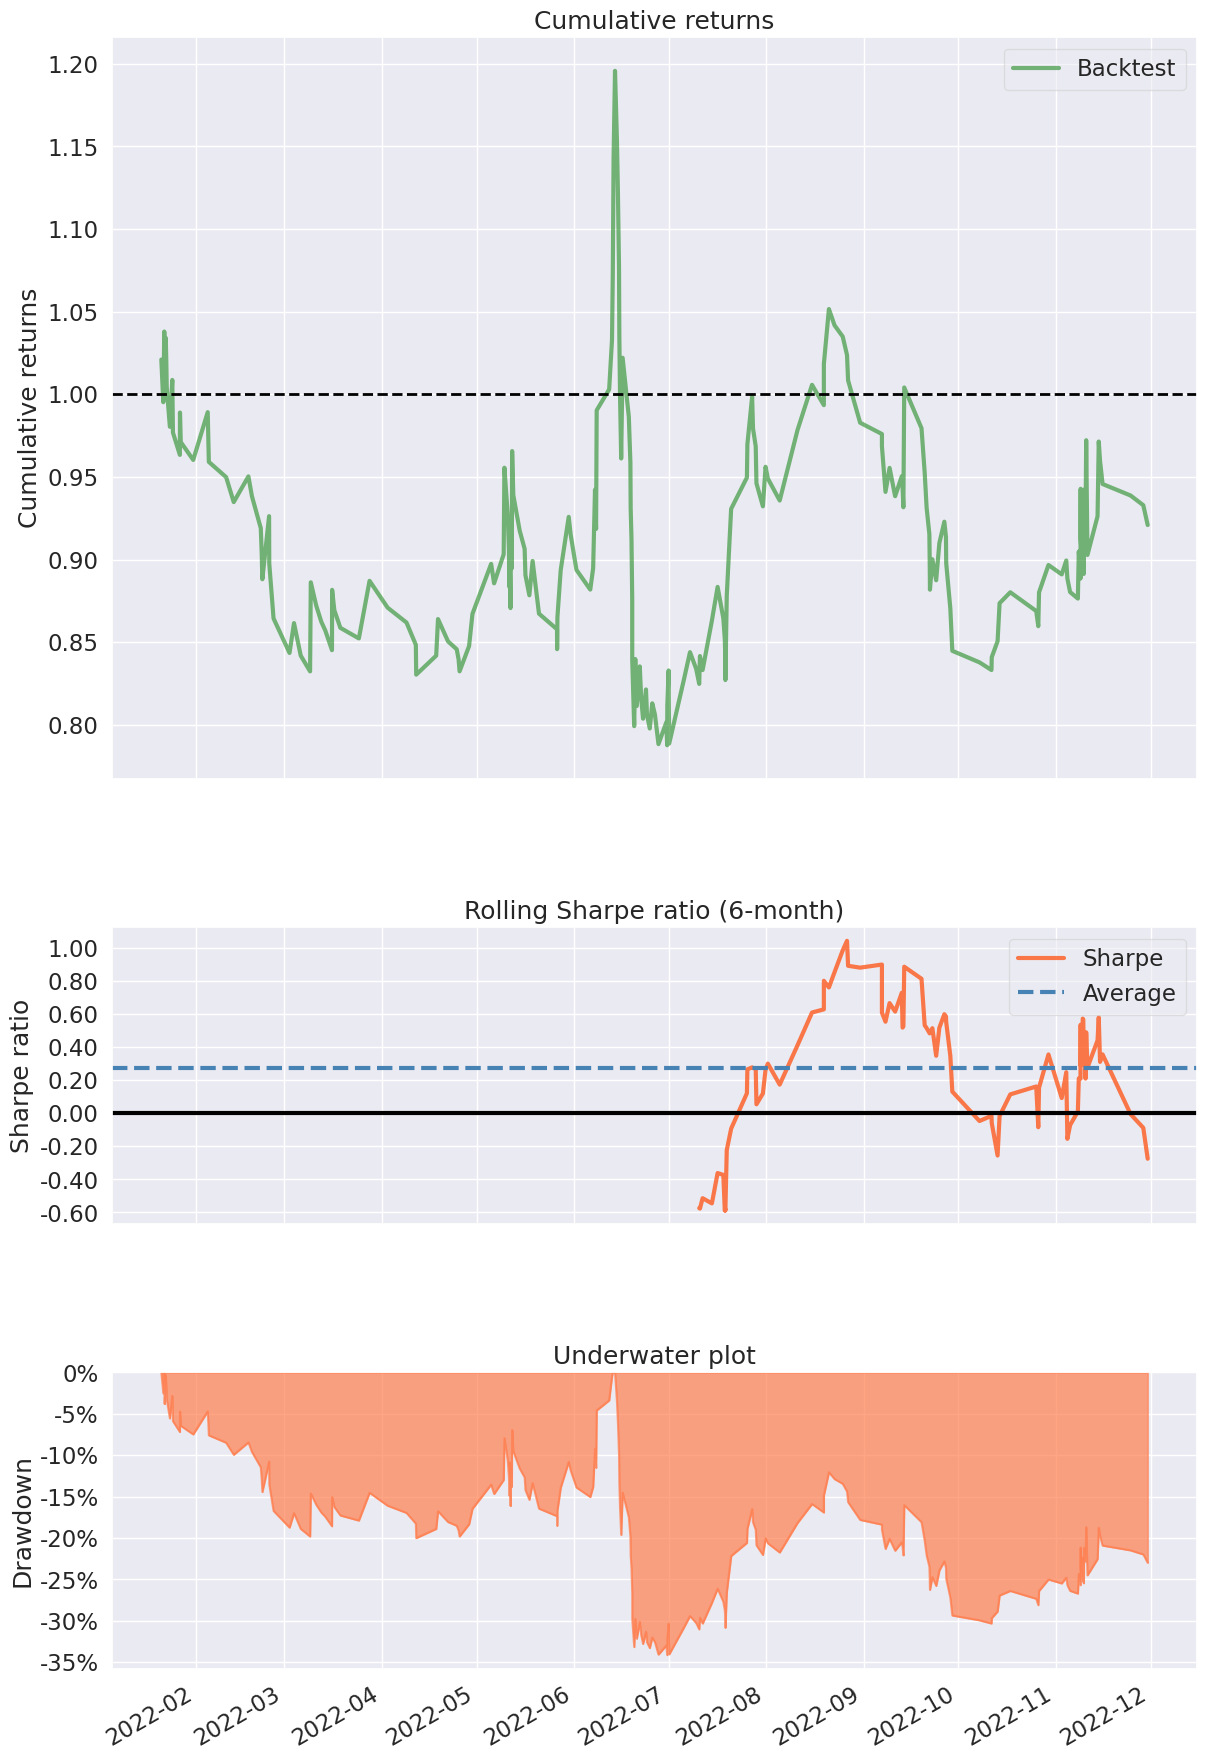

In [82]:
stats_df = stats['_trades'][['ReturnPct', 'EntryTime']]
stats_df = stats_df.set_index('EntryTime')

pf.create_simple_tear_sheet(stats_df['ReturnPct'])